In [7]:
# https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter as gf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

from xrdc.datasets import d3d
from xrdc import featurization as feat
from xrdc import source_separation as sep
from xrdc.dataproc.dataproc.operations import hitp
from xrdc import visualization as vis

from xrdc import peak_fitting as pf

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


In [2]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [125]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [808]:
def get_coords(dgrid):
    coords = np.array([dgrid.coord(ii + 1) for ii in range(177)])
    return coords

swap3d = lambda arr: np.einsum("ijk->kij", arr)

def csim3d(activations_n1):
    #activations_n1 = swap3d(activations_n1)
    tmp = np.einsum("kij, klm->ijlm", activations_n1, activations_n1)

    norm = np.linalg.norm(activations_n1, axis = 0)

    norm4d = np.einsum("ij, kl->ijkl", norm, norm)

    tmp_csim = tmp / (norm4d + 1e-30)
    return tmp_csim

def gridstack(arr4d):
    return np.vstack(np.dstack(np.transpose(arr4d, (1, 0, 2, 3))))

def plot_clusters_grid(coords, clust, nclust):
    import matplotlib
    dim = coords.max()
    coordi = coords - 1
    hues = [float(float(x)/float(nclust)) for x in range(1,nclust+1)]
    cg = cluster_grid = np.zeros(shape = (dim,dim,3))
    for k, (x, y) in enumerate(coordi):
        cluster = clust[k]
        cluster_grid[x, y] = matplotlib.colors.hsv_to_rgb([hues[cluster],1,1])
#     if debug:
#         print(coords)

#     fig = plt.figure()
#     fig.tight_layout()
    start, end = nclust - 1, nclust
    Big_labels = []
    Big_labels.append(clust)
    plt.imshow(cg)
    
def rmap(arr):
    """
    Map feature indices to random floats for visualization (temporary hack)
    """
    imax = arr.max()
    arr = arr.copy().astype(float)

    for i in range(1, imax + 1):
        new = np.random.random()
        arr[arr == i] = new
    return arr
 
# merge eventually into featurization.peakfit_featurize, needs to be more general to handle both 2 and 3-d arrays
def peakfit_featurize(patterns_pp, fitlists, size_thresh = 5, thicken_ax0 = 1,
                      thicken_ax1 = 0,
                      smooth_ax0 = 2, normf = feat.norm3d, sizetype = 'count',
                     area_min = 1):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
        smooth_ax1 = 1,
        smooth_ax0 = smooth_ax0, threshold_percentile = 50, thicken = True, size_thresh = size_thresh, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = thicken_ax0,
        thicken_ax1 = thicken_ax1, flood_threshold=.95, smooth_factor_ax1 = .125, fitlists = fitlists,
        peakwidth = 1, normf = normf, sizetype = sizetype, area_min = area_min)
    return labeled, feature_masks, activations, norm_, activations_n1

# heatmap overlayed with binary mask
def overlay_mask(img, mask, **kwargs):
    mask = mask.astype(bool).astype(float)
    grayscale = 1 - mask
    alpha = mask
    rgb_img = np.dstack((grayscale, (grayscale), grayscale, (alpha)))
    plt.imshow(np.log(1 + img), cmap = 'jet', **kwargs)
    plt.imshow(rgb_img, cmap = 'Greys', **kwargs)
    
def plot_slices(callback, *args, N = 15, **kwargs):
    a, b = N, 1
    for i in range(N):
        plt.subplot(a, b, i + 1)
        plt.title('slice number {}'.format(i + 1), loc = 'right')
        callback(*(arg[i] for arg in args), **kwargs)

In [5]:
# multiply normalized patterns by 1000 so that the peak-finding routine will play nice
patterns = m3d = 1000 * d3d.get_data().copy()
#patterns = m3d_agglom# = m3d.reshape(15, 15, -1, 2).sum(axis = 3)

In [554]:
tmp2 = fsub_stop_2d

In [663]:
from xrdc import source_separation as sep
background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = True,
                                                    threshold = 5, smooth_q = 1.7, bg_fill_method = 'simple')
#                                                          ,
#                                                         smooth_neighbor_background = 0)
# TODO hack
fast_T[0, :, :] /= 6
fast_T[-1, :, :] /= 6
fast_T[:, 0, :] /= 6
fast_T[:, -1, :] /= 6

(0, 0, 0)


In [899]:


# slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns)

# #background = sep.get_background(patterns, threshold = 25, smooth_q = 1.7, method = 'simple')
# background = sep.get_background(slow_T, threshold = 25, smooth_q = 1.7, bg_fill_method = 'simple')

fsub_stop_2d = pf.curvefit_2d(patterns, background = background,
                         noise_estimate = fast_T, stdratio_threshold = 3)



numBlocks: 92, dataPts/Block: 8.695652173913043
[  0.  31.  87. 261. 304. 318. 377. 423. 516. 540. 655. 747. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 31.0], [31.0, 87.0], [87.0, 261.0], [261.0, 304.0], [304.0, 318.0], [318.0, 377.0], [377.0, 423.0], [423.0, 516.0], [516.0, 540.0], [540.0, 655.0], [655.0, 747.0], [747.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 9, start iteration with error = 0.10221404634967225
2.799528887628081
Peak at 59, start iteration with error = 0.19005710540446463
1.99251527597368
Peak at 137, start iteration with error = 0.16316227613427556
1.5980188619113858
Peak at 286, start iteration with error = 0.5170020554847846
3.7899766181743613
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300 301 302 303]
Peak a

Peak at 532, iteration 0: error = 0.1128224718788478
1.4731115268937047
bounds ([450.05, -0.6589290058692145, 0, 0, 0], [602.95, inf, inf, 34.75, 34.75])
[457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546
 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582
 583 584 585 586 587 588 589 590 591 592 593 594 595 596]
Peak at 605, start iteration with error = 0.16594061413427014
2.3423148142375854
Peak at 718, start iteration with error = 0.40708673866910333
8.192028654900218
[608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 63

    ----Saving data for block between 1.00 - 85.00
dropping block with index 1
    ----Saving data for block between 262.00 - 338.00
    ----Saving data for block between 339.00 - 456.00
    ----Saving data for block between 457.00 - 597.00
dropping block with index 5
    ----Saving data for block between 608.00 - 798.00
done
numBlocks: 71, dataPts/Block: 11.267605633802816
[  0.  27.  85. 261. 342. 457. 595. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 27.0], [27.0, 85.0], [85.0, 261.0], [261.0, 342.0], [342.0, 457.0], [457.0, 595.0], [595.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 10, start iteration with error = 0.0732916736466174
8.026760143230335
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Peak at 10, iteration 0: error = 0.39005678139721134
35.724280193420974
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 1

Peak at 125, start iteration with error = 0.35280039037632005
20.87027928788388
[ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Peak at 125, iteration 0: error = 0.13910741524769502
7.503786822816351
[ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Peak at 125, iteration 1: error = 0.05202927489505009
2.3213227081617656
bounds ([88.4, -1.508235628670352, 0, 0, 0, 88.4, -1.508235628670352, 0, 0, 0], [145.6, inf, inf, 13.0, 13.0, 145.6, inf, inf, 13.0, 13.0])
[ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 

Peak at 718, start iteration with error = 0.44161279491813005
15.91806130990065
[620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655
 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673
 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745
 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763
 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 718, iteration 0: error = 0.11070425236723154
3.44573911410034
[620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 649 

Peak at 532, start iteration with error = 0.2786877075930015
11.784272419182464
[460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603
 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639
 640 641 642 643 644 645 646]
Peak at 532, iteration 0: error = 0.09366936927032243
2.7278099605158315
bounds ([450.7, -0.572569385913563, 0, 0, 0], [655.3, inf, inf, 46.5, 46.5])
[460 461 4

Peak at 168, iteration 1: error = 0.01747748078381871
0.6477698563999729
bounds ([161.75, -0.29051985232255356, 0, 0, 0, 161.75, -0.29051985232255356, 0, 0, 0], [189.25, inf, inf, 6.25, 6.25, 189.25, inf, inf, 6.25, 6.25])
[163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188]
Peak at 199, start iteration with error = 0.0955933249177418
5.037162678367736
[189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230]
Peak at 199, iteration 0: error = 0.22275060282955844
6.596108371325554
[189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230]
Peak at 199, iteration 1: error = 0.02074623396704778
0.7790032645682426
bounds ([186.95, -0.24320533824423796, 0, 0, 0, 186.95, -0.24320533824423796, 0, 0, 0], [232.05, inf, 

Peak at 286, iteration 0: error = 0.18535679839945077
0.9144617948519447
bounds ([259.95, -7.430575516265527, 0, 0, 0], [305.05, inf, inf, 10.25, 10.25])
[262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303]
Peak at 310, start iteration with error = 0.22989679768672308
1.4390777292821195
Peak at 325, start iteration with error = 0.18513811144291292
2.15414644175997
Peak at 388, start iteration with error = 0.1684035654343027
9.373017570242652
[372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423]
Peak at 388, iteration 0: error = 0.3598698603593901
11.376160013264114
[372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 

Peak at 133, iteration 0: error = 0.3043833964314935
4.5604143159065424
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259]
Peak at 133, iteration 1: error = 0.03915016798987634
0.75255822133744
bounds ([80.5, -0.6998811464917923, 0, 0, 0, 80.5, -0.6998811464917923, 0, 0, 0], [267.5, inf, inf, 42.5, 42.5, 267.5, inf, inf, 42.5, 42.5])
[ 89  90  91  92  93

Peak at 59, iteration 1: error = 0.06310788552038989
1.2631901508177152
bounds ([-3.1500000000000004, -1.670250009161016, 0, 0, 0, -3.1500000000000004, -1.670250009161016, 0, 0, 0], [88.15, inf, inf, 20.75, 20.75, 88.15, inf, inf, 20.75, 20.75])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84]
Peak at 131, start iteration with error = 0.128990959459588
4.842146134969269
[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 1

    ----Saving data for block between 1.00 - 84.00
    ----Saving data for block between 85.00 - 263.00
    ----Saving data for block between 264.00 - 373.00
    ----Saving data for block between 374.00 - 456.00
    ----Saving data for block between 457.00 - 567.00
    ----Saving data for block between 568.00 - 650.00
    ----Saving data for block between 651.00 - 798.00
done
numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  84. 139. 342. 456. 566. 608. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 84.0], [84.0, 139.0], [139.0, 342.0], [342.0, 456.0], [456.0, 566.0], [566.0, 608.0], [608.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 59, start iteration with error = 0.16469096084403245
26.191065356765467
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47

Peak at 605, start iteration with error = 0.11596559955749297
17.110498423564557
[566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 605 606 607]
Peak at 605, iteration 0: error = 0.03663732779639826
3.9260676951988485
[566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 605 606 607]
Peak at 605, iteration 1: error = 0.024589556355793397
2.312874547781386
bounds ([563.95, -0.16088389456680824, 0, 0, 0, 563.95, -0.16088389456680824, 0, 0, 0], [609.05, inf, inf, 10.25, 10.25, 609.05, inf, inf, 10.25, 10.25])
[566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 605 606 607]
Peak at 718, start iteration with error = 0.43033839604162283
57.56848652455449
[608 609 610 611 612 61

Peak at 532, start iteration with error = 0.24960312874069268
19.159107403456858
[465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536
 537 538 539 540 541 542 543 544 545 546 547 548 549]
Peak at 532, iteration 0: error = 0.18898239669615127
7.182890482719249
[465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536
 537 538 539 540 541 542 543 544 545 546 547 548 549]
Peak at 532, iteration 1: error = 0.04225149680179961
1.9886193104132568
bounds ([460.8, -0.7515273379255861, 0, 0, 0, 460.8, -0.7515273379255861, 0, 0, 0]

Peak at 59, iteration 1: error = 0.04849074692626708
1.5945450429388002
bounds ([26.25, -1.5836859444407543, 0, 0, 0, 26.25, -1.5836859444407543, 0, 0, 0], [86.75, inf, inf, 13.75, 13.75, 86.75, inf, inf, 13.75, 13.75])
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84]
Peak at 115, start iteration with error = 0.14288349762159647
7.251047425458166
[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130]
Peak at 115, iteration 0: error = 0.294923200724288
11.825471406361864
[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130]
Peak at 115, iteration 1: error = 0.0143485916812475
0.8957545430014171
bounds ([

Peak at 605, start iteration with error = 0.17213759039523469
7.9235094437731135
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 605, iteration 0: error = 0.11362584731763664
4.351264241081862
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 605, iteration 1: error = 0.007912452998303373
0.40485184034416916
bounds ([596.5, -0.1458709890329105, 0, 0, 0, 596.5, -0.1458709890329105, 0, 0, 0], [607.5, inf, inf, 2.5, 2.5, 607.5, inf, inf, 2.5, 2.5])
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 718, start iteration with error = 0.43707366817620685
27.81910883714203
[608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661
 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679
 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697
 698 699 700 701 702 703 704 705 706 707 708 709 

Peak at 405, iteration 1: error = 0.05907972661308252
2.1758860815016745
bounds ([373.6, -0.6158292059324378, 0, 0, 0, 373.6, -0.6158292059324378, 0, 0, 0], [492.4, inf, inf, 27.0, 27.0, 492.4, inf, inf, 27.0, 27.0])
[379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432
 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468
 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486
 487]
Peak at 495, start iteration with error = 0.16283254891243637
5.447732592782212
[488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505
 506 507 508 509 510 511 512 513]
Peak at 495, iteration 0: error = 0.23376345018077124
5.1590861370691306
[488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505
 506 5

Peak at 241, start iteration with error = 0.14985054558877237
7.717552644788057
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265]
Peak at 241, iteration 0: error = 0.0472646505819632
2.0066710817198326
bounds ([198.85, -0.2801839914539043, 0, 0, 0], [268.15, inf, inf, 15.75, 15.75])
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265]
Peak at 287, start iteration with error = 0.5593741913324436
50.84183459244328
[266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293 294]
Peak at 287, iteration 0: error = 0.1130189837

    ----Saving data for block between 1.00 - 90.00
    ----Saving data for block between 91.00 - 143.00
    ----Saving data for block between 144.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 265.00
    ----Saving data for block between 266.00 - 294.00
    ----Saving data for block between 295.00 - 313.00
    ----Saving data for block between 314.00 - 373.00
    ----Saving data for block between 374.00 - 458.00
dropping block with index 9
    ----Saving data for block between 498.00 - 618.00
    ----Saving data for block between 619.00 - 798.00
done
numBlocks: 76, dataPts/Block: 10.526315789473685
[  0.  29.  91. 163. 190. 202. 244. 292. 315. 374. 459. 620. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 29.0], [29.0, 91.0], [91.0, 163.0], [163.0, 190.0], [190.0, 202.0], [202.0, 244.0], [244.0, 292.0], [292.0, 315.0], [315.0, 374.0], [374.0, 459.0], [459.0, 620.0], [620.0, 799.0]]}
negative values in ba

Peak at 319, start iteration with error = 0.14172486905700282
13.772154770199231
[315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369 370 371 372 373]
Peak at 319, iteration 0: error = 0.21033533866342224
4.0721711018913656
[315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369 370 371 372 373]
Peak at 319, iteration 1: error = 0.023630906857793618
1.1446084603703495
bounds ([312.1, -1.0115825970098324, 0, 0, 0, 312.1, -1.0115825970098324, 0, 0, 0], [375.9, inf, inf, 14.5, 14.5, 375.9, inf, inf, 14.5, 14.5])
[315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350


    ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 90.00
    ----Saving data for block between 91.00 - 162.00
    ----Saving data for block between 163.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 243.00
    ----Saving data for block between 244.00 - 291.00
    ----Saving data for block between 292.00 - 314.00
    ----Saving data for block between 315.00 - 373.00
    ----Saving data for block between 374.00 - 458.00
    ----Saving data for block between 459.00 - 619.00
    ----Saving data for block between 620.00 - 798.00
done
numBlocks: 83, dataPts/Block: 9.63855421686747
[  0.  30.  90. 163. 190. 202. 244. 298. 369. 459. 646. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 30.0], [30.0, 90.0], [90.0, 163.0], [163.0, 190.0], [190.0, 202.0], [202.0, 244.0], [244.0, 298.0], [298.0, 369.0], [369.0, 459.0], [459.0, 646.0], [646.0, 799.0]]}
negative values in b

Peak at 389, iteration 0: error = 0.29215490928178295
19.639011409249836
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458]
Peak at 389, iteration 1: error = 0.038550538064132826
3.0043271403130967
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458]
Peak at 389, iteration 2: error = 0.03855053806392122
3.004327140327674
[369 370 371 372 373 374 375 376 377 378 379 380 

    ----Saving data for block between 1.00 - 29.00
    ----Saving data for block between 30.00 - 89.00
    ----Saving data for block between 90.00 - 162.00
    ----Saving data for block between 163.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 243.00
    ----Saving data for block between 244.00 - 297.00
    ----Saving data for block between 298.00 - 368.00
    ----Saving data for block between 369.00 - 458.00
    ----Saving data for block between 459.00 - 645.00
    ----Saving data for block between 646.00 - 798.00
done
numBlocks: 81, dataPts/Block: 9.876543209876543
[  0.  88. 230. 303. 374. 465. 577. 650. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 88.0], [88.0, 230.0], [230.0, 303.0], [303.0, 374.0], [374.0, 465.0], [465.0, 577.0], [577.0, 650.0], [650.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a sin

Peak at 606, start iteration with error = 0.11281845631336676
10.15898183464154
[577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649]
Peak at 606, iteration 0: error = 0.04889938008484507
3.454088425744954
[577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649]
Peak at 606, iteration 1: error = 0.048485474640679975
3.4161718177579385
[577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620

Peak at 605, iteration 0: error = 0.046007174826511656
1.4566421459643897
bounds ([574.2, -0.17768500077185287, 0, 0, 0], [657.8, inf, inf, 19.0, 19.0])
[578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595
 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613
 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631
 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649
 650 651 652 653 654]
Peak at 717, start iteration with error = 0.4816659262862638
16.27607783647831
[655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672
 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690
 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708
 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726
 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744
 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762
 763 764 765 766

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 319, iteration 1: error = 0.01524292174764606
0.2210582832719967
bounds ([311.05, -0.56979071694707, 0, 0, 0, 311.05, -0.56979071694707, 0, 0, 0], [375.95, inf, inf, 14.75, 14.75, 375.95, inf, inf, 14.75, 14.75])
[314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373]
Peak at 388, start iteration with error = 0.1539343083532518
17.145614039853946
[374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409
 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427
 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 388, i

Peak at 116, iteration 1: error = 0.025073569644309648
1.0163779458808455
bounds ([79.4, -0.3799558013303437, 0, 0, 0, 79.4, -0.3799558013303437, 0, 0, 0], [268.6, inf, inf, 43.0, 43.0, 268.6, inf, inf, 43.0, 43.0])
[ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260]
Peak at 287, start iteration with error = 0.4347214929628805
10.92922043994669
[2

Peak at 59, start iteration with error = 0.18043536346341935
7.076326154344257
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88]
Peak at 59, iteration 0: error = 0.23926599551700972
1.5746165347691445
bounds ([27.1, -2.1705147628817936, 0, 0, 0], [90.9, inf, inf, 14.5, 14.5])
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88]
Peak at 115, start iteration with error = 0.16803726387838264
7.305851580042366
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133]
Peak at 115, iteration 0: error = 0.2913149317871607
9.772950031844932
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 10

Peak at 287, start iteration with error = 0.23769114216055817
28.92021450215352
[137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363

Peak at 286, iteration 0: error = 0.12790334695957967
1.9710133164492238
bounds ([130.5, -7.568539367065085, 0, 0, 0], [339.5, inf, inf, 47.5, 47.5])
[140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330]
Peak at 342, start iteration with error = 0.07061238675096909
3.2560928793

    ----Saving data for block between 1.00 - 83.00
    ----Saving data for block between 84.00 - 139.00
    ----Saving data for block between 140.00 - 330.00
    ----Saving data for block between 331.00 - 349.00
    ----Saving data for block between 350.00 - 466.00
    ----Saving data for block between 467.00 - 545.00
    ----Saving data for block between 546.00 - 607.00
    ----Saving data for block between 608.00 - 798.00
done
numBlocks: 100, dataPts/Block: 8.0
[  0.  29. 114. 135. 164. 196. 203. 281. 312. 376. 430. 454. 489. 522.
 574. 620. 631. 655. 764. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 29.0], [29.0, 114.0], [114.0, 135.0], [135.0, 164.0], [164.0, 196.0], [196.0, 203.0], [203.0, 281.0], [281.0, 312.0], [312.0, 376.0], [376.0, 430.0], [430.0, 454.0], [454.0, 489.0], [489.0, 522.0], [522.0, 574.0], [574.0, 620.0], [620.0, 631.0], [631.0, 655.0], [655.0, 764.0], [764.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile

/home/ollie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Peak at 405, iteration 0: error = 0.20735966932134972
8.55662398461104
[376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429]
Peak at 405, iteration 1: error = 0.022825729447596595
1.13627269042957
bounds ([373.35, -0.7740283166684372, 0, 0, 0, 373.35, -0.7740283166684372, 0, 0, 0], [431.65, inf, inf, 13.25, 13.25, 431.65, inf, inf, 13.25, 13.25])
[376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429]
Peak at 437, start iteration with error = 0.13274956155637932
19.55226704746207
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453]
Peak at 437, iteration 0: error = 0.3194681817599811
28.96676593147219
[430 431 432 43

Peak at 769, iteration 1: error = 0.035938228874900315
0.9698339360648883
bounds ([762.3, -0.4893720528192323, 0, 0, 0, 762.3, -0.4893720528192323, 0, 0, 0], [799.7, inf, inf, 8.5, 8.5, 799.7, inf, inf, 8.5, 8.5])
[764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
    ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 113.00
    ----Saving data for block between 114.00 - 134.00
    ----Saving data for block between 135.00 - 163.00
    ----Saving data for block between 164.00 - 195.00
    ----Saving data for block between 196.00 - 202.00
    ----Saving data for block between 203.00 - 280.00
    ----Saving data for block between 281.00 - 311.00
    ----Saving data for block between 312.00 - 375.00
    ----Saving data for block between 376.00 - 429.00
    ----Saving data for block between 430.00 - 453.00
    ----Saving data for block between 454.00 - 488.00

Peak at 768, start iteration with error = 0.2272201754848999
6.575372421419141
[762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 798]
Peak at 768, iteration 0: error = 0.1515040968156374
2.0557503652409177
bounds ([760.2, -0.48338207883895173, 0, 0, 0], [799.8, inf, inf, 9.0, 9.0])
[762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 798]
dropping block with index 0
    ----Saving data for block between 31.00 - 91.00
    ----Saving data for block between 92.00 - 136.00
dropping block with index 3
    ----Saving data for block between 163.00 - 189.00
    ----Saving data for block between 190.00 - 231.00
dropping block with index 6
    ----Saving data for block between 265.00 - 314.00
    ----Saving data for block between 315.00 - 375.00
    ----Saving data for block between 376.00 - 429.00
    ----S

Peak at 495, start iteration with error = 0.1352232054854272
13.111288016534676
[487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513]
Peak at 495, iteration 0: error = 0.18496531229368773
12.641715688819327
[487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513]
Peak at 495, iteration 1: error = 0.02577086122427162
2.083584132379773
bounds ([485.7, -0.20343398594833945, 0, 0, 0, 485.7, -0.20343398594833945, 0, 0, 0], [514.3, inf, inf, 6.5, 6.5, 514.3, inf, inf, 6.5, 6.5])
[487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513]
Peak at 551, start iteration with error = 0.27053746834849807
15.69190749808417
[514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 

Peak at 68, start iteration with error = 0.2780018534199957
31.32889885170822
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
Peak at 68, iteration 0: error = 0.11153591884497463
8.238372724300184
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
Peak at 68, iteration 1: error = 0.07323512395004647
3.9691074754432214
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
Peak at 68, iteration 2: error = 0.0732351239502325
3.969107475449074
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75

Peak at 551, start iteration with error = 0.27581829663136137
23.97118953859781
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565
 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618]
Peak at 551, iteration 0: error = 0.15586325087635386
9.66313030031417
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 

Peak at 125, start iteration with error = 0.28257682549535734
18.641171615480626
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 125, iteration 0: error = 0.1899011305000276
7.259386442156242
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 125, iteration 1: error = 0.07698558053720865
2.6647624469293887
bounds ([86.45, -1.163197107230962, 0, 0, 0, 86.45, -1.163197107230962, 0, 0, 0], [164.55, inf, inf, 17.75, 17.75, 164.55, inf, inf, 17.75, 17.75])
[ 90  91  92  93  94  95  96  97  98  99 

Peak at 718, iteration 1: error = 0.07938481286474063
7.443589679093355
[620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655
 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673
 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745
 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763
 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 718, iteration 2: error = 0.07887563869120083
7.439582984663576
[620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 649 650 651

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 287, start iteration with error = 0.3133321913807077
27.104454608293608
[232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292]
Peak at 287, iteration 0: error = 0.2720213729132802
2.660265394848871
bounds ([229.0, -7.298890163996031, 0, 0, 0], [295.0, inf, inf, 15.0, 15.0])
[232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292]
Peak at 302, start iteration with error = 0.2586344126234555
17.37453844898002
[293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310
 311 312 313 314 315 316 317 318 319

Peak at 718, iteration 2: error = 0.07163900463390573
5.3935354079690185
[596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613
 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631
 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649
 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667
 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685
 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703
 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721
 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739
 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757
 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775
 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793
 794 795 796 797 798]
Peak at 718, iteration 3: error = 0.06044776918243876
bounds ([585.9, -1.8329326374098882, 0, 0, 0, 58

Peak at 606, start iteration with error = 0.14924179724520026
13.442359257324696
[598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633
 634 635 636 637 638 639 640 641 642 643 644 645 646 647]
Peak at 606, iteration 0: error = 0.05170190899252871
4.184141443638739
[598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633
 634 635 636 637 638 639 640 641 642 643 644 645 646 647]
Peak at 606, iteration 1: error = 0.03032752147979748
2.5685770690641125
bounds ([595.55, -0.1606739798891019, 0, 0, 0, 595.55, -0.1606739798891019, 0, 0, 0], [649.45, inf, inf, 12.25, 12.25, 649.45, inf, inf, 12.25, 12.25])
[598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633
 634 635 636 637 638 639 640 641 642 643 644 645 646 647]
Peak at 71

Peak at 530, iteration 0: error = 0.21738181904206783
2.2615497277460923
bounds ([463.15, -0.9359023684093737, 0, 0, 0], [547.85, inf, inf, 19.25, 19.25])
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520
 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544]
Peak at 605, start iteration with error = 0.12794059621211715
3.875153680312067
[545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562
 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580
 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616
 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634
 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652
 653 654 

Peak at 59, start iteration with error = 0.1951954736656783
14.990979034231518
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87 88]
Peak at 59, iteration 0: error = 0.15899813640465502
2.5411795040238174
bounds ([28.15, -1.6450104428037626, 0, 0, 0], [90.85, inf, inf, 14.25, 14.25])
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87 88]
Peak at 116, start iteration with error = 0.08737803337497971
7.530030909921594
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 

    ----Saving data for block between 467.00 - 546.00
    ----Saving data for block between 547.00 - 655.00
    ----Saving data for block between 656.00 - 798.00
done
numBlocks: 85, dataPts/Block: 9.411764705882353
[  0.  90. 130. 335. 466. 548. 654. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 90.0], [90.0, 130.0], [130.0, 335.0], [335.0, 466.0], [466.0, 548.0], [548.0, 654.0], [654.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 59, start iteration with error = 0.18881386247173917
11.914815790830746
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 59, iteration 0: error = 0.2072428830050137
4.548961319355627
[ 1  2  3  4 

Peak at 719, iteration 0: error = 0.10609601757973162
2.6143949058040112
bounds ([646.8, -2.3772769582116524, 0, 0, 0], [805.2, inf, inf, 36.0, 36.0])
[654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671
 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689
 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707
 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725
 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743
 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761
 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 798]
    ----Saving data for block between 1.00 - 89.00
    ----Saving data for block between 90.00 - 129.00
    ----Saving data for block between 130.00 - 334.00
    ----Saving data for block between 335.00 - 465.00
    ----Saving data for block between 466.00 - 

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 605, iteration 1: error = 0.047343833504882984
8.87626069949427
[547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582
 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600
 601 602 603 604 605 606 607 608]
Peak at 605, iteration 2: error = 0.027830650691296643
6.195972331060302
[547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582
 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600
 601 602 603 604 605 606 607 608]
Peak at 605, iteration 3: error = 0.017087573890484327
bounds ([543.95, -0.15436646173185248, 0, 0, 0, 543.95, -0.15436646173185248, 0, 0, 0, 543.95, -0.15436646173185248, 0, 0, 0, 543.95, -0.15436646173185248, 0, 0, 0], [611.05, inf, inf, 15.25, 15.25, 611.05, i

Peak at 533, start iteration with error = 0.22599755005734104
18.45590799199333
[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549]
Peak at 533, iteration 0: error = 0.17362227458680823
5.3068933583959845
[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549]
Peak at 533, iteration 1: error = 0.03705092278315977
1.4423468235059136
bounds ([458.7, -1.0040965078128468, 0, 0, 0, 458.7, -1.0040965078

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 405, iteration 1: error = 0.04612270408576758
1.1510492935262104
bounds ([373.3, -0.9185911032125057, 0, 0, 0, 373.3, -0.9185911032125057, 0, 0, 0], [432.7, inf, inf, 13.5, 13.5, 432.7, inf, inf, 13.5, 13.5])
[376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430]
Peak at 437, start iteration with error = 0.1424881311764228
5.9830491080381805
[431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452 453]
Peak at 437, iteration 0: error = 0.32387013811525484
7.863929212945038
[431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452 453]
Peak at 437, iteration 1: error = 0.0198278826208389
0.5695066329995385
bounds ([429.9, -0.38581529057110253, 0, 0, 0, 429.9, -0.3

Peak at 405, iteration 0: error = 0.15078955833643218
5.73105145132722
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429]
Peak at 405, iteration 1: error = 0.028191087226236183
1.1927365759064825
bounds ([370.2, -0.8586520491618242, 0, 0, 0, 370.2, -0.8586520491618242, 0, 0, 0], [431.8, inf, inf, 14.0, 14.0, 431.8, inf, inf, 14.0, 14.0])
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429]
Peak at 436, start iteration with error = 0.16088634672637692
15.641485708479635
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 436, iteration 0: error = 0.2

Peak at 68, start iteration with error = 0.2794107828422166
20.37886131469703
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
Peak at 68, iteration 0: error = 0.07149345348795462
1.3475346628506033
bounds ([25.9, -1.6877265724631973, 0, 0, 0], [94.1, inf, inf, 15.5, 15.5])
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
Peak at 125, start iteration with error = 0.3535991361782179
13.287858108132287
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162]
Peak at 125, iterat

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 627, iteration 1: error = 0.032618287836883746
2.864019740840778
bounds ([568.05, -0.27236553471500213, 0, 0, 0, 568.05, -0.27236553471500213, 0, 0, 0], [632.95, inf, inf, 14.75, 14.75, 632.95, inf, inf, 14.75, 14.75])
[571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624
 625 626 627 628 629 630]
Peak at 652, start iteration with error = 0.18048618342230863
36.3492785092642
[631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649 650 651 652 653 654]
Peak at 652, iteration 0: error = 0.2236508823545356
31.158117470037535
[631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649 650 651 652 653 654]
Peak at 652, iteration 1: error = 0.029310756155723705
4.430510405067043
[631 632 633 634 635

Peak at 168, iteration 1: error = 0.037421893430862614
1.1187700695752054
bounds ([161.7, -0.27558339789460484, 0, 0, 0, 161.7, -0.27558339789460484, 0, 0, 0], [190.3, inf, inf, 6.5, 6.5, 190.3, inf, inf, 6.5, 6.5])
[163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189]
Peak at 199, start iteration with error = 0.13178004732204737
4.912339201951458
[190 191 192 193 194 195 196 197 198 199 200 201]
Peak at 199, iteration 0: error = 0.22685386432549845
7.283436059569529
[190 191 192 193 194 195 196 197 198 199 200 201]
Peak at 199, iteration 1: error = 0.009642798673794735
0.43563610182803614
bounds ([189.45, -0.17852503680980839, 0, 0, 0, 189.45, -0.17852503680980839, 0, 0, 0], [201.55, inf, inf, 2.75, 2.75, 201.55, inf, inf, 2.75, 2.75])
[190 191 192 193 194 195 196 197 198 199 200 201]
Peak at 241, start iteration with error = 0.11346679407496381
9.630026169158807
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 2

Peak at 719, iteration 3: error = 0.06154010002146451
bounds ([625.95, -1.0663198258603739, 0, 0, 0, 625.95, -1.0663198258603739, 0, 0, 0, 625.95, -1.0663198258603739, 0, 0, 0, 625.95, -1.0663198258603739, 0, 0, 0], [737.05, inf, inf, 25.25, 25.25, 737.05, inf, inf, 25.25, 25.25, 737.05, inf, inf, 25.25, 25.25, 737.05, inf, inf, 25.25, 25.25])
[631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666
 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684
 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702
 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720
 721 722 723 724 725 726 727 728 729 730 731 732]
Peak at 741, start iteration with error = 0.3761992011503794
44.76564591276476
[733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750
 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768
 769 770 771 7

Peak at 241, start iteration with error = 0.08512230869567362
16.568449478437422
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243]
Peak at 241, iteration 0: error = 0.2387807490646518
27.84157486840115
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 241, iteration 1: error = 0.025020973033288114
4.179845979501714
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243]
Peak at 241, iteration 2: error = 0.022754921931792436
4.221319604479631
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 22

Peak at 551, iteration 3: error = 0.07839160730575091
bounds ([452.7, -0.4997668339052178, 0, 0, 0, 452.7, -0.4997668339052178, 0, 0, 0, 452.7, -0.4997668339052178, 0, 0, 0, 452.7, -0.4997668339052178, 0, 0, 0], [569.3, inf, inf, 26.5, 26.5, 569.3, inf, inf, 26.5, 26.5, 569.3, inf, inf, 26.5, 26.5, 569.3, inf, inf, 26.5, 26.5])
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564]
Peak at 628, start iteration with error = 0.1357175703457654
17.680973539249866
[565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582
 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600
 601 602 

Peak at 68, start iteration with error = 0.2431406862662577
59.78537874327808
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 68, iteration 0: error = 0.21488803917225605
29.884887575088758
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 68, iteration 1: error = 0.10049759141593437
12.828580326563216
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 68, iteration 2: error = 0.1004975914159342
12.828580326563218
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

Peak at 532, start iteration with error = 0.316950938788845
44.47143035089583
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565
 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 532, iteration 0: error = 0.13831571555939387
13.97503401765216
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 5

    ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 92.00
    ----Saving data for block between 93.00 - 264.00
    ----Saving data for block between 265.00 - 295.00
    ----Saving data for block between 296.00 - 367.00
    ----Saving data for block between 368.00 - 457.00
    ----Saving data for block between 458.00 - 595.00
    ----Saving data for block between 596.00 - 630.00
    ----Saving data for block between 631.00 - 798.00
done
numBlocks: 76, dataPts/Block: 10.526315789473685
[  0.  92. 233. 297. 370. 462. 596. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 92.0], [92.0, 233.0], [233.0, 297.0], [297.0, 370.0], [370.0, 462.0], [462.0, 596.0], [596.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 59, start iteration with error = 0.20015976946568195
21.022555011266714
[ 1  2  3  4  5  6  7  8  9 10 11 12

Peak at 532, start iteration with error = 0.3082181643219469
42.56978061877016
[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497
 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515
 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587
 588 589 590 591 592 593 594 595]
Peak at 532, iteration 0: error = 0.12242077543596751
9.634242545179287
[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497
 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515
 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536

Peak at 389, iteration 1: error = 0.04444962126606705
1.3587723587207836
bounds ([360.05, -0.6380208140526017, 0, 0, 0, 360.05, -0.6380208140526017, 0, 0, 0], [468.95, inf, inf, 24.75, 24.75, 468.95, inf, inf, 24.75, 24.75])
[365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418
 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436
 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454
 455 456 457 458 459 460 461 462 463 464]
Peak at 532, start iteration with error = 0.2712030384770627
12.521956802236032
[465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 

Peak at 604, start iteration with error = 0.13195649902290618
6.787533936780646
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603
 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639
 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657
 658]
Peak at 604, iteration 0: error = 0.051751687926799725
2.108442712526323
bounds ([544.6, -0.19729897058393503, 0, 0, 0], [663.4, inf, inf, 27.0, 27.0])
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603
 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629

Peak at 388, iteration 1: error = 0.017506737404060183
0.6793529886941452
bounds ([357.85, -0.8111979493695246, 0, 0, 0, 357.85, -0.8111979493695246, 0, 0, 0], [471.15, inf, inf, 25.75, 25.75, 471.15, inf, inf, 25.75, 25.75])
[363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380
 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398
 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416
 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434
 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452
 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 531, start iteration with error = 0.2419067967356306
6.597669467634326
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520
 521 522 523 524 525 526 527 528 529 530 531 532 533 

Peak at 605, iteration 1: error = 0.03177903847174587
2.328904135223464
bounds ([543.8, -0.16113774128425828, 0, 0, 0, 543.8, -0.16113774128425828, 0, 0, 0], [658.2, inf, inf, 26.0, 26.0, 658.2, inf, inf, 26.0, 26.0])
[549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620
 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638
 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653]
Peak at 718, start iteration with error = 0.47055716074315795
12.778928882958526
[654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671
 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689
 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707
 708 709 710 711 712 713 714 715 716 717 718 719 720 72

Peak at 719, start iteration with error = 0.43807783367126585
14.168167458243218
[609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626
 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644
 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662
 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680
 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698
 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716
 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734
 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752
 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770
 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788
 789 790 791 792 793 794 795 796 797 798]
Peak at 719, iteration 0: error = 0.16718427832108834
1.743724746735299
bounds ([599.55, -2.309695131675081, 0, 0, 0], [807.45, inf, inf, 47.25, 47

Peak at 718, start iteration with error = 0.44546461255823105
19.454166963590783
[608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661
 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679
 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697
 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715
 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733
 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751
 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769
 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787
 788 789 790 791 792 793 794 795 796 797 798]
Peak at 718, iteration 0: error = 0.1573701785335768
2.378257218663657
bounds ([598.5, -2.161753708183104, 0, 0, 0], [807.5, inf, inf, 47.5, 47

[  0.  31.  92. 136. 165. 204. 284. 314. 376. 431. 488. 525. 576. 618.
 643. 674. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 31.0], [31.0, 92.0], [92.0, 136.0], [136.0, 165.0], [165.0, 204.0], [204.0, 284.0], [284.0, 314.0], [314.0, 376.0], [376.0, 431.0], [431.0, 488.0], [488.0, 525.0], [525.0, 576.0], [576.0, 618.0], [618.0, 643.0], [643.0, 674.0], [674.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 13, start iteration with error = 0.12969729232429233
3.493912655942777
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Peak at 13, iteration 0: error = 0.25019787008796296
6.02514448187395
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 13, iteration 1: error = 0.009197

Peak at 581, iteration 0: error = 0.1490488978765179
3.0072352767598716
[576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617]
Peak at 581, iteration 1: error = 0.034596795851127356
0.7671643222640198
bounds ([573.95, -0.27464841144261015, 0, 0, 0, 573.95, -0.27464841144261015, 0, 0, 0], [619.05, inf, inf, 10.25, 10.25, 619.05, inf, inf, 10.25, 10.25])
[576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617]
Peak at 627, start iteration with error = 0.20338110861969785
11.61217581069205
[618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635
 636 637 638 639 640 641 642]
Peak at 627, iteration 0: error = 0.2502660064795393
8.726216832578684
[618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635
 636 637 638 639 640 641 642]

Peak at 249, start iteration with error = 0.1429826025674016
2.3277660043795456
Peak at 301, start iteration with error = 0.6136909367480723
21.316609820349456
[280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313]
Peak at 301, iteration 0: error = 0.07657435480886361
0.8461062044695131
bounds ([278.35, -5.835465310573481, 0, 0, 0], [314.65, inf, inf, 8.25, 8.25])
[280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313]
Peak at 321, start iteration with error = 0.1816498612012207
5.724416624990153
[314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374]
Peak at 321, iteration 0: error = 0.1310794407417528
1.2427348855739584
bounds ([3

Peak at 125, start iteration with error = 0.34267934701803326
9.36524879095035
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162]
Peak at 125, iteration 0: error = 0.11006751164467714
1.2692994132310411
bounds ([88.5, -2.3090644425815037, 0, 0, 0], [165.5, inf, inf, 17.5, 17.5])
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162]
Peak at 168, start iteration with error = 0.14959243252667337
6.533208120972118
[163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188]
Peak a

Peak at 651, iteration 3: error = 0.05110626250764399
bounds ([628.1, -0.35129266694115013, 0, 0, 0, 628.1, -0.35129266694115013, 0, 0, 0, 628.1, -0.35129266694115013, 0, 0, 0, 628.1, -0.35129266694115013, 0, 0, 0], [669.9, inf, inf, 9.5, 9.5, 669.9, inf, inf, 9.5, 9.5, 669.9, inf, inf, 9.5, 9.5, 669.9, inf, inf, 9.5, 9.5])
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668]
Peak at 741, start iteration with error = 0.4521356673880862
24.13281408016747
[669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686
 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704
 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722
 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740
 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758
 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 7

Peak at 241, start iteration with error = 0.12992187074606945
10.304962491662156
[233 234 235 236 237 238 239 240 241 242 243]
Peak at 241, iteration 0: error = 0.24912342312863983
16.878151595361814
[233 234 235 236 237 238 239 240 241 242 243]
Peak at 241, iteration 1: error = 0.007813724455427558
0.6718903720492647
bounds ([232.5, -0.19238589223217412, 0, 0, 0, 232.5, -0.19238589223217412, 0, 0, 0], [243.5, inf, inf, 2.5, 2.5, 243.5, inf, inf, 2.5, 2.5])
[233 234 235 236 237 238 239 240 241 242 243]
Peak at 301, start iteration with error = 0.34939542118229844
24.008793184865986
[244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338 339 340 341 342 343 344 3

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 652, iteration 1: error = 0.05500870872996922
7.845660345223815
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668]
Peak at 652, iteration 2: error = 0.05099448537675692
7.201481808514201
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668]
Peak at 652, iteration 3: error = 0.051247902942968895
bounds ([628.1, -0.31095532843909385, 0, 0, 0, 628.1, -0.31095532843909385, 0, 0, 0, 628.1, -0.31095532843909385, 0, 0, 0, 628.1, -0.31095532843909385, 0, 0, 0], [669.9, inf, inf, 9.5, 9.5, 669.9, inf, inf, 9.5, 9.5, 669.9, inf, inf, 9.5, 9.5, 669.9, inf, inf, 9.5, 9.5])
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 6

Peak at 287, start iteration with error = 0.159436073490751
52.47173602542823
[170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289]
Peak at 287, iteration 0: error = 0.19600433475261106
7.411410248837892
[170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 2

Peak at 627, start iteration with error = 0.14919441244312465
27.227478313156723
[559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630]
Peak at 627, iteration 0: error = 0.05601303652992034
6.993689449731611
[559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630]
Peak at 627, iteration 1: error = 0.055957254311608425
6.276731741528893
[559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 6

Peak at 125, start iteration with error = 0.13458688314529646
29.86741501221648
[ 94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264]
Peak at 125, iteration 0: error = 0.24016054966322672
16.855029421366993
[ 94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 1

Peak at 533, start iteration with error = 0.1285244022067383
37.3291450425624
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535]
Peak at 533, iteration 0: error = 0.2011521999020686
23.821690042337863
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535]
Peak at 533, iteration 1: error = 0.02295804907368684
3.2396991314155685
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492

    ----Saving data for block between 1.00 - 93.00
    ----Saving data for block between 94.00 - 264.00
    ----Saving data for block between 265.00 - 294.00
    ----Saving data for block between 295.00 - 374.00
    ----Saving data for block between 375.00 - 457.00
    ----Saving data for block between 458.00 - 535.00
    ----Saving data for block between 536.00 - 597.00
    ----Saving data for block between 598.00 - 630.00
    ----Saving data for block between 631.00 - 654.00
    ----Saving data for block between 655.00 - 724.00
    ----Saving data for block between 725.00 - 798.00
done
numBlocks: 80, dataPts/Block: 10.0
[  0.  94. 262. 296. 375. 463. 596. 643. 734. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 94.0], [94.0, 262.0], [262.0, 296.0], [296.0, 375.0], [375.0, 463.0], [463.0, 596.0], [596.0, 643.0], [643.0, 734.0], [734.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
run

Peak at 532, start iteration with error = 0.29437911137711065
34.76032766046164
[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595]
Peak at 532, iteration 0: error = 0.14109193692040525
10.89679872255358
[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 53

Peak at 67, iteration 2: error = 0.12273345894076192
4.309147030986418
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 67, iteration 3: error = 0.12273345895481014
bounds ([25.85, -0.9273520434764937, 0, 0, 0, 25.85, -0.9273520434764937, 0, 0, 0, 25.85, -0.9273520434764937, 0, 0, 0, 25.85, -0.9273520434764937, 0, 0, 0], [95.15, inf, inf, 15.75, 15.75, 95.15, inf, inf, 15.75, 15.75, 95.15, inf, inf, 15.75, 15.75, 95.15, inf, inf, 15.75, 15.75])
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 124, start iteration with error = 0.10839455976645958
5.7834025073550075
[ 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 1

numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  90. 253. 370. 464. 594. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 90.0], [90.0, 253.0], [253.0, 370.0], [370.0, 464.0], [464.0, 594.0], [594.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 59, start iteration with error = 0.20288546587599238
11.016693277209031
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 59, iteration 0: error = 0.2149142556062161
5.221422618032059
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66

Peak at 59, iteration 0: error = 0.2425684051539715
5.6532546957839305
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 59, iteration 1: error = 0.0651670577102019
1.6394529163212812
bounds ([-3.4000000000000004, -0.9654677648550591, 0, 0, 0, -3.4000000000000004, -0.9654677648550591, 0, 0, 0], [93.4, inf, inf, 22.0, 22.0, 93.4, inf, inf, 22.0, 22.0])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 114, start iteration with error = 0.07380112917349536
7.59759666244326
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 

Peak at 285, start iteration with error = 0.2531243142535581
8.649505856266105
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364]
Peak at 285, iteration 0: error = 0.29027993445513783
0.7178278723223406
bounds ([246.4, -8.884182672711832, 0, 0, 0], [369.6, inf, inf, 28.0, 28.0])
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 32

Peak at 388, iteration 0: error = 0.36955073941912725
14.416108046629065
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469]
Peak at 388, iteration 1: error = 0.010046220890368317
0.5383446773867652
bounds ([364.0, -0.6783505318581666, 0, 0, 0, 364.0, -0.6783505318581666, 0, 0, 0], [474.0, inf, inf, 25.0, 25.0, 474.0, inf, inf, 25.0, 25.0])
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 4

Peak at 605, iteration 0: error = 0.09200920500544797
3.1416140428851507
[598 599 600 601 602 603 604 605 606 607 608]
Peak at 605, iteration 1: error = 0.012846247627898223
0.48951090064239533
bounds ([597.5, -0.1114825422341115, 0, 0, 0, 597.5, -0.1114825422341115, 0, 0, 0], [608.5, inf, inf, 2.5, 2.5, 608.5, inf, inf, 2.5, 2.5])
[598 599 600 601 602 603 604 605 606 607 608]
Peak at 719, start iteration with error = 0.4355642745538598
5.354885481265913
[609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626
 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644
 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662
 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680
 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698
 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716
 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734
 735 736 737 738 739 740 741 7

Peak at 11, iteration 1: error = 0.01571189390072068
0.451017758916137
bounds ([-0.4500000000000002, -0.1722904667241415, 0, 0, 0, -0.4500000000000002, -0.1722904667241415, 0, 0, 0], [31.45, inf, inf, 7.25, 7.25, 31.45, inf, inf, 7.25, 7.25])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Peak at 68, start iteration with error = 0.2108891596860539
19.59784656738362
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]
Peak at 68, iteration 0: error = 0.06234153962863322
0.9701231490499851
bounds ([27.9, -2.8561737334225477, 0, 0, 0], [96.1, inf, inf, 15.5, 15.5])
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]
Peak at 125, start iteration with error = 0.30353943

Peak at 652, iteration 1: error = 0.020388384766602926
1.647219447577207
bounds ([641.5, -0.5440081312153672, 0, 0, 0, 641.5, -0.5440081312153672, 0, 0, 0], [674.5, inf, inf, 7.5, 7.5, 674.5, inf, inf, 7.5, 7.5])
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673]
Peak at 742, start iteration with error = 0.4237519645747342
25.31147223821717
[674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745
 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763
 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 742, iteration 0: error = 0.20071265307993572
8.384685152999669
[

Peak at 436, start iteration with error = 0.17210842353680475
16.099039454742215
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 436, iteration 0: error = 0.2381177690633052
12.309043505743224
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 436, iteration 1: error = 0.03096731516391827
1.7648579768998052
bounds ([428.5, -0.4216217908684029, 0, 0, 0, 428.5, -0.4216217908684029, 0, 0, 0], [461.5, inf, inf, 7.5, 7.5, 461.5, inf, inf, 7.5, 7.5])
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 551, start iteration with error = 0.19040454996896736
9.68326408246531
[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503

Peak at 405, iteration 1: error = 0.024403058102557496
1.5713983277759305
bounds ([367.05, -1.2541325470884055, 0, 0, 0, 367.05, -1.2541325470884055, 0, 0, 0], [431.95, inf, inf, 14.75, 14.75, 431.95, inf, inf, 14.75, 14.75])
[370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387
 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405
 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429]
Peak at 436, start iteration with error = 0.1476459693382244
35.01002373060947
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459]
Peak at 436, iteration 0: error = 0.338145487795614
40.68356658296792
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459]
Peak at 436, iteration 1: error = 0.013830856259906621
2.285209323674104
bounds ([428.55, -0.4855102624165644, 0, 0, 0, 428.55, -0.485

Peak at 436, start iteration with error = 0.15841452737480471
13.138784090325414
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456]
Peak at 436, iteration 0: error = 0.34968462825626245
15.626131236867963
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 436, iteration 1: error = 0.006477685787407406
0.44703855248578966
bounds ([428.7, -0.49238512164515713, 0, 0, 0, 428.7, -0.49238512164515713, 0, 0, 0], [457.3, inf, inf, 6.5, 6.5, 457.3, inf, inf, 6.5, 6.5])
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456]
Peak at 551, start iteration with error = 0.23487291425744963
19.302331672591823
[457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488

Peak at 301, iteration 2: error = 0.1074166152595424
5.566525003187074
[170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295
 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374]
Peak at 301, iteration 3: error = 0.10741661525966358
bounds ([159.8, -6.090155456798288, 0, 0, 

Peak at 652, iteration 3: error = 0.0475613837698785
bounds ([627.85, -0.33523067574284193, 0, 0, 0, 627.85, -0.33523067574284193, 0, 0, 0, 627.85, -0.33523067574284193, 0, 0, 0, 627.85, -0.33523067574284193, 0, 0, 0], [675.15, inf, inf, 10.75, 10.75, 675.15, inf, inf, 10.75, 10.75, 675.15, inf, inf, 10.75, 10.75, 675.15, inf, inf, 10.75, 10.75])
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673]
Peak at 719, start iteration with error = 0.3475597762379112
90.76931130393278
[674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721]
Peak at 719, iteration 0: error = 0.2737611170435755
42.0993921822469
[674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 

Peak at 301, start iteration with error = 0.271305994090339
25.71435466069522
[290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370]
Peak at 301, iteration 0: error = 0.27056258282613893
6.796543955009473
[290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370]
Peak at 301, iteration 1: error = 0.16875818152087996
4.3067241478165394
[290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318

Peak at 719, start iteration with error = 0.38669371582351275
35.32588132691249
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723]
Peak at 719, iteration 0: error = 0.26063368362561484
12.940769971972697
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723]
Peak at 719, iteration 1: error = 0.014777234115945155
0.9511354462027987
bounds ([674.7, -1.1806503718855856, 0, 0, 0, 674.7, -1.1806503718855856, 0, 0, 0], [725.3, inf, inf, 11.5, 11.5, 725.3, inf, inf, 11.5, 11.5])
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723]
Peak at 741, start iteration with error = 0.327488405

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 436, iteration 1: error = 0.011789539956280376
0.33821622263057005
bounds ([428.1, -0.3760721879313731, 0, 0, 0, 428.1, -0.3760721879313731, 0, 0, 0], [469.9, inf, inf, 9.5, 9.5, 469.9, inf, inf, 9.5, 9.5])
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468]
Peak at 550, start iteration with error = 0.2959861827605579
11.682159705643471
[469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486
 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522
 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 

    ----Saving data for block between 368.00 - 429.00
    ----Saving data for block between 430.00 - 468.00
    ----Saving data for block between 469.00 - 597.00
    ----Saving data for block between 598.00 - 629.00
    ----Saving data for block between 630.00 - 674.00
    ----Saving data for block between 675.00 - 722.00
    ----Saving data for block between 723.00 - 798.00
done
numBlocks: 73, dataPts/Block: 10.95890410958904
[  0.  94. 141. 368. 460. 597. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 94.0], [94.0, 141.0], [141.0, 368.0], [368.0, 460.0], [460.0, 597.0], [597.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 66, start iteration with error = 0.20527497390846838
9.609303030315939
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53

Peak at 717, start iteration with error = 0.39732225982078345
20.019265653405707
[597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614
 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632
 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650
 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668
 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686
 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704
 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722
 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740
 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758
 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776
 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794
 795 796 797 798]
Peak at 717, iteration 0: error = 0.09533547979643342
3.5629224593918143
[597 598 599 600 601 602 

Peak at 401, start iteration with error = 0.25116819790046246
22.961467662648563
[367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402
 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420
 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438
 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456
 457 458 459 460 461 462]
Peak at 401, iteration 0: error = 0.2309658122217717
15.27732906597636
[367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402
 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420
 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438
 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456
 457 458 459 460 461 462]
Peak at 401, iteration 1: error = 0.0468542622197989
3.85383875929

    ----Saving data for block between 1.00 - 91.00
    ----Saving data for block between 92.00 - 248.00
    ----Saving data for block between 249.00 - 366.00
    ----Saving data for block between 367.00 - 462.00
    ----Saving data for block between 463.00 - 595.00
    ----Saving data for block between 596.00 - 798.00
done
numBlocks: 71, dataPts/Block: 11.267605633802816
[  0.  97. 133. 365. 461. 595. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 97.0], [97.0, 133.0], [133.0, 365.0], [365.0, 461.0], [461.0, 595.0], [595.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 64, start iteration with error = 0.17563676132079772
11.888611789009744
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 7

Peak at 112, iteration 0: error = 0.2687540945288125
7.64178146558572
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
Peak at 112, iteration 1: error = 0.02033120567403537
0.8030177321628401
bounds ([82.15, -0.370942363535558, 0, 0, 0, 82.15, -0.370942363535558, 0, 0, 0], [254.85, inf, inf, 39.25, 39.25, 254.85, inf, inf, 39.25, 39.25])
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 10

Peak at 285, start iteration with error = 0.248743900487535
12.50763141963787
[234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363]
Peak at 285, iteration 0: error = 0.29211403514899936
1.2759125988909488
bounds ([227.55, -7.227522241367539, 0, 0, 0], [369.45, inf, inf, 32.25, 32.25])
[234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292

Peak at 715, start iteration with error = 0.41667882821431473
11.858548874984702
[606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623
 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641
 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677
 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695
 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713
 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731
 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749
 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767
 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785
 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 715, iteration 0: error = 0.17617919859332068
1.5116848345135752
bounds ([596.4, -2.245457808588396, 0, 0, 0], [807.6, inf, inf

Peak at 550, start iteration with error = 0.1911768796274256
2.9920017512331514
Peak at 627, start iteration with error = 0.17118054998304524
4.1427480707939655
[581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616
 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634
 635 636 637 638 639 640 641 642]
Peak at 627, iteration 0: error = 0.14436276422606115
1.6872306568384223
bounds ([577.95, -0.5004028087319402, 0, 0, 0], [645.05, inf, inf, 15.25, 15.25])
[581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616
 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634
 635 636 637 638 639 640 641 642]
Peak at 651, start iteration with error = 0.2396577792751037
3.403208980606161
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665]
Peak

Peak at 301, start iteration with error = 0.36261520066547087
27.70357655757561
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316]
Peak at 301, iteration 0: error = 0.08654949141775892
0.8977713077463235
bounds ([249.85, -8.159007596454224, 0, 0, 0], [319.15, inf, inf, 15.75, 15.75])
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316]
Peak at 321, start iteration with error = 0.13362962846093246
15.460570496763879
[317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 

Peak at 68, start iteration with error = 0.21068837823493283
28.226807494769616
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
Peak at 68, iteration 0: error = 0.16404166936129352
2.921795843204486
bounds ([28.9, -3.1273550043141336, 0, 0, 0], [97.1, inf, inf, 15.5, 15.5])
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
Peak at 125, start iteration with error = 0.26080394849578453
39.80283350913323
[ 95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141]
Peak at 125, iteration 0: error = 0.25164865232619577
9.375683347142042
[ 95  96  97  98  99 100 101 102 103 104 10

Peak at 627, start iteration with error = 0.1803548014894045
19.75647635743467
[584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619
 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642]
Peak at 627, iteration 0: error = 0.040467705345005274
2.408814537171389
bounds ([581.1, -0.4243722130500653, 0, 0, 0], [644.9, inf, inf, 14.5, 14.5])
[584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619
 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642]
Peak at 652, start iteration with error = 0.20130142213451807
17.838337900561193
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675]
Peak at 652, iteration 0: error = 0.21732558509897001
9.442142569517861


Peak at 436, iteration 1: error = 0.03728319082514479
2.997083460872217
bounds ([408.55, -0.530939858377764, 0, 0, 0, 408.55, -0.530939858377764, 0, 0, 0], [462.45, inf, inf, 12.25, 12.25, 462.45, inf, inf, 12.25, 12.25])
[411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 551, start iteration with error = 0.2182712469908139
16.535513156833943
[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514
 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550
 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568
 569 570 571 572 573 574 575 576 577 578 579 580 581 582

Peak at 436, start iteration with error = 0.18561650585871714
18.610776789354958
[412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457]
Peak at 436, iteration 0: error = 0.3358663459484218
21.35271692822809
[412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457]
Peak at 436, iteration 1: error = 0.039230298998939574
2.941747696461451
bounds ([409.75, -0.591632201409308, 0, 0, 0, 409.75, -0.591632201409308, 0, 0, 0], [459.25, inf, inf, 11.25, 11.25, 459.25, inf, inf, 11.25, 11.25])
[412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457]
Peak at 551, start iteration with error = 0.1809213085040428


Peak at 301, start iteration with error = 0.18334940821115764
21.595227807776293
[153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369]
Peak at 301, iteration 0: error = 0.2

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 627, iteration 3: error = 0.054629387219072414
bounds ([555.95, -0.424997620346539, 0, 0, 0, 555.95, -0.424997620346539, 0, 0, 0, 555.95, -0.424997620346539, 0, 0, 0, 555.95, -0.424997620346539, 0, 0, 0], [645.05, inf, inf, 20.25, 20.25, 645.05, inf, inf, 20.25, 20.25, 645.05, inf, inf, 20.25, 20.25, 645.05, inf, inf, 20.25, 20.25])
[560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595
 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613
 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631
 632 633 634 635 636 637 638 639 640 641]
Peak at 651, start iteration with error = 0.17287469778992548
30.260139317503164
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673]
Peak at 651, iteration 0:

Peak at 301, iteration 1: error = 0.1431796939810623
2.7545352428777514
bounds ([177.75, -6.303954263374163, 0, 0, 0, 177.75, -6.303954263374163, 0, 0, 0], [381.25, inf, inf, 46.25, 46.25, 381.25, inf, inf, 46.25, 46.25])
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372]
Peak at 405, start ite

    ----Saving data for block between 1.00 - 112.00
    ----Saving data for block between 113.00 - 186.00
    ----Saving data for block between 187.00 - 372.00
    ----Saving data for block between 373.00 - 429.00
    ----Saving data for block between 430.00 - 463.00
    ----Saving data for block between 464.00 - 558.00
    ----Saving data for block between 559.00 - 643.00
    ----Saving data for block between 644.00 - 676.00
    ----Saving data for block between 677.00 - 798.00
done
numBlocks: 91, dataPts/Block: 8.791208791208792
[  0.  96. 250. 367. 429. 467. 613. 642. 653. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 96.0], [96.0, 250.0], [250.0, 367.0], [367.0, 429.0], [429.0, 467.0], [467.0, 613.0], [613.0, 642.0], [642.0, 653.0], [653.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start iteration with error = 0.2617780370258302
12.16782428

Peak at 626, iteration 1: error = 0.016797541333707602
0.9236055290685281
bounds ([611.6, -0.2886319873471094, 0, 0, 0, 611.6, -0.2886319873471094, 0, 0, 0], [642.4, inf, inf, 7.0, 7.0, 642.4, inf, inf, 7.0, 7.0])
[613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632 633 634 635 636 637 638 639 640 641]
Peak at 650, start iteration with error = 0.17835618074892112
6.780997429585154
[642 643 644 645 646 647 648 649 650 651 652]
Peak at 650, iteration 0: error = 0.2784111416680235
9.042386202616711
[642 643 644 645 646 647 648 649 650 651 652]
Peak at 650, iteration 1: error = 0.007894205615097367
0.3447451354875173
bounds ([641.5, -0.2586505421380761, 0, 0, 0, 641.5, -0.2586505421380761, 0, 0, 0], [652.5, inf, inf, 2.5, 2.5, 652.5, inf, inf, 2.5, 2.5])
[642 643 644 645 646 647 648 649 650 651 652]
Peak at 739, start iteration with error = 0.3772229012288092
17.58954075969702
[653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670
 671 672 673

Peak at 298, iteration 0: error = 0.3329347055259528
3.2672968890888128
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366]
Peak at 298, iteration 1: error = 0.3138036715725489
2.075110146648042
bounds ([246.3, -3.8670571772751745, 0, 0, 0, 246.3, -3.8670571772751745, 0, 0, 0], [371.7, inf, inf, 28.5, 28.5, 371.7, inf, inf, 28.5, 28.5])
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 3

numBlocks: 71, dataPts/Block: 11.267605633802816
[  0.  93. 247. 294. 371. 460. 596. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 93.0], [93.0, 247.0], [247.0, 294.0], [294.0, 371.0], [371.0, 460.0], [460.0, 596.0], [596.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 66, start iteration with error = 0.20315401908187802
12.841750150385899
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 66, iteration 0: error = 0.20442174532337296
4.0510788562798075
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 

Peak at 526, iteration 2: error = 0.05207661472346429
2.9156647244426432
bounds ([453.25, -0.3924454454972346, 0, 0, 0, 453.25, -0.3924454454972346, 0, 0, 0, 453.25, -0.3924454454972346, 0, 0, 0], [601.75, inf, inf, 33.75, 33.75, 601.75, inf, inf, 33.75, 33.75, 601.75, inf, inf, 33.75, 33.75])
[460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595]
Peak at 713, start iteration with error = 0.3898641856255634
33.065333147116604
[596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613

Peak at 124, start iteration with error = 0.10857331328241636
10.628689338553025
[ 98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220]
Peak at 124, iteration 0: error = 0.21227380471235044
11.734341204895545
[ 98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 1

    ----Saving data for block between 1.00 - 97.00
    ----Saving data for block between 98.00 - 220.00
    ----Saving data for block between 221.00 - 369.00
    ----Saving data for block between 370.00 - 460.00
    ----Saving data for block between 461.00 - 594.00
    ----Saving data for block between 595.00 - 798.00
done
numBlocks: 78, dataPts/Block: 10.256410256410257
[  0.  88. 145. 363. 463. 594. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 88.0], [88.0, 145.0], [145.0, 363.0], [363.0, 463.0], [463.0, 594.0], [594.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 60, start iteration with error = 0.1513781620937313
5.498390511841793
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72


Peak at 284, start iteration with error = 0.20685919462114313
12.41303628875362
[144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361]
Peak at 284, iteration 0: error = 

Peak at 285, start iteration with error = 0.3018236365022677
13.256468140664849
[236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360]
Peak at 285, iteration 0: error = 0.17887728443656842
0.9150114257979802
bounds ([229.8, -6.262516207283265, 0, 0, 0], [366.2, inf, inf, 31.0, 31.0])
[236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 30

numBlocks: 103, dataPts/Block: 7.766990291262136
[  0.  34.  91. 145. 202. 252. 310. 373. 430. 464. 581. 643. 665. 776.
 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 34.0], [34.0, 91.0], [91.0, 145.0], [145.0, 202.0], [202.0, 252.0], [252.0, 310.0], [310.0, 373.0], [373.0, 430.0], [430.0, 464.0], [464.0, 581.0], [581.0, 643.0], [643.0, 665.0], [665.0, 776.0], [776.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 9, start iteration with error = 0.12787029133707942
5.4011262893552505
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 9, iteration 0: error = 0.17912534688104872
6.405616026216629
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 9, iteration 1: error = 0.006028207113454275
0.3037586652644084
bounds ([-0.6000000000000001, 

Peak at 125, start iteration with error = 0.2613358435488418
43.16097214109995
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]
Peak at 125, iteration 0: error = 0.22504224905079395
11.434889878873504
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]
Peak at 125, iteration 1: error = 0.0600896210369249
3.76563453924191
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]
Peak at 125, iteration 2: error = 0.060089621036914856
3.7656345392419177
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105

Peak at 627, iteration 1: error = 0.02653312180516997
1.134868645489062
bounds ([577.95, -0.5032523469824511, 0, 0, 0, 577.95, -0.5032523469824511, 0, 0, 0], [645.05, inf, inf, 15.25, 15.25, 645.05, inf, inf, 15.25, 15.25])
[581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616
 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634
 635 636 637 638 639 640 641 642]
Peak at 651, start iteration with error = 0.2309925042620247
13.917371928892315
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673]
Peak at 651, iteration 0: error = 0.25254439378630666
8.810383992825603
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673]
Peak at 651, iteration 1: error = 0.031144979235128194
1.2922797457964401
bounds ([641.5, -0.6030828354235342, 0, 0, 

Peak at 436, start iteration with error = 0.1725634005635449
17.167772014995663
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463]
Peak at 436, iteration 0: error = 0.2182639732892683
8.753604887212104
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463]
Peak at 436, iteration 1: error = 0.02944364703951926
1.8348642186571336
bounds ([427.3, -0.570519295780151, 0, 0, 0, 427.3, -0.570519295780151, 0, 0, 0], [464.7, inf, inf, 8.5, 8.5, 464.7, inf, inf, 8.5, 8.5])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463]
Peak at 551, start iteration with error = 0.1572541617108333
30.996418076194928
[464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 301, start iteration with error = 0.1796577993366969
44.49247403369775
[173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373]
Peak at 301, itera

    ----Saving data for block between 1.00 - 95.00
    ----Saving data for block between 96.00 - 172.00
    ----Saving data for block between 173.00 - 373.00
    ----Saving data for block between 374.00 - 428.00
    ----Saving data for block between 429.00 - 460.00
    ----Saving data for block between 461.00 - 616.00
    ----Saving data for block between 617.00 - 641.00
    ----Saving data for block between 642.00 - 674.00
    ----Saving data for block between 675.00 - 798.00
done
numBlocks: 118, dataPts/Block: 6.779661016949152
[  0.  32.  94. 146. 370. 428. 462. 615. 643. 675. 795. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 32.0], [32.0, 94.0], [94.0, 146.0], [146.0, 370.0], [370.0, 428.0], [428.0, 462.0], [462.0, 615.0], [615.0, 643.0], [643.0, 675.0], [675.0, 795.0], [795.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 11, start iteration with

Peak at 627, start iteration with error = 0.29909635440554816
119.48649366802356
[615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632
 633 634 635 636 637 638 639 640 641 642]
Peak at 627, iteration 0: error = 0.11777076436987373
28.248272347401176
[615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632
 633 634 635 636 637 638 639 640 641 642]
Peak at 627, iteration 1: error = 0.027377100141709753
7.552258733008929
[615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632
 633 634 635 636 637 638 639 640 641 642]
Peak at 627, iteration 2: error = 0.015464812623386696
4.830466412185818
[615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632
 633 634 635 636 637 638 639 640 641 642]
Peak at 627, iteration 3: error = 0.015240610858061965
bounds ([613.65, -0.5297248043633236, 0, 0, 0, 613.65, -0.5297248043633236, 0, 0, 0, 613.65, -0.5297248043633236, 0, 0, 0, 613.65, -0.5297248043633236, 0, 0, 0], [643.35, inf, inf, 6.75

Peak at 436, start iteration with error = 0.1883003803057168
18.25994231326652
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461]
Peak at 436, iteration 0: error = 0.2824788448957959
13.146579115856913
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461]
Peak at 436, iteration 1: error = 0.01760511195453812
1.0977726742971674
bounds ([426.35, -0.5752518533440879, 0, 0, 0, 426.35, -0.5752518533440879, 0, 0, 0], [462.65, inf, inf, 8.25, 8.25, 462.65, inf, inf, 8.25, 8.25])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461]
Peak at 551, start iteration with error = 0.2583682498998081
11.19273953045712
[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 49

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 435, iteration 1: error = 0.05996692235683501
2.868529576288612
bounds ([405.25, -0.4810805477329845, 0, 0, 0, 405.25, -0.4810805477329845, 0, 0, 0], [531.75, inf, inf, 28.75, 28.75, 531.75, inf, inf, 28.75, 28.75])
[411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526]
Peak at 551, start iteration with error = 0.22537572784780655
8.040495938464527
[527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544
 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 

Peak at 403, iteration 1: error = 0.04647425091890161
0.9292263924865167
bounds ([367.1, -1.0891538336843634, 0, 0, 0, 367.1, -1.0891538336843634, 0, 0, 0], [430.9, inf, inf, 14.5, 14.5, 430.9, inf, inf, 14.5, 14.5])
[370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387
 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405
 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428]
Peak at 435, start iteration with error = 0.17155562868023885
6.315345147883229
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464]
Peak at 435, iteration 0: error = 0.26543649876456216
5.1672323471769674
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464]
Peak at 435, iteration 1: error = 0.012840811626145207
0.3643281597553657
bounds ([427.25, -0.4

Peak at 124, start iteration with error = 0.12692919016811544
8.791364841471278
[ 98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240]
Peak at 124, iteration 0: error = 0.1571966472337378
3.0030341812230903
[ 98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163

Peak at 626, start iteration with error = 0.22202727027396843
46.689073870555276
[610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627
 628]
Peak at 626, iteration 0: error = 0.11203081458451852
15.923609102020814
[610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627
 628]
Peak at 626, iteration 1: error = 0.001462220789952295
0.2457962431868358
bounds ([609.1, -0.24442762028234696, 0, 0, 0, 609.1, -0.24442762028234696, 0, 0, 0], [628.9, inf, inf, 4.5, 4.5, 628.9, inf, inf, 4.5, 4.5])
[610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627
 628]
Peak at 650, start iteration with error = 0.16622027600166292
18.637578052090326
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652]
Peak at 650, iteration 0: error = 0.20426282415331817
17.370676735376843
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652]
Peak at 650, iteration 1: error = 0.04774

Peak at 283, start iteration with error = 0.3495556796843115
19.22414879166544
[220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291]
Peak at 283, iteration 0: error = 0.1518426227316812
1.8055777131795059
bounds ([216.45, -2.3486185317134525, 0, 0, 0], [294.55, inf, inf, 17.75, 17.75])
[220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291]
Peak at 299, start iteration with error = 0.23984797241654235
92.57567240183647
[292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316

Peak at 714, start iteration with error = 0.40760159444093275
41.23837115551528
[613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666
 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684
 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702
 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720
 721 722 723 724 725 726 727 728 729 730 731 732]
Peak at 714, iteration 0: error = 0.09227169254584568
5.184257241104871
[613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666
 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684
 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701

Peak at 523, start iteration with error = 0.2308124712544862
13.441476573475628
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594]
Peak at 523, iteration 0: error = 0.10591594266708164
4.932933639625327
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 53

Peak at 524, start iteration with error = 0.2483894482519363
13.083252061955564
[460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594]
Peak at 524, iteration 0: error = 0.07797644894343231
2.2853148880269685
bounds ([453.3, -0.46817138159795485, 0, 0, 0], [600.7, inf, inf, 33.5, 33.5])
[460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513


[  0.  89. 146. 235. 359. 451. 595. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 89.0], [89.0, 146.0], [146.0, 235.0], [235.0, 359.0], [359.0, 451.0], [451.0, 595.0], [595.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 59, start iteration with error = 0.18055993272065865
5.463847335493931
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
Peak at 59, iteration 0: error = 0.2202248232945897
5.587975359710446
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 

Peak at 111, start iteration with error = 0.2935787486063026
0.8968976031247008
Peak at 222, start iteration with error = 0.10194852417313796
1.3016332331171994
Peak at 241, start iteration with error = 0.15474810260231975
2.6801992975959164
Peak at 285, start iteration with error = 0.4098198454735822
2.6614677432064884
Peak at 406, start iteration with error = 0.19816337272932535
1.8728092631656899
Peak at 528, start iteration with error = 0.198461509253547
2.299477119611185
Peak at 715, start iteration with error = 0.3920426175135937
5.051867190296995
[598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633
 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651
 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669
 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687
 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705
 7

Peak at 68, start iteration with error = 0.2642437572114497
23.029682815317223
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 68, iteration 0: error = 0.07729672150196011
1.0496639316728187
bounds ([29.0, -3.596235973938697, 0, 0, 0], [95.0, inf, inf, 15.0, 15.0])
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 125, start iteration with error = 0.27838062348622855
12.985304007038266
[ 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145]
Peak at 125, iteration 0: error = 0.22053876152071597
3.4022026395897447
[ 93  94  95  96  97  98  99 1

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 651, iteration 1: error = 0.032517095230971786
0.9334341425448981
bounds ([641.8, -0.6688785434741484, 0, 0, 0, 641.8, -0.6688785434741484, 0, 0, 0], [668.2, inf, inf, 6.0, 6.0, 668.2, inf, inf, 6.0, 6.0])
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667]
Peak at 741, start iteration with error = 0.4107252558594272
18.444930065288474
[668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685
 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703
 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721
 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739
 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757
 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775
 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793
 794 7

Peak at 436, iteration 1: error = 0.01939947244775585
0.4916846209829712
bounds ([427.15, -0.6623292842950959, 0, 0, 0, 427.15, -0.6623292842950959, 0, 0, 0], [467.85, inf, inf, 9.25, 9.25, 467.85, inf, inf, 9.25, 9.25])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466]
Peak at 551, start iteration with error = 0.14197237546938865
9.21029696824321
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520
 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556
 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576]
Peak at 551, iteration 0: error = 0.10107604668985982
1.094815236231631
bounds ([461.55, -1.7726

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 435, iteration 1: error = 0.015129936268817056
0.3901432871147987
bounds ([427.1, -0.6822142977590735, 0, 0, 0, 427.1, -0.6822142977590735, 0, 0, 0], [468.9, inf, inf, 9.5, 9.5, 468.9, inf, inf, 9.5, 9.5])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467]
Peak at 552, start iteration with error = 0.13047858949842986
7.779893519202436
[468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561]
Peak at 552, iteration 0: error = 0.16064204985378192
1.280233370453255
bound

Peak at 405, iteration 0: error = 0.24939419493399875
2.7736654463343218
bounds ([365.0, -2.0345806188626874, 0, 0, 0], [431.0, inf, inf, 15.0, 15.0])
[368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385
 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403
 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427 428]
Peak at 436, start iteration with error = 0.17494843369085875
11.790274289457134
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467]
Peak at 436, iteration 0: error = 0.2636763854779159
6.994241024055193
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 436, iteration 1: error = 0.010595

Peak at 301, start iteration with error = 0.17381182530715303
8.241139529881616
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363]
Peak at 301, iteration 0: error = 0.209862990748851

numBlocks: 110, dataPts/Block: 7.2727272727272725
[  0.  97. 159. 368. 412. 463. 613. 642. 677. 795. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 97.0], [97.0, 159.0], [159.0, 368.0], [368.0, 412.0], [412.0, 463.0], [463.0, 613.0], [613.0, 642.0], [642.0, 677.0], [677.0, 795.0], [795.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 68, start iteration with error = 0.25343731435039185
13.394204774445516
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Peak at 68, iteration 0: error = 0.21901904971307515
2.2528948883340174
bounds ([-3.75, -3.3246695542896636, 0, 0, 0], [100.75, inf, inf, 23.75, 23.75])
[ 1  2  3  

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 651, iteration 1: error = 0.03150485670738469
1.2071474663722708
bounds ([640.3, -0.44067195518239755, 0, 0, 0, 640.3, -0.44067195518239755, 0, 0, 0], [677.7, inf, inf, 8.5, 8.5, 677.7, inf, inf, 8.5, 8.5])
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676]
Peak at 741, start iteration with error = 0.4235363097503506
20.254541356403
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766
 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794]

Peak at 435, iteration 1: error = 0.013841057566974775
0.35018784016834414
bounds ([424.5, -0.47374289377212186, 0, 0, 0, 424.5, -0.47374289377212186, 0, 0, 0], [523.5, inf, inf, 22.5, 22.5, 523.5, inf, inf, 22.5, 22.5])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519]
Peak at 548, start iteration with error = 0.2373705425411938
12.643412039063392
[520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537
 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555
 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573
 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591
 592 593 594 595 596 597 598 599 600

Peak at 300, iteration 2: error = 0.16440398354938182
4.8529939423847015
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256
 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292
 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310
 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328
 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346
 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368]
Peak at 300, iteration 3: error = 0.16440398354938185
bounds ([213.65, -4.519082508573479, 0, 0, 0, 213.65, -4.519082508573479, 0, 0, 0, 213.65, -4.519082508573479, 0, 0, 0, 213.65, -4.519082508573479, 0, 0, 0], [375.35, inf, inf, 36.75, 36.75, 375.35, inf, inf, 36.75, 36.75, 375.35, inf, inf, 36.75, 36.75, 375.35, inf, inf

    ----Saving data for block between 1.00 - 95.00
    ----Saving data for block between 96.00 - 220.00
    ----Saving data for block between 221.00 - 368.00
    ----Saving data for block between 369.00 - 428.00
    ----Saving data for block between 429.00 - 457.00
    ----Saving data for block between 458.00 - 610.00
    ----Saving data for block between 611.00 - 628.00
    ----Saving data for block between 629.00 - 652.00
    ----Saving data for block between 653.00 - 798.00
done
numBlocks: 66, dataPts/Block: 12.121212121212121
[  0. 117. 216. 292. 364. 459. 597. 720. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 117.0], [117.0, 216.0], [216.0, 292.0], [292.0, 364.0], [364.0, 459.0], [459.0, 597.0], [597.0, 720.0], [720.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start iteration with error = 0.26401870928834764
16.0757559605385
[  1   2   3 

Peak at 548, start iteration with error = 0.23098626983573411
24.161758003404
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596]
Peak at 548, iteration 0: error = 0.1269896495190162
10.130910957881023
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 5

Peak at 67, iteration 1: error = 0.07960605306295251
2.51721867044967
bounds ([-3.9000000000000004, -0.8823160819409136, 0, 0, 0, -3.9000000000000004, -0.8823160819409136, 0, 0, 0], [103.9, inf, inf, 24.5, 24.5, 103.9, inf, inf, 24.5, 24.5])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]
Peak at 124, start iteration with error = 0.2706063751606796
10.227693359934023
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155]
Peak at 124, iteration 0: error = 0.1360303933817003
4.5606927522937895
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 

Peak at 549, iteration 2: error = 0.10136583156129705
4.230925531672426
[460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595]
Peak at 549, iteration 3: error = 0.06653582324020749
bounds ([453.25, -0.28627950700730176, 0, 0, 0, 453.25, -0.28627950700730176, 0, 0, 0, 453.25, -0.28627950700730176, 0, 0, 0, 453.25, -0.28627950700730176, 0, 0, 0], [601.75, inf, inf, 33.75, 33.75, 601.75, inf, inf, 33.75, 33.75, 601.75, inf, inf, 33.75, 33.75, 601.75, inf, inf, 33.75, 33.75])
[460 461 462 463 464 465 

Peak at 124, start iteration with error = 0.2624929969225474
32.33529852181026
[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 124, iteration 0: error = 0.1745983059407369
19.545993657747736
[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 124, iteration 1: error = 0.06269312462579404
6.669237667834299
[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 

Peak at 525, start iteration with error = 0.2168315493270291
22.194103349581916
[476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565
 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595 596 597]
Peak at 525, iteration 0: error = 0.06982181678987866
5.2040842586725375
[476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553 554 555 556 557 558 559 560 561 56

Peak at 109, start iteration with error = 0.24781705317081867
5.421344119033604
[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 109, iteration 0: error = 0.207811247646894
3.7173491827799268
[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 109, iteration 1: error = 0.07242448906097243
1

Peak at 59, iteration 1: error = 0.0880577693433359
3.109986633484175
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Peak at 59, iteration 2: error = 0.048126841020267416
1.9064378712746552
bounds ([-2.4000000000000004, -0.30214802204492763, 0, 0, 0, -2.4000000000000004, -0.30214802204492763, 0, 0, 0, -2.4000000000000004, -0.30214802204492763, 0, 0, 0], [72.4, inf, inf, 17.0, 17.0, 72.4, inf, inf, 17.0, 17.0, 72.4, inf, inf, 17.0, 17.0])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Peak at 111, start iteration with error = 0.2596977322882082
9.936235127335395
[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  9

Peak at 241, start iteration with error = 0.20062277322202265
2.592020284567756
Peak at 284, start iteration with error = 0.4303563359181791
2.229206439139246
Peak at 405, start iteration with error = 0.20226402982532188
1.8693512550844527
Peak at 527, start iteration with error = 0.16028620807769423
1.525055809583528
Peak at 715, start iteration with error = 0.41430751637615915
4.811660977037678
[604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639
 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657
 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675
 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693
 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711
 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729
 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747
 748 749 750 751

Peak at 651, iteration 0: error = 0.27511664361875976
4.716928286079821
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678
 679 680]
Peak at 651, iteration 1: error = 0.04617231283868508
0.8769431898382268
bounds ([641.15, -0.614734974846865, 0, 0, 0, 641.15, -0.614734974846865, 0, 0, 0], [681.85, inf, inf, 9.25, 9.25, 681.85, inf, inf, 9.25, 9.25])
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678
 679 680]
Peak at 741, start iteration with error = 0.4443080450732662
25.756182727719832
[681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698
 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716
 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734
 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752
 753 754 755 756 757 758 

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 627, iteration 1: error = 0.03357083463846877
1.9192968432823239
bounds ([568.55, -0.5638248330316827, 0, 0, 0, 568.55, -0.5638248330316827, 0, 0, 0], [644.45, inf, inf, 17.25, 17.25, 644.45, inf, inf, 17.25, 17.25])
[572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589
 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607
 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641]
Peak at 652, start iteration with error = 0.2236403626509869
19.534062983852273
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675]
Peak at 652, iteration 0: error = 0.27116856306976084
12.203702485025769
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 66

Peak at 435, start iteration with error = 0.16765002913947744
32.47536972631723
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481]
Peak at 435, iteration 0: error = 0.1479441620738169
10.89967966300202
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 435, iteration 1: error = 0.019464710465475616
1.6164528854562346
bounds ([426.4, -0.5467104901977033, 0, 0, 0, 426.4, -0.5467104901977033, 0, 0, 0], [483.6, inf, inf, 13.0, 13.0, 483.6, inf, inf, 13.0, 13.0])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 436, iteration 1: error = 0.013450914980852142
1.004958652381879
bounds ([426.65, -0.54989775449614, 0, 0, 0, 426.65, -0.54989775449614, 0, 0, 0], [478.35, inf, inf, 11.75, 11.75, 478.35, inf, inf, 11.75, 11.75])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476]
Peak at 552, start iteration with error = 0.20039024522471996
7.209105233085877
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579

Peak at 405, iteration 0: error = 0.19928804476963832
2.37329480868651
bounds ([362.9, -1.8819758081904985, 0, 0, 0], [431.1, inf, inf, 15.5, 15.5])
[366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428]
Peak at 436, start iteration with error = 0.18520258140093496
14.282435616597647
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470]
Peak at 436, iteration 0: error = 0.22544745693894305
7.463705561495282
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 436

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 124, iteration 1: error = 0.0274781756315203
0.495857728586687
bounds ([111.95, -1.4935283024929906, 0, 0, 0, 111.95, -1.4935283024929906, 0, 0, 0], [157.05, inf, inf, 10.25, 10.25, 157.05, inf, inf, 10.25, 10.25])
[114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155]
Peak at 300, start iteration with error = 0.23251317986853387
15.329527537530463
[156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263


Peak at 798, start iteration with error = 0.06839745194737942
8.655050290328676
[795 796 797 798]
Peak at 798, iteration 0: error = 0.33685733754809927
31.90579303166787
[795 796 797 798]
Peak at 798, iteration 1: error = 0.000439118874372822
0.0451930557483425
bounds ([794.85, -0.20743361801445623, 0, 0, 0, 794.85, -0.20743361801445623, 0, 0, 0], [798.15, inf, inf, 0.75, 0.75, 798.15, inf, inf, 0.75, 0.75])
[795 796 797 798]
    ----Saving data for block between 1.00 - 113.00
    ----Saving data for block between 114.00 - 155.00
    ----Saving data for block between 156.00 - 367.00
    ----Saving data for block between 368.00 - 429.00
    ----Saving data for block between 430.00 - 471.00
    ----Saving data for block between 472.00 - 611.00
    ----Saving data for block between 612.00 - 642.00
    ----Saving data for block between 643.00 - 674.00
    ----Saving data for block between 675.00 - 794.00
    ----Saving data for block between 795.00 - 798.00
done
numBlocks: 82, dataPts/Bloc

Peak at 650, start iteration with error = 0.15012498937350824
6.257030909029084
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672]
Peak at 650, iteration 0: error = 0.239670035174041
6.38494132199205
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672]
Peak at 650, iteration 1: error = 0.02775102178020423
0.9580147978524627
bounds ([640.5, -0.3003672144576358, 0, 0, 0, 640.5, -0.3003672144576358, 0, 0, 0], [673.5, inf, inf, 7.5, 7.5, 673.5, inf, inf, 7.5, 7.5])
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672]
Peak at 740, start iteration with error = 0.43448787700018293
23.09590599799392
[673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690
 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708
 709 710 711 712 713 714 715 71

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 403, start iteration with error = 0.30331385964413987
12.696075274342496
[372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425
 426 427 428]
Peak at 403, iteration 0: error = 0.193591255933486
4.808244712735842
[372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425
 426 427 428]
Peak at 403, iteration 1: error = 0.025105992306979873
0.789358057013651
bounds ([369.2, -0.803458713249836, 0, 0, 0, 369.2, -0.803458713249836, 0, 0, 0], [430.8, inf, inf, 14.0, 14.0, 430.8, inf, inf, 14.0, 14.0])
[372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 

    ----Saving data for block between 1.00 - 116.00
    ----Saving data for block between 117.00 - 157.00
    ----Saving data for block between 158.00 - 371.00
    ----Saving data for block between 372.00 - 428.00
    ----Saving data for block between 429.00 - 474.00
    ----Saving data for block between 475.00 - 598.00
    ----Saving data for block between 599.00 - 639.00
    ----Saving data for block between 640.00 - 798.00
done
numBlocks: 62, dataPts/Block: 12.903225806451612
[  0. 118. 157. 253. 292. 358. 476. 597. 732. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 118.0], [118.0, 157.0], [157.0, 253.0], [253.0, 292.0], [292.0, 358.0], [358.0, 476.0], [476.0, 597.0], [597.0, 732.0], [732.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start iteration with error = 0.2733156670509899
20.656646287400818
[  1   2   3   4   5   6   7   8   9  10  1

Peak at 299, iteration 2: error = 0.03696469523680669
3.1046784368532023
[292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357]
Peak at 299, iteration 3: error = 0.04137685442622733
bounds ([288.75, -2.525535628078721, 0, 0, 0, 288.75, -2.525535628078721, 0, 0, 0, 288.75, -2.525535628078721, 0, 0, 0, 288.75, -2.525535628078721, 0, 0, 0], [360.25, inf, inf, 16.25, 16.25, 360.25, inf, inf, 16.25, 16.25, 360.25, inf, inf, 16.25, 16.25, 360.25, inf, inf, 16.25, 16.25])
[292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357]
Peak at 403, start iteration with error = 0.228

numBlocks: 56, dataPts/Block: 14.285714285714286
[  0. 119. 157. 253. 294. 358. 477. 599. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 119.0], [119.0, 157.0], [157.0, 253.0], [253.0, 294.0], [294.0, 358.0], [358.0, 477.0], [477.0, 599.0], [599.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start iteration with error = 0.2784630900753667
22.89971934582994
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118]
Peak at 67, iteratio

Peak at 404, start iteration with error = 0.23799329509969033
26.067890011673683
[358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476]
Peak at 404, iteration 0: error = 0.15191019797028504
12.295965098877582
[358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 4

    ----Saving data for block between 1.00 - 118.00
    ----Saving data for block between 119.00 - 156.00
    ----Saving data for block between 157.00 - 252.00
    ----Saving data for block between 253.00 - 293.00
    ----Saving data for block between 294.00 - 357.00
    ----Saving data for block between 358.00 - 476.00
    ----Saving data for block between 477.00 - 598.00
    ----Saving data for block between 599.00 - 798.00
done
numBlocks: 56, dataPts/Block: 14.285714285714286
[  0.  81. 157. 264. 357. 476. 599. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 81.0], [81.0, 157.0], [157.0, 264.0], [264.0, 357.0], [357.0, 476.0], [476.0, 599.0], [599.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start iteration with error = 0.25998706612044997
14.93988462527455
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 2

Peak at 67, iteration 1: error = 0.06695455931378379
1.2504562550436855
bounds ([-2.4000000000000004, -0.31647089345307755, 0, 0, 0, -2.4000000000000004, -0.31647089345307755, 0, 0, 0], [72.4, inf, inf, 17.0, 17.0, 72.4, inf, inf, 17.0, 17.0])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Peak at 86, start iteration with error = 0.23046133679603467
5.717396544687638
[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184

Peak at 283, start iteration with error = 0.402931730310508
5.727100337171778
[203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256
 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292
 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310
 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328
 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346
 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381]
Peak at 283, iteration 0: error = 0.17624521188502187
1.7584317342566342
bounds ([194.1, -1.8827319772220958, 0, 0, 0], [389.9, inf, inf, 44.5, 44.5])
[203 204 205 206 207 208 209 210 211 212 213

Peak at 125, iteration 1: error = 0.11751208061767378
3.1155178892590003
[113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171]
Peak at 125, iteration 2: error = 0.11750955609742102
3.1155178935821692
[113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171]
Peak at 125, iteration 3: error = 0.11750915611430712
bounds ([110.1, -2.9012689172784487, 0, 0, 0, 110.1, -2.9012689172784487, 0, 0, 0, 110.1, -2.9012689172784487, 0, 0, 0, 110.1, -2.9012689172784487, 0, 0, 0], [173.9, inf, inf, 14.5, 14.5, 173.9, inf, inf, 14.5, 14.5, 173.9, inf, inf, 14.5, 14.5, 173.9, inf, inf, 14.5, 14.5])
[113 114 115 116 117 118 119 120 121 122 1

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 627, iteration 1: error = 0.03886612936466841
11.550750616692993
[573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590
 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608
 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626
 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642]
Peak at 627, iteration 2: error = 0.0299542785405473
9.757921716160219
[573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590
 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608
 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626
 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642]
Peak at 627, iteration 3: error = 0.029203826104606076
bounds ([569.55, -0.537213516742493, 0, 0, 0, 569.55, -0.537213516742493, 0, 0, 0, 569.55, -0.537213516742493, 0, 0, 0, 569.55, -0.53721351674249

Peak at 435, start iteration with error = 0.1764611525879529
12.38309159141023
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496]
Peak at 435, iteration 0: error = 0.18926320227762455
6.323622178276973
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496]
Peak at 435, iteration 1: error = 0.02682570646538077
1.1606381825744738
bounds ([424.6, -0.5697418077146135, 0, 0, 0, 424.6, -0.5697418077146135, 0, 0, 0], [499.4, inf, inf, 17.0, 17.0, 499.4, inf, inf, 17.0, 17.0])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 4

Peak at 435, iteration 1: error = 0.027015858571836904
1.154188824219928
bounds ([424.6, -0.4963100548011993, 0, 0, 0, 424.6, -0.4963100548011993, 0, 0, 0], [499.4, inf, inf, 17.0, 17.0, 499.4, inf, inf, 17.0, 17.0])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496]
Peak at 552, start iteration with error = 0.23019253470171563
9.905184354040601
[497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514
 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550
 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567]
Peak at 552, iteration 0: error = 0.09468156393640229
1.3969970627407602
bounds ([493.5, -1.5553529378476976, 0, 0, 0], [570.5, inf, 

Peak at 301, iteration 0: error = 0.14228868888705976
0.7132349532234247
bounds ([271.4, -9.05989150823255, 0, 0, 0], [372.6, inf, inf, 23.0, 23.0])
[276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368]
Peak at 405, start iteration with error = 0.29520263295983545
12.507147524881681
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412]
Peak at 405, iteration 0: error = 0.1563468041231887
1.5921143975738523
bounds ([366.85, -1.7885323586328965, 0, 0, 0], [414.15, inf, inf, 10.75, 10.75])
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 

Peak at 68, iteration 1: error = 0.06440386507715123
1.1901094068471398
bounds ([-4.6000000000000005, -2.941452056184068, 0, 0, 0, -4.6000000000000005, -2.941452056184068, 0, 0, 0], [118.6, inf, inf, 28.0, 28.0, 118.6, inf, inf, 28.0, 28.0])
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113]
Peak at 124, start iteration with error = 0.2845869441031102
12.042256546538242
[114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154]
Peak at 124, iteration 0: error = 0.16895442115247

Peak at 798, iteration 1: error = 0.036860396379766805
4.533557090624127
[773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790
 791 792 793 794 795 796 797 798]
Peak at 798, iteration 2: error = 0.03576696961617648
4.37944155053875
[773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790
 791 792 793 794 795 796 797 798]
Peak at 798, iteration 3: error = 0.03445464310402585
bounds ([771.75, -0.21708897652393866, 0, 0, 0, 771.75, -0.21708897652393866, 0, 0, 0, 771.75, -0.21708897652393866, 0, 0, 0, 771.75, -0.21708897652393866, 0, 0, 0], [799.25, inf, inf, 6.25, 6.25, 799.25, inf, inf, 6.25, 6.25, 799.25, inf, inf, 6.25, 6.25, 799.25, inf, inf, 6.25, 6.25])
[773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790
 791 792 793 794 795 796 797 798]
    ----Saving data for block between 1.00 - 113.00
    ----Saving data for block between 114.00 - 154.00
dropping block with index 2
    ----Saving data for block between 253.00 - 369.00
    -

Peak at 650, start iteration with error = 0.166234487003205
8.961924605896057
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674 675]
Peak at 650, iteration 0: error = 0.20841737252007836
7.805219364272601
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674 675]
Peak at 650, iteration 1: error = 0.038652480278143185
1.7350407665459953
bounds ([626.7, -0.3245805727246034, 0, 0, 0, 626.7, -0.3245805727246034, 0, 0, 0], [677.3, inf, inf, 11.5, 11.5, 677.3, inf, inf, 11.5, 11.5])
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674 675]
Peak at 740, start iteration with error = 0.402222488666

Peak at 299, start iteration with error = 0.37841877473740587
21.180540904851604
[269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357]
Peak at 299, iteration 0: error = 0.21106226611282916
4.273185062496762
[269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357]
Peak at 299, iteration 1: error = 0.0701740192681405
1.4755649782615312
bounds ([264.6, -4.46484307955591, 0, 0, 0, 264.6, 

    ----Saving data for block between 1.00 - 115.00
    ----Saving data for block between 116.00 - 157.00
    ----Saving data for block between 158.00 - 268.00
    ----Saving data for block between 269.00 - 357.00
    ----Saving data for block between 358.00 - 428.00
    ----Saving data for block between 429.00 - 475.00
    ----Saving data for block between 476.00 - 599.00
    ----Saving data for block between 600.00 - 627.00
    ----Saving data for block between 628.00 - 651.00
    ----Saving data for block between 652.00 - 798.00
done
numBlocks: 60, dataPts/Block: 13.333333333333334
[  0.  81.  88. 148. 215. 268. 356. 477. 598. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 81.0], [81.0, 88.0], [88.0, 148.0], [148.0, 215.0], [215.0, 268.0], [268.0, 356.0], [356.0, 477.0], [477.0, 598.0], [598.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start 

Peak at 403, start iteration with error = 0.2229385577753498
14.406399446698737
[356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409
 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427
 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476]
Peak at 403, iteration 0: error = 0.23154220038948248
9.716143483800874
[356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409
 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427
 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443

    ----Saving data for block between 1.00 - 80.00
    ----Saving data for block between 81.00 - 87.00
    ----Saving data for block between 88.00 - 147.00
    ----Saving data for block between 148.00 - 214.00
    ----Saving data for block between 215.00 - 267.00
    ----Saving data for block between 268.00 - 355.00
    ----Saving data for block between 356.00 - 476.00
    ----Saving data for block between 477.00 - 597.00
    ----Saving data for block between 598.00 - 798.00
done
numBlocks: 54, dataPts/Block: 14.814814814814815
[  0.  80. 118. 148. 207. 267. 287. 356. 477. 598. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 80.0], [80.0, 118.0], [118.0, 148.0], [148.0, 207.0], [207.0, 267.0], [267.0, 287.0], [287.0, 356.0], [356.0, 477.0], [477.0, 598.0], [598.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start iteration with error = 0.2187835529

Peak at 531, start iteration with error = 0.24905864683024986
11.489671843325267
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597]
Peak at 531, iteration 0: error = 0.09360003989733233
3.3866353280207266
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 5

Peak at 404, iteration 1: error = 0.04773214238848555
1.664411699105193
bounds ([350.05, -0.4675303787789052, 0, 0, 0, 350.05, -0.4675303787789052, 0, 0, 0], [480.95, inf, inf, 29.75, 29.75, 480.95, inf, inf, 29.75, 29.75])
[356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409
 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427
 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475]
Peak at 530, start iteration with error = 0.22456527924565253
8.121653033237656
[476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 5

    ----Saving data for block between 1.00 - 190.00
    ----Saving data for block between 191.00 - 379.00
dropping block with index 2
    ----Saving data for block between 474.00 - 798.00
done
numBlocks: 41, dataPts/Block: 19.51219512195122
[  0.  35. 138. 377. 585. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 35.0], [35.0, 138.0], [138.0, 377.0], [377.0, 585.0], [585.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 19, start iteration with error = 0.32311740192617977
8.797164123558792
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Peak at 19, iteration 0: error = 0.17542320652491336
4.706162294881442
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Peak at 19, iteration 1: error = 0.030956342588382497
0.9821498671785596
bounds ([-0.650000

Peak at 141, start iteration with error = 0.24934422584624716
3.318246477477865
[137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158]
Peak at 141, iteration 0: error = 0.09745994137893148
1.0809530508143073
bounds ([135.95, -0.3968905787823268, 0, 0, 0], [159.05, inf, inf, 5.25, 5.25])
[137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158]
Peak at 176, start iteration with error = 0.13302819646502675
2.7078605052437394
Peak at 222, start iteration with error = 0.26295052904438065
2.8166725061951867
Peak at 254, start iteration with error = 0.3541749649369152
2.704211133340904
Peak at 268, start iteration with error = 0.1848408751639921
2.601971340573376
Peak at 301, start iteration with error = 0.306496009159679
14.634130632809248
[282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327

Peak at 68, start iteration with error = 0.30584852647343447
12.492567047709366
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110]
Peak at 68, iteration 0: error = 0.1423354926530756
1.2968255448527093
bounds ([30.2, -3.4047770440321834, 0, 0, 0], [113.8, inf, inf, 19.0, 19.0])
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110]
Peak at 125, start iteration with error = 0.29070481356795314
12.054806624153127
[111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 12

    ----Saving data for block between 471.00 - 557.00
    ----Saving data for block between 558.00 - 641.00
    ----Saving data for block between 642.00 - 672.00
    ----Saving data for block between 673.00 - 798.00
done
numBlocks: 104, dataPts/Block: 7.6923076923076925
[  0.  81. 207. 276. 371. 412. 468. 613. 643. 679. 795. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 81.0], [81.0, 207.0], [207.0, 276.0], [276.0, 371.0], [371.0, 412.0], [412.0, 468.0], [468.0, 613.0], [613.0, 643.0], [643.0, 679.0], [679.0, 795.0], [795.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 68, start iteration with error = 0.2786095099288538
20.702676952022546
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 

Peak at 798, start iteration with error = 0.06874989301366091
10.239971595702961
[795 796 797 798]
Peak at 798, iteration 0: error = 0.3278635875817533
35.88381576622799
[795 796 797 798]
Peak at 798, iteration 1: error = 0.00024075476275385078
0.028250383838209117
bounds ([794.85, -0.2022147121406737, 0, 0, 0, 794.85, -0.2022147121406737, 0, 0, 0], [798.15, inf, inf, 0.75, 0.75, 798.15, inf, inf, 0.75, 0.75])
[795 796 797 798]
    ----Saving data for block between 1.00 - 80.00
    ----Saving data for block between 81.00 - 206.00
dropping block with index 2
    ----Saving data for block between 276.00 - 370.00
    ----Saving data for block between 371.00 - 411.00
    ----Saving data for block between 412.00 - 467.00
    ----Saving data for block between 468.00 - 612.00
    ----Saving data for block between 613.00 - 642.00
    ----Saving data for block between 643.00 - 678.00
    ----Saving data for block between 679.00 - 794.00
    ----Saving data for block between 795.00 - 798.00
done

Peak at 626, iteration 1: error = 0.003388711449124948
0.3519649982136987
bounds ([613.3, -0.3691917338787023, 0, 0, 0, 613.3, -0.3691917338787023, 0, 0, 0], [628.7, inf, inf, 3.5, 3.5, 628.7, inf, inf, 3.5, 3.5])
[614 615 616 617 618 619 620 621 622 623 624 625 626 627 628]
Peak at 650, start iteration with error = 0.1612326117069723
11.160983587452854
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 650, iteration 0: error = 0.23408762476126305
10.398419278823006
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 650, iteration 1: error = 0.03119974882303028
1.736233610499793
bounds ([626.75, -0.3661326688935631, 0, 0, 0, 626.75, -0.3661326688935631, 0, 0, 0], [676.25, inf, inf, 11.25, 11.25, 676.

Peak at 434, start iteration with error = 0.15271569188709927
4.531323037777828
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523]
Peak at 434, iteration 0: error = 0.22992152297245308
3.9801223301538515
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523]
Peak at 434, iteration 1: error = 0.03597379481982218
0.8211038907384636


Peak at 85, iteration 1: error = 0.009600958662093094
0.8206381747000501
bounds ([79.65, -0.48599257764622406, 0, 0, 0, 79.65, -0.48599257764622406, 0, 0, 0], [87.35, inf, inf, 1.75, 1.75, 87.35, inf, inf, 1.75, 1.75])
[80 81 82 83 84 85 86 87]
Peak at 124, start iteration with error = 0.11590998513465439
10.112346270938028
[ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128]
Peak at 124, iteration 0: error = 0.3707977132919505
15.25237217341634
[ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 124, iteration 1: error = 0.039252693302875535
2.6553399194005753
bounds ([86.0, -0.5262657717526464, 0, 0, 0, 86.0, -0.5262657717526464, 0, 0, 0], [130.0, inf, inf, 10.0, 1

Peak at 548, iteration 2: error = 0.03937289522784858
2.8148317433799277
bounds ([471.0, -0.3088911017245639, 0, 0, 0, 471.0, -0.3088911017245639, 0, 0, 0, 471.0, -0.3088911017245639, 0, 0, 0], [603.0, inf, inf, 30.0, 30.0, 603.0, inf, inf, 30.0, 30.0, 603.0, inf, inf, 30.0, 30.0])
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597]
Peak at 738, start iteration with error = 0.38763263759701916
23.398692675145526
[598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 63

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 153, iteration 1: error = 0.03498751461066202
1.2472595334700136
bounds ([124.0, -0.4776625802009186, 0, 0, 0, 124.0, -0.4776625802009186, 0, 0, 0], [212.0, inf, inf, 20.0, 20.0, 212.0, inf, inf, 20.0, 20.0])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208]
Peak at 250, start iteration with error = 0.4571442453171996
17.752913494111336
[209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267]
Peak at 250, iteration 0: error = 0.1907190363

    ----Saving data for block between 1.00 - 29.00
    ----Saving data for block between 30.00 - 79.00
    ----Saving data for block between 80.00 - 127.00
    ----Saving data for block between 128.00 - 208.00
    ----Saving data for block between 209.00 - 267.00
    ----Saving data for block between 268.00 - 293.00
    ----Saving data for block between 294.00 - 354.00
    ----Saving data for block between 355.00 - 476.00
    ----Saving data for block between 477.00 - 596.00
    ----Saving data for block between 597.00 - 798.00
done
numBlocks: 56, dataPts/Block: 14.285714285714286
[  0.  79. 147. 208. 228. 268. 354. 476. 553. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 79.0], [79.0, 147.0], [147.0, 208.0], [208.0, 228.0], [228.0, 268.0], [268.0, 354.0], [354.0, 476.0], [476.0, 553.0], [553.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 66, start it

Peak at 530, iteration 1: error = 0.03198879159706662
1.0404764264010302
bounds ([472.2, -0.29204971498994653, 0, 0, 0, 472.2, -0.29204971498994653, 0, 0, 0], [555.8, inf, inf, 19.0, 19.0, 555.8, inf, inf, 19.0, 19.0])
[476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552]
Peak at 713, start iteration with error = 0.40015906260232836
23.03108027592146
[553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624
 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642
 643 644 645 646 647 6

Peak at 529, iteration 1: error = 0.048157180074528474
1.6593057390656738
bounds ([474.2, -0.20317647509800058, 0, 0, 0, 474.2, -0.20317647509800058, 0, 0, 0], [535.8, inf, inf, 14.0, 14.0, 535.8, inf, inf, 14.0, 14.0])
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533]
Peak at 717, start iteration with error = 0.3269931713746754
11.968366714260933
[534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587
 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605
 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623
 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641
 642 643 644 645 646 647 648 

Peak at 98, start iteration with error = 0.16305699699315307
4.806710064758192
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127]
Peak at 98, iteration 0: error = 0.2355851398216457
4.931157072744699
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127]
Optimal parameters not found: The maximum number of function evaluations is exceeded.

    ----Saving data for block between 1.00 - 33.00
    ----Saving data for block between 34.00 - 127.00
    ----Saving data for block between 128.00 - 376.00
    ----Saving data for block between 377.00 - 472.00
    ----Saving data for block between 473.00 - 798.00
done
numBlocks: 98, dataPts/Block: 8.16326530612245
[  0.  83. 152. 277. 367. 430. 470. 557. 642. 678. 795. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 83.0], [83.0, 152.0], [152.0, 277.0], [277.0, 367.0], [367.0, 430.0], [430.0, 470.0], [470.0, 557.0], [557.0, 642.0], [642.0, 678.0], [678.0, 795.0], [795.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process
Peak at 67, start iteration with error = 0.26442802606014776
12.75902292289645
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 5

Peak at 650, iteration 0: error = 0.3194694709486193
8.860506263467077
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677]
Peak at 650, iteration 1: error = 0.01984571423863973
0.6451521243338983
bounds ([640.25, -0.5100479424474521, 0, 0, 0, 640.25, -0.5100479424474521, 0, 0, 0], [678.75, inf, inf, 8.75, 8.75, 678.75, inf, inf, 8.75, 8.75])
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677]
Peak at 741, start iteration with error = 0.40730877112302455
25.980865091581713
[678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695
 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713
 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731
 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749
 750 751 752 753 754 755 756 757 758 759 

Peak at 650, iteration 0: error = 0.28065726752689224
14.577135986225137
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 650, iteration 1: error = 0.036649726239754245
2.2258525228365724
bounds ([626.75, -0.3998542629627852, 0, 0, 0, 626.75, -0.3998542629627852, 0, 0, 0], [676.25, inf, inf, 11.25, 11.25, 676.25, inf, inf, 11.25, 11.25])
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 740, start iteration with error = 0.38845973155315533
38.36191697100721
[675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692
 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710
 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728
 729 730 731 732 733 734 7

Peak at 434, iteration 0: error = 0.1998169677039258
3.7616590761826405
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522]
Peak at 434, iteration 1: error = 0.03772774278153282
0.962054539400508
bounds ([424.35, -0.38912140461961375, 0, 0, 0, 424.35, -0.38912140461961375, 0, 0, 0], [526.65, inf, inf, 23.25, 23.25, 526.65, inf, inf, 23.25, 23.25])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 50

Peak at 123, iteration 0: error = 0.3822088194567311
9.367157109901138
[118 119 120 121 122 123 124 125 126 127]
Peak at 123, iteration 1: error = 0.015287781075395046
0.43192942239521603
bounds ([117.55, -0.5335182316932251, 0, 0, 0, 117.55, -0.5335182316932251, 0, 0, 0], [127.45, inf, inf, 2.25, 2.25, 127.45, inf, inf, 2.25, 2.25])
[118 119 120 121 122 123 124 125 126 127]
Peak at 153, start iteration with error = 0.1140687286007659
4.783265010476857
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212]
Peak at 153, iteration 0: error = 0.20353831832770447
4.136312831542148
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158

    ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 79.00
    ----Saving data for block between 80.00 - 117.00
    ----Saving data for block between 118.00 - 127.00
    ----Saving data for block between 128.00 - 212.00
    ----Saving data for block between 213.00 - 271.00
    ----Saving data for block between 272.00 - 354.00
    ----Saving data for block between 355.00 - 475.00
    ----Saving data for block between 476.00 - 597.00
    ----Saving data for block between 598.00 - 798.00
done
numBlocks: 57, dataPts/Block: 14.035087719298245
[  0.  79. 127. 214. 235. 269. 293. 354. 476. 553. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 79.0], [79.0, 127.0], [127.0, 214.0], [214.0, 235.0], [235.0, 269.0], [269.0, 293.0], [293.0, 354.0], [354.0, 476.0], [476.0, 553.0], [553.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single process

    ----Saving data for block between 1.00 - 78.00
    ----Saving data for block between 79.00 - 126.00
    ----Saving data for block between 127.00 - 213.00
    ----Saving data for block between 214.00 - 234.00
    ----Saving data for block between 235.00 - 268.00
    ----Saving data for block between 269.00 - 292.00
    ----Saving data for block between 293.00 - 353.00
    ----Saving data for block between 354.00 - 475.00
    ----Saving data for block between 476.00 - 552.00
    ----Saving data for block between 553.00 - 798.00
done
numBlocks: 60, dataPts/Block: 13.333333333333334
[  0.  30. 146. 211. 234. 267. 354. 476. 554. 632. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 30.0], [30.0, 146.0], [146.0, 211.0], [211.0, 234.0], [234.0, 267.0], [267.0, 354.0], [354.0, 476.0], [476.0, 554.0], [554.0, 632.0], [632.0, 799.0]]}
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
running a single proce

Peak at 530, iteration 1: error = 0.0404021635006562
1.3135717394822461
bounds ([472.15, -0.34074542712170214, 0, 0, 0, 472.15, -0.34074542712170214, 0, 0, 0], [556.85, inf, inf, 19.25, 19.25, 556.85, inf, inf, 19.25, 19.25])
[476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553]
Peak at 609, start iteration with error = 0.18664895375504323
6.819396480104597
[554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571
 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589
 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607
 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631]
Peak at 609, iteration 0: error = 0.08349031127354906
2.19

Peak at 283, start iteration with error = 0.4051602765588456
3.7320738673258105
[265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316]
Peak at 283, iteration 0: error = 0.16909413921888558
1.2652618114442828
bounds ([262.45, -1.1872120910061894, 0, 0, 0], [318.55, inf, inf, 12.75, 12.75])
[265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316]
Peak at 403, start iteration with error = 0.20969450935318093
5.969049408895159
[317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 3

Peak at 250, start iteration with error = 0.36523043092920154
6.830241245266832
[201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326
 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344
 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362
 363 364 365 366 367 368 369 370 371 372 373 374 375 376]
Peak at 250, iteration 0: error = 0.21865685541979515
2.714784425534258
bounds ([192.25, -1.8833712925950348, 0, 0, 0], [384.75, inf, inf, 43.75, 43.75])
[201 202 203 204 205 206 207 208 209 210 211 212 21

Peak at 154, start iteration with error = 0.18544317795559817
10.645220238308902
[125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
Peak at 154, iteration 0: error = 0.06803934720618307
1.5352353350150278
bounds ([121.45, -0.7794169610366906, 0, 0, 0], [199.55, inf, inf, 17.75, 17.75])
[125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
Peak at 250, start iteration with error = 0.4159879726378398
12.106904729582746
[197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 

Peak at 402, iteration 0: error = 0.17457058091763056
2.4483401538919316
bounds ([344.65, -0.7438287116829995, 0, 0, 0], [528.35, inf, inf, 41.75, 41.75])
[353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514
 515 516 517 518 519 520]
Peak at 547, start iteration with error = 0.23927005981089372
3.6137757659936085
[521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540

Peak at 608, start iteration with error = 0.22022785474408912
3.1830487485236394
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603
 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629 630 631]
Peak at 608, iteration 0: error = 0.0968523445462857
0.9789380442266488
bounds ([545.95, -0.4225146401388165, 0, 0, 0], [635.05, inf, inf, 20.25, 20.25])
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603
 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629 630 631]
Peak at 639, start iteration with error = 0.17092563924394946
1.13606068937178
Peak at 714, start

Peak at 84, start iteration with error = 0.2424367173370398
2.6889603433247684
Peak at 153, start iteration with error = 0.19263039107572025
2.932456803238027
Peak at 225, start iteration with error = 0.3227748743741413
4.697174823036637
[204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232]
Peak at 225, iteration 0: error = 0.14778498720422534
1.1506691042041124
bounds ([202.6, -0.8001223386810733, 0, 0, 0], [233.4, inf, inf, 7.0, 7.0])
[204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232]
Peak at 249, start iteration with error = 0.2749988545593753
2.797840829132047
Peak at 278, start iteration with error = 0.2611369512176801
0.5840017705225461
Peak at 383, start iteration with error = 0.16038798370745003
3.1219738745107803
[352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369
 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 3

In [666]:
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [1277]:
fsub_stop_2d = pf.curvefit_2d(patterns, background = None,
                         noise_estimate = fast_T, stdratio_threshold = 4,
                             reg_edge = 0, reg_scale = 1)

numBlocks: 92, dataPts/Block: 8.695652173913043
[  0.  31.  87. 261. 304. 318. 377. 423. 516. 540. 655. 747. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 31.0], [31.0, 87.0], [87.0, 261.0], [261.0, 304.0], [304.0, 318.0], [318.0, 377.0], [377.0, 423.0], [423.0, 516.0], [516.0, 540.0], [540.0, 655.0], [655.0, 747.0], [747.0, 799.0]]}
running a single process
Peak at 15, start iteration with error = 0.12219934177594766
16.697532484193946
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Peak at 15, iteration 0: error = 0.1663800135867281
20.918856586729966
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Peak at 15, iteration 1: error = 0.008462454965643778
1.5689404536020652
bounds ([-0.4500000000000002, -0.12165569218912907, 0, 0, 0, -0.4500000000000002, -0.12165569218912907, 0, 0, 0], [31.45, inf, inf, 7.25, 7.25, 31.45, inf, inf, 7.25, 7.25])
[ 1  2  3  4  5  6  7  8  9 10 11 12

Peak at 575, start iteration with error = 0.1770414204083506
8.425903644536316
[540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654]
Peak at 575, iteration 0: error = 0.0754482867535689
2.935068124045529
bounds ([534.3, -0.3088284840271628, 0, 0, 0], [659.7, inf, inf, 28.5, 28.5])
[540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614

Peak at 531, start iteration with error = 0.22731893816280524
43.16717522732325
[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559]
Peak at 531, iteration 0: error = 0.14613388704641592
15.829118745519962
[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559]
Peak at 531, iteration 1: error = 0.05392788618871969
5.9

/home/ollie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


    ----Saving data for block between 1.00 - 87.00
    ----Saving data for block between 88.00 - 178.00
    ----Saving data for block between 179.00 - 190.00
    ----Saving data for block between 191.00 - 293.00
    ----Saving data for block between 294.00 - 307.00
    ----Saving data for block between 308.00 - 375.00
    ----Saving data for block between 376.00 - 462.00
    ----Saving data for block between 463.00 - 559.00
    ----Saving data for block between 560.00 - 596.00
    ----Saving data for block between 597.00 - 606.00
    ----Saving data for block between 607.00 - 798.00
done
numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  84. 266. 310. 371. 457. 597. 608. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 84.0], [84.0, 266.0], [266.0, 310.0], [310.0, 371.0], [371.0, 457.0], [457.0, 597.0], [597.0, 608.0], [608.0, 799.0]]}
running a single process
Peak at 59, start iteration with error = 0.1838122295788487
24.48048082322452
[ 1  2  3  4  5  6  7  8  9 

Peak at 605, start iteration with error = 0.16722792365691078
14.386616324635883
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 605, iteration 0: error = 0.11603527042977047
8.276675103772657
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 605, iteration 1: error = 0.007403984683693995
0.7819642452342006
bounds ([596.5, -0.13972674275584587, 0, 0, 0, 596.5, -0.13972674275584587, 0, 0, 0], [607.5, inf, inf, 2.5, 2.5, 607.5, inf, inf, 2.5, 2.5])
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 718, start iteration with error = 0.4308488696765474
54.44445777754828
[608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661
 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679
 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697
 698 699 700 701 702 703 704 705 706 707 708 709 

Peak at 389, iteration 1: error = 0.018884507979752337
3.5773085577638577
bounds ([333.15, -0.5908953178747699, 0, 0, 0, 333.15, -0.5908953178747699, 0, 0, 0], [461.85, inf, inf, 29.25, 29.25, 461.85, inf, inf, 29.25, 29.25])
[339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456]
Peak at 533, start iteration with error = 0.31395107359909596
55.39187575073487
[457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509

    ----Saving data for block between 1.00 - 85.00
    ----Saving data for block between 86.00 - 261.00
    ----Saving data for block between 262.00 - 338.00
    ----Saving data for block between 339.00 - 456.00
    ----Saving data for block between 457.00 - 597.00
    ----Saving data for block between 598.00 - 607.00
    ----Saving data for block between 608.00 - 798.00
done
numBlocks: 71, dataPts/Block: 11.267605633802816
[  0.  27.  85. 261. 342. 457. 595. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 27.0], [27.0, 85.0], [85.0, 261.0], [261.0, 342.0], [342.0, 457.0], [457.0, 595.0], [595.0, 799.0]]}
running a single process
Peak at 10, start iteration with error = 0.1411400890707046
71.42746556153932
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Peak at 10, iteration 0: error = 0.21528578147991728
102.7934209865263
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Peak at 10, iteration 1: error = 0

Peak at 718, start iteration with error = 0.41759125042984235
65.36575534480818
[595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666
 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684
 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702
 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720
 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738
 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756
 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774
 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792
 793 794 795 796 797 798]
Peak at 718, iteration 0: error = 0.14141970129438372
10.421267350185474
[595 596 597 598 5

Peak at 241, start iteration with error = 0.1688828100974384
13.770514113491451
[201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243]
Peak at 241, iteration 0: error = 0.056178807096713836
3.9055463679506732
bounds ([198.9, -0.2973774350506186, 0, 0, 0], [245.1, inf, inf, 10.5, 10.5])
[201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243]
Peak at 287, start iteration with error = 0.41491022524482474
10.87785197862709
[244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 287, iteration 0: error = 0.09509619452816426
0.711500272035689
bounds ([241.45, -4.177429786716911, 0, 0, 0], [297.

Peak at 59, start iteration with error = 0.22484740212502954
4.947827860295679
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 59, iteration 0: error = 0.11403721097060142
1.3859377540251265
bounds ([26.0, -0.7907356610515055, 0, 0, 0], [92.0, inf, inf, 15.0, 15.0])
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 125, start iteration with error = 0.3119629090868914
9.246635867499755
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162]
Peak at 125, iteration

Peak at 137, start iteration with error = 0.32296847831621056
13.911500001959077
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162]
Peak at 137, iteration 0: error = 0.1885543604322869
6.350603588287141
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162]
Peak at 137, iteration 1: error = 0.1329750744702226
3.3345591716018435
bounds ([86.4, -0.7681274066891934, 0, 0, 0, 86.4, -0.7681274066891934, 0, 0, 0], [165.6, inf, inf, 18.0, 18.0, 165.6, inf, inf, 18.0, 18.0])
[ 90  91  92  93  94  95  96  97  98  

numBlocks: 93, dataPts/Block: 8.602150537634408
[  0.  27.  87. 262. 304. 318. 372. 424. 516. 567. 597. 654. 748. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 27.0], [27.0, 87.0], [87.0, 262.0], [262.0, 304.0], [304.0, 318.0], [318.0, 372.0], [372.0, 424.0], [424.0, 516.0], [516.0, 567.0], [567.0, 597.0], [597.0, 654.0], [654.0, 748.0], [748.0, 799.0]]}
running a single process
Peak at 14, start iteration with error = 0.14079252837490042
4.150545910863678
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Peak at 14, iteration 0: error = 0.15637991349989624
4.168959309623771
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Peak at 14, iteration 1: error = 0.011876311322257062
0.41442469163763124
bounds ([-0.25, -0.1294861118303003, 0, 0, 0, -0.25, -0.1294861118303003, 0, 0, 0], [27.25, inf, inf, 6.25, 6.25, 27.25, inf, inf, 6.25, 6.25])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23

Peak at 531, start iteration with error = 0.27415444885742424
13.75732618068278
[513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572]
Peak at 531, iteration 0: error = 0.13666893769943214
3.4948650889322526
bounds ([510.05, -0.706398429905413, 0, 0, 0], [574.95, inf, inf, 14.75, 14.75])
[513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572]
Peak at 605, start iteration with error = 0.14934057371134707
7.123895105303186
[573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590
 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607]
Peak at 605, iteration 0: error = 0.03918329986641243

Peak at 533, start iteration with error = 0.18005426547102013
9.541976348716585
[457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546
 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567]
Peak at 533, iteration 0: error = 0.1772031668439456
3.3396933668403244
bounds ([451.5, -0.8339754542012608, 0, 0, 0], [572.5, inf, inf, 27.5, 27.5])
[457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532 533 534 5

Peak at 533, iteration 1: error = 0.061170179723770236
3.932413685498677
bounds ([450.55, -0.806525672896091, 0, 0, 0, 450.55, -0.806525672896091, 0, 0, 0], [570.45, inf, inf, 27.25, 27.25, 570.45, inf, inf, 27.25, 27.25])
[456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527
 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545
 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563
 564 565]
Peak at 605, start iteration with error = 0.12465278778776734
18.384251259315025
[566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 605 606 607]
Peak at 605, iteration 0: error = 0.03021565649715759
3.360666664448658
boun

Peak at 287, start iteration with error = 0.24989873433788937
40.16026793964996
[134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295
 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331]
Peak at 287, iteration 0: error = 0.11284754183691961
5.044037695306638
[134 135 136 137 138 139 140 141 142 143 144

    ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 87.00
    ----Saving data for block between 88.00 - 133.00
    ----Saving data for block between 134.00 - 331.00
dropping block with index 4
    ----Saving data for block between 375.00 - 464.00
    ----Saving data for block between 465.00 - 549.00
    ----Saving data for block between 550.00 - 607.00
    ----Saving data for block between 608.00 - 798.00
done
numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  29.  85. 131. 331. 343. 465. 597. 608. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 29.0], [29.0, 85.0], [85.0, 131.0], [131.0, 331.0], [331.0, 343.0], [343.0, 465.0], [465.0, 597.0], [597.0, 608.0], [608.0, 799.0]]}
running a single process
Peak at 17, start iteration with error = 0.13739295846406505
8.689727936927307
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Peak at 17, iteration 0: error = 0.17881281826953513
10.4

Peak at 605, start iteration with error = 0.17411292464954004
8.10307196716245
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 605, iteration 0: error = 0.11778274682980765
4.548446216495367
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 605, iteration 1: error = 0.008033922902282687
0.41730627081478744
bounds ([596.5, -0.15000156470474665, 0, 0, 0, 596.5, -0.15000156470474665, 0, 0, 0], [607.5, inf, inf, 2.5, 2.5, 607.5, inf, inf, 2.5, 2.5])
[597 598 599 600 601 602 603 604 605 606 607]
Peak at 718, start iteration with error = 0.43350748016364904
29.147044800652452
[608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661
 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679
 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697
 698 699 700 701 702 703 704 705 706 707 708 709

Peak at 552, start iteration with error = 0.2863375940838118
12.208893068974476
[514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603
 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618]
Peak at 552, iteration 0: error = 0.10605974656369051
3.7817444545335785
bounds ([508.8, -0.6758991578591573, 0, 0, 0], [623.2, inf, inf, 26.0, 26.0])
[514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 5

Peak at 241, start iteration with error = 0.14241874774341665
7.646681531472528
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265]
Peak at 241, iteration 0: error = 0.04801390158025671
2.1350125939210605
bounds ([198.85, -0.28518559498143037, 0, 0, 0], [268.15, inf, inf, 15.75, 15.75])
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265]
Peak at 287, start iteration with error = 0.5555815686704999
50.961751553957434
[266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293 294]
Peak at 287, iteration 0: error = 0.1177115

    ----Saving data for block between 1.00 - 90.00
    ----Saving data for block between 91.00 - 143.00
    ----Saving data for block between 144.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 265.00
    ----Saving data for block between 266.00 - 294.00
    ----Saving data for block between 295.00 - 313.00
    ----Saving data for block between 314.00 - 373.00
    ----Saving data for block between 374.00 - 458.00
dropping block with index 9
    ----Saving data for block between 498.00 - 618.00
    ----Saving data for block between 619.00 - 798.00
done
numBlocks: 76, dataPts/Block: 10.526315789473685
[  0.  29.  91. 163. 190. 202. 244. 292. 315. 374. 459. 620. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 29.0], [29.0, 91.0], [91.0, 163.0], [163.0, 190.0], [190.0, 202.0], [202.0, 244.0], [244.0, 292.0], [292.0, 315.0], [315.0, 374.0], [374.0, 459.0], [459.0, 620.0], [620.0, 799.0]]}
running a single proc

Peak at 718, start iteration with error = 0.43900144895943927
48.48428784240945
[620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655
 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673
 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745
 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763
 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 718, iteration 0: error = 0.11417113004217788
10.237909664105558
[620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 64

[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243]
Peak at 241, iteration 0: error = 0.13007624854725916
3.971559482987603
bounds ([199.95, -0.23347002877609807, 0, 0, 0], [245.05, inf, inf, 10.25, 10.25])
[202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243]
Peak at 287, start iteration with error = 0.4250876544271538
22.537865839781475
[244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297]
Peak at 287, iteration 0: error = 0.12957919688927524
1.495982323363886
bounds ([241.35, -6.5896057176264895, 0, 0, 0], [299.65, inf, inf, 13.25, 13.25])
[244 245 246 247 248 249 250 251 252 253 254 25

    ----Saving data for block between 1.00 - 29.00
    ----Saving data for block between 30.00 - 89.00
    ----Saving data for block between 90.00 - 162.00
    ----Saving data for block between 163.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 243.00
    ----Saving data for block between 244.00 - 297.00
    ----Saving data for block between 298.00 - 368.00
    ----Saving data for block between 369.00 - 458.00
    ----Saving data for block between 459.00 - 645.00
    ----Saving data for block between 646.00 - 798.00
done
numBlocks: 81, dataPts/Block: 9.876543209876543
[  0.  88. 230. 303. 374. 465. 577. 650. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 88.0], [88.0, 230.0], [230.0, 303.0], [303.0, 374.0], [374.0, 465.0], [465.0, 577.0], [577.0, 650.0], [650.0, 799.0]]}
running a single process
Peak at 59, start iteration with error = 0.18279773478324537
10.008433086018995
[ 1  2  3  4  5  6  7  8  9 1

Peak at 717, iteration 0: error = 0.14527525593703872
5.3161887430498425
[650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667
 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685
 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703
 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721
 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739
 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757
 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775
 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793
 794 795 796 797 798]
Peak at 717, iteration 1: error = 0.0773864436165266
2.959625192638916
bounds ([642.6, -2.0330656007312533, 0, 0, 0, 642.6, -2.0330656007312533, 0, 0, 0], [805.4, inf, inf, 37.0, 37.0, 805.4, inf, inf, 37.0, 37.0])
[650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667
 668 669 670 671 672 673 674 675 

Peak at 777, start iteration with error = 0.3214060828229476
5.957810073668374
[769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786
 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 777, iteration 0: error = 0.08099766898614019
1.063062463754163
bounds ([767.55, -0.3324923858733729, 0, 0, 0], [799.45, inf, inf, 7.25, 7.25])
[769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786
 787 788 789 790 791 792 793 794 795 796 797 798]
dropping block with index 0
    ----Saving data for block between 28.00 - 89.00
    ----Saving data for block between 90.00 - 116.00
dropping block with index 3
    ----Saving data for block between 259.00 - 305.00
dropping block with index 5
dropping block with index 6
    ----Saving data for block between 374.00 - 467.00
    ----Saving data for block between 468.00 - 566.00
dropping block with index 9
    ----Saving data for block between 578.00 - 654.00
    ----Saving data for block between 655.00 - 768.00
    ----

Peak at 59, start iteration with error = 0.1812214816276194
8.29533841703787
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87]
Peak at 59, iteration 0: error = 0.12242130662615762
0.9583983469154321
bounds ([26.1, -2.02842397108992, 0, 0, 0], [89.9, inf, inf, 14.5, 14.5])
[29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84 85 86 87]
Peak at 116, start iteration with error = 0.11486377210734498
5.987370991824004
[ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 17

numBlocks: 83, dataPts/Block: 9.63855421686747
[  0.  30.  89. 134. 375. 466. 550. 656. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 30.0], [30.0, 89.0], [89.0, 134.0], [134.0, 375.0], [375.0, 466.0], [466.0, 550.0], [550.0, 656.0], [656.0, 799.0]]}
running a single process
Peak at 10, start iteration with error = 0.16757959921382395
8.663974671971822
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Peak at 10, iteration 0: error = 0.15849802845693722
8.150905214251708
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Peak at 10, iteration 1: error = 0.018076270725177094
1.07252557516406
bounds ([-0.40000000000000013, -0.1448049185672705, 0, 0, 0, -0.40000000000000013, -0.1448049185672705, 0, 0, 0], [30.4, inf, inf, 7.0, 7.0, 30.4, inf, inf, 7.0, 7.0])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Peak at 59, start iteration with error = 0.188

numBlocks: 82, dataPts/Block: 9.75609756097561
[  0.  88. 137. 377. 466. 546. 650. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 88.0], [88.0, 137.0], [137.0, 377.0], [377.0, 466.0], [466.0, 546.0], [546.0, 650.0], [650.0, 799.0]]}
running a single process
Peak at 59, start iteration with error = 0.18965956711209503
8.7689088867653
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
Peak at 59, iteration 0: error = 0.1335594717813623
1.517338315495017
bounds ([-3.3, -1.8442083158834999, 0, 0, 0], [91.3, inf, inf, 21.5, 21.5])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 

Peak at 115, iteration 0: error = 0.20516722394092482
10.587234207908397
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139]
Peak at 115, iteration 1: error = 0.023534648910142137
1.584933375173922
bounds ([81.25, -0.33502327448424024, 0, 0, 0, 81.25, -0.33502327448424024, 0, 0, 0], [141.75, inf, inf, 13.75, 13.75, 141.75, inf, inf, 13.75, 13.75])
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139]
Peak at 286, start iteration with error = 0.23790233797872987
26.003076842645076
[140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 

Peak at 321, iteration 0: error = 0.21832347065989827
1.6875857942688979
bounds ([308.85, -2.070815523207423, 0, 0, 0], [378.15, inf, inf, 15.75, 15.75])
[312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374 375]
Peak at 405, start iteration with error = 0.23476511906274025
20.99251162504326
[376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429]
Peak at 405, iteration 0: error = 0.2741034354069051
12.266048256915461
[376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 42

Peak at 769, iteration 0: error = 0.18724321706288652
2.7414415960678657
bounds ([762.3, -0.47584734038646237, 0, 0, 0], [799.7, inf, inf, 8.5, 8.5])
[764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
dropping block with index 0
    ----Saving data for block between 29.00 - 113.00
    ----Saving data for block between 114.00 - 134.00
dropping block with index 3
    ----Saving data for block between 164.00 - 195.00
    ----Saving data for block between 196.00 - 202.00
dropping block with index 6
    ----Saving data for block between 281.00 - 311.00
    ----Saving data for block between 312.00 - 375.00
    ----Saving data for block between 376.00 - 429.00
    ----Saving data for block between 430.00 - 453.00
    ----Saving data for block between 454.00 - 488.00
    ----Saving data for block between 489.00 - 521.00
    ----Saving data for block between 522.00 - 573.00
    ----Saving data for block 

Peak at 741, iteration 0: error = 0.19343641928126254
9.034630749061689
[632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649
 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667
 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685
 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703
 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721
 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739
 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757
 758 759 760 761]
Peak at 741, iteration 1: error = 0.16028501975337384
7.247947899479207
[632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649
 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667
 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685
 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703
 704 705 706 707 708 709 710 711 71

Peak at 495, start iteration with error = 0.13510068837493727
13.68690110116782
[487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513]
Peak at 495, iteration 0: error = 0.2182261477286666
15.621058358426156
[487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513]
Peak at 495, iteration 1: error = 0.015432857635054956
1.459452803391671
bounds ([485.7, -0.2241309574013375, 0, 0, 0, 485.7, -0.2241309574013375, 0, 0, 0], [514.3, inf, inf, 6.5, 6.5, 514.3, inf, inf, 6.5, 6.5])
[487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513]
Peak at 551, start iteration with error = 0.28526777619953947
16.056646847884945
[514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 5

Peak at 68, iteration 1: error = 0.07798472773294317
3.9454045667695508
bounds ([26.95, -1.131046276221962, 0, 0, 0, 26.95, -1.131046276221962, 0, 0, 0], [94.05, inf, inf, 15.25, 15.25, 94.05, inf, inf, 15.25, 15.25])
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
Peak at 125, start iteration with error = 0.3440669985106722
44.014575632498214
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 125, iteration 0: error = 0.13905400937169887
10.409603489935927
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129

Peak at 551, iteration 1: error = 0.13040307056271672
7.606060120259822
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565
 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618]
Peak at 551, iteration 2: error = 0.13040307056369047
7.606060120262759
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507

Peak at 125, start iteration with error = 0.31821492848433686
19.064933776184738
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 125, iteration 0: error = 0.13494139922037712
5.0958765075231
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 125, iteration 1: error = 0.09471859626088397
2.9024033428880607
bounds ([86.45, -1.1280578063839386, 0, 0, 0, 86.45, -1.1280578063839386, 0, 0, 0], [164.55, inf, inf, 17.75, 17.75, 164.55, inf, inf, 17.75, 17.75])
[ 90  91  92  93  94  95  96  97  98  99

Peak at 718, start iteration with error = 0.41782365458387966
56.85685563902953
[620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655
 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673
 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745
 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763
 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 718, iteration 0: error = 0.11066381496071487
12.569665227916564
[620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 64

Peak at 389, iteration 0: error = 0.28572867332375096
35.99970549659033
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459]
Peak at 389, iteration 1: error = 0.0501884531735967
6.404661117745381
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459]
Peak at 389, iteration 2: error = 0.05018845317373695
6.404661117745387
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391

    ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 89.00
    ----Saving data for block between 90.00 - 231.00
    ----Saving data for block between 232.00 - 292.00
    ----Saving data for block between 293.00 - 372.00
    ----Saving data for block between 373.00 - 459.00
    ----Saving data for block between 460.00 - 595.00
    ----Saving data for block between 596.00 - 798.00
done
numBlocks: 81, dataPts/Block: 9.876543209876543
[  0.  91. 264. 369. 464. 598. 648. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 91.0], [91.0, 264.0], [264.0, 369.0], [369.0, 464.0], [464.0, 598.0], [598.0, 648.0], [648.0, 799.0]]}
running a single process
Peak at 59, start iteration with error = 0.19191723744769468
13.694535716698734
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70

Peak at 718, iteration 1: error = 0.08228976789174314
3.34189794696803
bounds ([640.5, -2.198360902527151, 0, 0, 0, 640.5, -2.198360902527151, 0, 0, 0], [805.5, inf, inf, 37.5, 37.5, 805.5, inf, inf, 37.5, 37.5])
[648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755
 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773
 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798]
    ----Saving data for block between 1.00 - 90.00
    ----Saving data for block between 91.00 - 263.00
    ----Saving data for block between 264.00 - 368.00
    ----Saving 

Peak at 531, start iteration with error = 0.2503307833456159
5.942142399161028
[468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546]
Peak at 531, iteration 0: error = 0.15288925966938346
1.2226836506393357
bounds ([464.1, -1.2311105214912228, 0, 0, 0], [549.9, inf, inf, 19.5, 19.5])
[468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546]
Peak at 605, start iteration with error = 0.13298245703793227
5.716612641491831
[547 548 549 550 551 552 553 554 555 556 557 5

Peak at 533, start iteration with error = 0.2286929186464544
9.49025543756781
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520
 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546]
Peak at 533, iteration 0: error = 0.1870034671791006
2.5224549298618117
bounds ([463.05, -1.266964070291833, 0, 0, 0], [549.95, inf, inf, 19.75, 19.75])
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520
 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546]
Peak at 605, start iteration with error = 0.1466677069727625
17.75095189355913
[547 548 549 550 551 552 553 554 555 5

[  0.  30.  88. 131. 336. 352. 470. 547. 609. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 30.0], [30.0, 88.0], [88.0, 131.0], [131.0, 336.0], [336.0, 352.0], [352.0, 470.0], [470.0, 547.0], [547.0, 609.0], [609.0, 799.0]]}
running a single process
Peak at 18, start iteration with error = 0.15628087299001037
10.852532764452489
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Peak at 18, iteration 0: error = 0.1664081921359451
10.629328032824365
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Peak at 18, iteration 1: error = 0.011833088267803427
1.0105195416988466
bounds ([-0.40000000000000013, -0.14330019986862266, 0, 0, 0, -0.40000000000000013, -0.14330019986862266, 0, 0, 0], [30.4, inf, inf, 7.0, 7.0, 30.4, inf, inf, 7.0, 7.0])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Peak at 59, start iteration with error = 0.18266226566440877
7.9001

Peak at 719, start iteration with error = 0.417446184421664
56.06417139812742
[609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626
 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644
 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662
 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680
 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698
 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716
 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734
 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752
 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770
 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788
 789 790 791 792 793 794 795 796 797 798]
Peak at 719, iteration 0: error = 0.12538908543205504
7.217941973499783
[609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626
 627 

Peak at 605, start iteration with error = 0.14060724811380007
14.954326925780139
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603
 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639
 640 641 642 643 644 645 646 647 648 649 650]
Peak at 605, iteration 0: error = 0.05744067218659958
5.383651115408846
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603
 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639
 640 641 642 643 644 645 646 647 648 649 650]
Peak at 605, iteration 1:

Peak at 653, iteration 0: error = 0.29192173653362685
6.255553689911915
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673]
Peak at 653, iteration 1: error = 0.05105538434809987
1.308436947816382
bounds ([627.85, -0.45309445963306677, 0, 0, 0, 627.85, -0.45309445963306677, 0, 0, 0], [675.15, inf, inf, 10.75, 10.75, 675.15, inf, inf, 10.75, 10.75])
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673]
Peak at 742, start iteration with error = 0.44742594256867196
11.077228180344747
[674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 7

Peak at 497, start iteration with error = 0.11538809303466177
7.086197161946316
[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514
 515 516]
Peak at 497, iteration 0: error = 0.22716559871283115
9.060637632149897
[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514
 515 516]
Peak at 497, iteration 1: error = 0.01741395130999351
0.8353752929558584
bounds ([458.25, -0.25602934947405603, 0, 0, 0, 458.25, -0.25602934947405603, 0, 0, 0], [518.75, inf, inf, 13.75, 13.75, 518.75, inf, inf, 13.75, 13.75])
[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 

Peak at 436, iteration 0: error = 0.23307737031725798
7.167091264142088
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485]
Peak at 436, iteration 1: error = 0.015394249947255726
0.7292932415160835
bounds ([427.25, -0.3963415061570426, 0, 0, 0, 427.25, -0.3963415061570426, 0, 0, 0], [487.75, inf, inf, 13.75, 13.75, 487.75, inf, inf, 13.75, 13.75])
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485]
Peak at 551, start iteration with error = 0.23319307013765236
13.460569478868488
[486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 

Peak at 287, start iteration with error = 0.5304754756118089
22.455079592402395
[266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293]
Peak at 287, iteration 0: error = 0.14101122659227178
3.3448533530814966
bounds ([264.65, -2.6548478397933297, 0, 0, 0], [294.35, inf, inf, 6.75, 6.75])
[266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293]
Peak at 301, start iteration with error = 0.3348260535988956
33.170749926781134
[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374]
Peak at 301, iteration 0: error = 0.11819613019816709
3.2165365001212636
bounds ([290.0, -4.251237568131467, 0, 0, 0], [378.0, 

Peak at 125, start iteration with error = 0.30475729457855766
29.288086768494207
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162]
Peak at 125, iteration 0: error = 0.15255395317074477
7.985009954768005
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162]
Peak at 125, iteration 1: error = 0.09235758867678628
3.771458691744098
bounds ([88.5, -1.3662480588948183, 0, 0, 0, 88.5, -1.3662480588948183, 0, 0, 0], [165.5, inf, inf, 17.5, 17.5, 165.5, inf, inf, 17.5, 17.5])
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 10

Peak at 628, start iteration with error = 0.14158283449606615
18.278028262206885
[565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582
 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600
 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618
 619 620 621 622 623 624 625 626 627 628 629 630 631]
Peak at 628, iteration 0: error = 0.054168123389667644
4.959408063889137
[565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582
 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600
 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618
 619 620 621 622 623 624 625 626 627 628 629 630 631]
Peak at 628, iteration 1: error = 0.040270014075168795
3.8995574491451808
bounds ([561.7, -0.1854021332768828, 0, 0, 0, 561.7, -0.1854021332768828, 0, 0, 0], [634.3, inf, inf, 16.5, 16.5, 634.3, inf, inf, 16.5, 16.5])
[565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582
 583 584 

Peak at 125, start iteration with error = 0.18669267978712265
40.11167347038219
[ 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264]
Peak at 125, iteration 0: error = 0.13637824436616833
15.513027321751705
[ 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 1

Peak at 532, start iteration with error = 0.30864628290400625
43.61084318994393
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565
 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 532, iteration 0: error = 0.12934509616765297
13.593608709215736
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 52

    ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 92.00
    ----Saving data for block between 93.00 - 264.00
    ----Saving data for block between 265.00 - 295.00
    ----Saving data for block between 296.00 - 367.00
    ----Saving data for block between 368.00 - 457.00
    ----Saving data for block between 458.00 - 595.00
    ----Saving data for block between 596.00 - 630.00
    ----Saving data for block between 631.00 - 798.00
done
numBlocks: 76, dataPts/Block: 10.526315789473685
[  0.  92. 233. 297. 370. 462. 596. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 92.0], [92.0, 233.0], [233.0, 297.0], [297.0, 370.0], [370.0, 462.0], [462.0, 596.0], [596.0, 799.0]]}
running a single process
Peak at 59, start iteration with error = 0.21551601707424548
21.01779921246135
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52

Peak at 532, start iteration with error = 0.29372514445455605
41.30368231182936
[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497
 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515
 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587
 588 589 590 591 592 593 594 595]
Peak at 532, iteration 0: error = 0.11314084091438181
9.040671305988823
[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497
 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515
 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 53

Peak at 389, iteration 0: error = 0.23570365762870968
6.554203914828611
[365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418
 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436
 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454
 455 456 457 458 459 460 461 462 463 464]
Peak at 389, iteration 1: error = 0.045470683553993904
1.4891052616541434
bounds ([360.05, -0.6728195889714097, 0, 0, 0, 360.05, -0.6728195889714097, 0, 0, 0], [468.95, inf, inf, 24.75, 24.75, 468.95, inf, inf, 24.75, 24.75])
[365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418
 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436
 43

Peak at 286, start iteration with error = 0.29722470648926247
12.930073077226682
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364]
Peak at 286, iteration 0: error = 0.19985986619767324
0.8397013556038939
bounds ([247.45, -9.251067150423458, 0, 0, 0], [369.55, inf, inf, 27.75, 27.75])
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 

Peak at 115, iteration 1: error = 0.04605670103350876
2.3612992633246304
bounds ([80.95, -0.3849820293706289, 0, 0, 0, 80.95, -0.3849820293706289, 0, 0, 0], [258.05, inf, inf, 40.25, 40.25, 258.05, inf, inf, 40.25, 40.25])
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250]
Peak at 286, start iteration with error = 0.30958224340973667
9.486531205326507
[251 252 253 254 255 256 257 258 259 26

Peak at 287, start iteration with error = 0.21537480120746194
9.338044016343146
[130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356

Peak at 116, start iteration with error = 0.17666057563549287
9.969358818755211
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129]
Peak at 116, iteration 0: error = 0.26438355318121753
12.310749884250738
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129]
Peak at 116, iteration 1: error = 0.012203108721732886
0.6641863352057586
bounds ([87.0, -0.3435092836578787, 0, 0, 0, 87.0, -0.3435092836578787, 0, 0, 0], [131.0, inf, inf, 10.0, 10.0, 131.0, inf, inf, 10.0, 10.0])
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129]
Peak at 287, start iteration with error = 0.21414892233802432
8.033950806125192
[130 131 132 133 134 135 136 137 138 139 140 14

Peak at 116, iteration 0: error = 0.15929337294484572
7.883438918563776
[ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257]
Peak at 116, iteration 1: error = 0.03668599276781384
2.982435883741489
bounds ([77.45, -0.34317625280474473, 0, 0, 0, 77.45, -0.34317625280474473, 0, 0, 0], [265.55, inf, inf, 42.75, 42.75, 265.55, inf, inf, 42.75, 42.75])
[ 86 

Peak at 17, iteration 2: error = 0.0071494110518566835
4.629172318597224
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 17, iteration 3: error = 0.0077903064926280585
bounds ([-0.5, -0.16172730213316872, 0, 0, 0, -0.5, -0.16172730213316872, 0, 0, 0, -0.5, -0.16172730213316872, 0, 0, 0, -0.5, -0.16172730213316872, 0, 0, 0], [32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 68, start iteration with error = 0.2300528457400298
22.915372898097285
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91 92]
Peak at 68, iteration 0: error = 0.15567305732012968
2.8354600389225597
bounds ([29.0, -2.7175345982147645, 0, 0, 0], [95.0, inf, inf, 15.0, 15.0])
[3

Peak at 651, iteration 1: error = 0.03132867430496155
1.993377250598552
bounds ([641.55, -0.5480973154380291, 0, 0, 0, 641.55, -0.5480973154380291, 0, 0, 0], [673.45, inf, inf, 7.25, 7.25, 673.45, inf, inf, 7.25, 7.25])
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672]
Peak at 741, start iteration with error = 0.48158100205266563
25.312298113412282
[673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690
 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708
 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726
 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744
 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762
 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780
 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 741, iteration 0: error = 0.2513472517172129
8.381867706

Peak at 551, iteration 1: error = 0.04459706199796578
2.2907579428175016
bounds ([522.5, -0.9586075740975961, 0, 0, 0, 522.5, -0.9586075740975961, 0, 0, 0], [577.5, inf, inf, 12.5, 12.5, 577.5, inf, inf, 12.5, 12.5])
[525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560
 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575]
Peak at 581, start iteration with error = 0.11621809103916837
4.19801889415211
[576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617]
Peak at 581, iteration 0: error = 0.17676131707725537
3.4408969901062374
bounds ([573.95, -0.2908712059268784, 0, 0, 0], [619.05, inf, inf, 10.25, 10.25])
[576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 61

Peak at 497, iteration 1: error = 0.018798558280151596
0.5381522394673174
bounds ([487.4, -0.21594927775283407, 0, 0, 0, 487.4, -0.21594927775283407, 0, 0, 0], [522.6, inf, inf, 8.0, 8.0, 522.6, inf, inf, 8.0, 8.0])
[489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521]
Peak at 551, start iteration with error = 0.2696347228137794
11.26095624261333
[522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616]
Peak at 551, iteration 0: error = 0.09182998934858357
2.2665955849041164
bounds ([517.3, -0.8624857700264947, 0, 0, 0], [620.7, inf, inf, 23.5, 23.5])
[522 523 524 525 526 527 528 529

Peak at 436, start iteration with error = 0.14410714985309936
8.848339497222526
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457]
Peak at 436, iteration 0: error = 0.3525815146876166
12.449705538392445
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457]
Peak at 436, iteration 1: error = 0.012398047510400419
0.5588217875082402
bounds ([427.6, -0.4404857890510942, 0, 0, 0, 427.6, -0.4404857890510942, 0, 0, 0], [458.4, inf, inf, 7.0, 7.0, 458.4, inf, inf, 7.0, 7.0])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457]
Peak at 551, start iteration with error = 0.1936222727284328
12.817306601204482
[458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 50

bounds ([232.5, -0.1622186849973322, 0, 0, 0, 232.5, -0.1622186849973322, 0, 0, 0], [243.5, inf, inf, 2.5, 2.5, 243.5, inf, inf, 2.5, 2.5])
[233 234 235 236 237 238 239 240 241 242 243]
Peak at 301, start iteration with error = 0.39081088331593916
24.10474770786794
[244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351
 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369]
Peak at 301, iteration 0: error = 0.18584261055142143
4.611177892201197
[244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280

Peak at 68, iteration 1: error = 0.08361965211880898
4.391776238884736
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]
Peak at 68, iteration 2: error = 0.08361965211881062
4.391776238884781
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]
Peak at 68, iteration 3: error = 0.08361965211881169
bounds ([-3.6000000000000005, -1.737290764410174, 0, 0, 0, -3.6000000000000005, -1.737290764410174, 0, 0, 0, -3.6000000000000005, -1.737290764410174, 0, 0, 0, -3.6000000000000005, -1.737290764410174, 0, 0, 0], [97.6, inf, inf, 23.0, 23.0

Peak at 436, start iteration with error = 0.1437793118935312
35.952424436808265
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456]
Peak at 436, iteration 0: error = 0.31584586009144205
46.93351500987035
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456]
Peak at 436, iteration 1: error = 0.0057390084153618945
1.037515961499448
bounds ([428.7, -0.36912730240143615, 0, 0, 0, 428.7, -0.36912730240143615, 0, 0, 0], [457.3, inf, inf, 6.5, 6.5, 457.3, inf, inf, 6.5, 6.5])
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456]
Peak at 551, start iteration with error = 0.19847107214366255
39.364468783395125
[457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510

    ----Saving data for block between 1.00 - 93.00
    ----Saving data for block between 94.00 - 169.00
    ----Saving data for block between 170.00 - 289.00
    ----Saving data for block between 290.00 - 365.00
    ----Saving data for block between 366.00 - 429.00
    ----Saving data for block between 430.00 - 456.00
    ----Saving data for block between 457.00 - 558.00
    ----Saving data for block between 559.00 - 630.00
    ----Saving data for block between 631.00 - 654.00
    ----Saving data for block between 655.00 - 732.00
    ----Saving data for block between 733.00 - 798.00
done
numBlocks: 89, dataPts/Block: 8.98876404494382
[  0.  94. 265. 295. 375. 458. 536. 598. 631. 655. 725. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 94.0], [94.0, 265.0], [265.0, 295.0], [295.0, 375.0], [375.0, 458.0], [458.0, 536.0], [536.0, 598.0], [598.0, 631.0], [631.0, 655.0], [655.0, 725.0], [725.0, 799.0]]}
running a single process
Peak at 68, start iteration with error = 0.23

Peak at 405, start iteration with error = 0.2630284396378833
56.21311567157477
[375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457]
Peak at 405, iteration 0: error = 0.24772421109974396
37.94779861911954
[375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457]
Peak at 405, iteration 1: error = 0.06039826814099621
11.076710409854728
[375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 39

Peak at 741, start iteration with error = 0.3822702710244714
100.08837117805359
[725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742
 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760
 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778
 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796
 797 798]
Peak at 741, iteration 0: error = 0.14989350561399425
28.904647659198417
[725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742
 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760
 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778
 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796
 797 798]
Peak at 741, iteration 1: error = 0.09068046272303938
13.28264121062147
[725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742
 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760
 761 762 763 764 765 766 

Peak at 405, start iteration with error = 0.2720278328183949
31.14146343783178
[375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462]
Peak at 405, iteration 0: error = 0.23368908903131713
21.344260717572553
[375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462]
Peak at 405, iteration 1: error = 0.06785892112282549
7.952269816265822
[375 376 377 378 379 380 381 382 383 384 385 386 387 388 389

    ----Saving data for block between 1.00 - 93.00
    ----Saving data for block between 94.00 - 261.00
    ----Saving data for block between 262.00 - 295.00
    ----Saving data for block between 296.00 - 374.00
    ----Saving data for block between 375.00 - 462.00
    ----Saving data for block between 463.00 - 595.00
    ----Saving data for block between 596.00 - 642.00
    ----Saving data for block between 643.00 - 733.00
    ----Saving data for block between 734.00 - 798.00
done
numBlocks: 77, dataPts/Block: 10.38961038961039
[  0.  29.  93. 253. 292. 370. 391. 466. 596. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 29.0], [29.0, 93.0], [93.0, 253.0], [253.0, 292.0], [292.0, 370.0], [370.0, 391.0], [391.0, 466.0], [466.0, 596.0], [596.0, 799.0]]}
running a single process
Peak at 13, start iteration with error = 0.12476460158186851
4.731091228930895
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Peak at 13, iteration 0: error

[  0.  90. 253. 370. 464. 594. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 90.0], [90.0, 253.0], [253.0, 370.0], [370.0, 464.0], [464.0, 594.0], [594.0, 799.0]]}
running a single process
Peak at 59, start iteration with error = 0.2058701890866572
11.153385805918761
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 59, iteration 0: error = 0.20761553633281696
4.908533524152808
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 59, iteration 1: error = 0.06254158031700248
1.9017223829903167
bounds ([-3.40000000000000

Peak at 285, start iteration with error = 0.3125151444988684
13.149141342827411
[251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 360 361 362 363]
Peak at 285, iteration 0: error = 0.20932217689893634
0.9651871250452705
bounds ([245.4, -7.375932478154682, 0, 0, 0], [368.6, inf, inf, 28.0, 28.0])
[251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 3

Peak at 530, iteration 0: error = 0.15843013700983635
1.4478550117699995
bounds ([460.85, -1.1866335108224946, 0, 0, 0], [552.15, inf, inf, 20.75, 20.75])
[465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536
 537 538 539 540 541 542 543 544 545 546 547 548]
Peak at 603, start iteration with error = 0.12986104252683436
7.100792632908944
[549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620
 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638
 639 640 641 642 643 644 645 646 647 648 649 650 651 652]


Peak at 716, start iteration with error = 0.4136920544797131
15.06631188197536
[607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624
 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642
 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678
 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696
 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714
 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732
 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750
 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768
 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786
 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 716, iteration 0: error = 0.12917800184693598
1.6749783998322134
bounds ([597.45, -2.5272637654918846, 0, 0, 0], [807.55, inf, inf, 4

Peak at 288, start iteration with error = 0.2320619916508242
19.68639535084894
[136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351
 352 353 354 355 356 357 358 359 360 361 362 

Peak at 68, start iteration with error = 0.2274707170995596
22.886180198822167
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91]
Peak at 68, iteration 0: error = 0.16025826266009505
2.6368281524814035
bounds ([29.05, -2.9928129777727177, 0, 0, 0], [93.95, inf, inf, 14.75, 14.75])
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91]
Peak at 125, start iteration with error = 0.2721642161304911
24.236957324214334
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141]
Peak at 125, iteration 0: error = 0.28404415853971526
9.569546735776152
[ 92  93  94  95  96  97  98  99 100 101 102 

Peak at 627, iteration 0: error = 0.1403237185016433
9.348617080350849
[583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600
 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618
 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636
 637 638 639 640 641 642]
Peak at 627, iteration 1: error = 0.03178296005145544
2.6216360007509465
bounds ([580.05, -0.47001216700183746, 0, 0, 0, 580.05, -0.47001216700183746, 0, 0, 0], [644.95, inf, inf, 14.75, 14.75, 644.95, inf, inf, 14.75, 14.75])
[583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600
 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618
 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636
 637 638 639 640 641 642]
Peak at 651, start iteration with error = 0.2444248623539967
17.470932206143342
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671]
Peak at 651, 

Peak at 436, iteration 1: error = 0.016729933327253046
0.977677228296445
bounds ([429.45, -0.5507012151575224, 0, 0, 0, 429.45, -0.5507012151575224, 0, 0, 0], [463.55, inf, inf, 7.75, 7.75, 463.55, inf, inf, 7.75, 7.75])
[431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452 453 454 455 456 457 458 459 460 461 462]
Peak at 551, start iteration with error = 0.17785671106620266
19.841481863077778
[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583]
Peak at 551, iteration 0: error = 0.19751563552716014
7.564045099693207
[46

Peak at 125, start iteration with error = 0.46612455366692057
12.919374258237209
[116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134]
Peak at 125, iteration 0: error = 0.21964752040252322
3.868614457858136
bounds ([115.1, -2.1480337720201526, 0, 0, 0], [134.9, inf, inf, 4.5, 4.5])
[116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134]
Peak at 147, start iteration with error = 0.24856621988999486
3.7760473628211737
Peak at 169, start iteration with error = 0.14516419253858867
7.584900983970582
[164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205]
Peak at 169, iteration 0: error = 0.08280642074344453
3.8352293513979694
bounds ([161.95, -0.25718822108978, 0, 0, 0], [207.05, inf, inf, 10.25, 10.25])
[164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 1

dropping block with index 0
    ----Saving data for block between 31.00 - 115.00
    ----Saving data for block between 116.00 - 134.00
dropping block with index 3
    ----Saving data for block between 164.00 - 205.00
dropping block with index 5
    ----Saving data for block between 283.00 - 314.00
    ----Saving data for block between 315.00 - 371.00
    ----Saving data for block between 372.00 - 429.00
    ----Saving data for block between 430.00 - 460.00
    ----Saving data for block between 461.00 - 584.00
    ----Saving data for block between 585.00 - 642.00
    ----Saving data for block between 643.00 - 675.00
    ----Saving data for block between 676.00 - 798.00
done
numBlocks: 105, dataPts/Block: 7.619047619047619
[  0.  32. 113. 163. 205. 277. 370. 430. 460. 577. 643. 674. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 32.0], [32.0, 113.0], [113.0, 163.0], [163.0, 205.0], [205.0, 277.0], [277.0, 370.0], [370.0, 430.0], [430.0, 460.0], [460.0, 577.0], [577.0, 6

Peak at 551, iteration 1: error = 0.04939187486806622
1.882373587344758
bounds ([454.2, -1.0460996208269109, 0, 0, 0, 454.2, -1.0460996208269109, 0, 0, 0], [581.8, inf, inf, 29.0, 29.0, 581.8, inf, inf, 29.0, 29.0])
[460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576]
Peak at 627, start iteration with error = 0.17545059835632956
11.869242189270404
[577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632

Peak at 551, start iteration with error = 0.20525535815952636
18.908514214949225
[457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546
 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567]
Peak at 551, iteration 0: error = 0.14583841222160993
5.260275430002118
[457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546
 547 548 549 550 551 552 553 5

Peak at 301, iteration 2: error = 0.11336999973617914
5.529495249792056
[170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295
 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374]
Peak at 301, iteration 3: error = 0.11336999973618415
bounds ([159.8, -6.050620887454505, 0, 0,

Peak at 652, start iteration with error = 0.20785915087240794
33.00554294489978
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673]
Peak at 652, iteration 0: error = 0.19277424992915193
24.173893037336278
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673]
Peak at 652, iteration 1: error = 0.046231779035540654
6.5466925916803715
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673]
Peak at 652, iteration 2: error = 0.03241661951299328
4.8188352845563
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 

Peak at 405, start iteration with error = 0.2994886554861426
26.559172579023823
[371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429]
Peak at 405, iteration 0: error = 0.23513926654814035
12.422859817776576
[371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429]
Peak at 405, iteration 1: error = 0.03226792004401966
2.2880663160530714
bounds ([368.1, -0.965083756332659, 0, 0, 0, 368.1, -0.965083756332659, 0, 0, 0], [431.9, inf, inf, 14.5, 14.5, 431.9, inf, inf, 14.5, 14.5])
[371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407

    ----Saving data for block between 1.00 - 94.00
    ----Saving data for block between 95.00 - 143.00
    ----Saving data for block between 144.00 - 289.00
    ----Saving data for block between 290.00 - 370.00
    ----Saving data for block between 371.00 - 429.00
    ----Saving data for block between 430.00 - 464.00
    ----Saving data for block between 465.00 - 597.00
    ----Saving data for block between 598.00 - 643.00
    ----Saving data for block between 644.00 - 676.00
    ----Saving data for block between 677.00 - 723.00
    ----Saving data for block between 724.00 - 798.00
done
numBlocks: 92, dataPts/Block: 8.695652173913043
[  0.  29.  94. 246. 294. 368. 430. 469. 598. 630. 675. 723. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 29.0], [29.0, 94.0], [94.0, 246.0], [246.0, 294.0], [294.0, 368.0], [368.0, 430.0], [430.0, 469.0], [469.0, 598.0], [598.0, 630.0], [630.0, 675.0], [675.0, 723.0], [723.0, 799.0]]}
running a single process
Peak at 15, start iterati

Peak at 718, start iteration with error = 0.40999532073672657
19.378099593275618
[675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692
 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710
 711 712 713 714 715 716 717 718 719 720 721 722]
Peak at 718, iteration 0: error = 0.22314553526301095
5.314429645386048
[675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692
 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710
 711 712 713 714 715 716 717 718 719 720 721 722]
Peak at 718, iteration 1: error = 0.0253908536424015
0.6326523885092188
bounds ([672.65, -1.288420125334806, 0, 0, 0, 672.65, -1.288420125334806, 0, 0, 0], [724.35, inf, inf, 11.75, 11.75, 724.35, inf, inf, 11.75, 11.75])
[675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692
 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710
 711 712 713 714 715 716 717 718 719 720 721 722]
Peak at 740, start iteration with err

Peak at 285, start iteration with error = 0.3273658097285069
16.528287861238727
[249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366]
Peak at 285, iteration 0: error = 0.25070697571944883
3.5660487316290057
bounds ([243.15, -4.188578209122382, 0, 0, 0], [371.85, inf, inf, 29.25, 29.25])
[249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 31

Peak at 64, iteration 0: error = 0.19792098878948608
6.148341165394388
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Peak at 64, iteration 1: error = 0.04372438669627893
1.6327152287083624
bounds ([-3.75, -0.6287443952282956, 0, 0, 0, -3.75, -0.6287443952282956, 0, 0, 0], [100.75, inf, inf, 23.75, 23.75, 100.75, inf, inf, 23.75, 23.75])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Peak at 113, start iteration with error = 0.19960054119005827
16.851571220647227
[ 97  98  99 100 101 102 103 104 105 106

    ----Saving data for block between 461.00 - 594.00
    ----Saving data for block between 595.00 - 798.00
done
numBlocks: 78, dataPts/Block: 10.256410256410257
[  0.  90. 248. 364. 465. 593. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 90.0], [90.0, 248.0], [248.0, 364.0], [364.0, 465.0], [465.0, 593.0], [593.0, 799.0]]}
running a single process
Peak at 59, start iteration with error = 0.2544380680897451
9.959704598353786
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Peak at 59, iteration 0: error = 0.1473126088399667
3.804079699881599
bounds ([-3.4000000000000004, -0.579787036593393, 0, 0, 0], [93.4, inf, inf, 22.0, 22.0])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 4

Peak at 285, start iteration with error = 0.33302279390430906
12.620126899472686
[234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363]
Peak at 285, iteration 0: error = 0.17279448122969876
0.7795799940911471
bounds ([227.55, -7.194648543019146, 0, 0, 0], [369.45, inf, inf, 32.25, 32.25])
[234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 

Peak at 715, iteration 0: error = 0.12765503216453009
1.4341600250857987
bounds ([596.4, -2.3036597359925466, 0, 0, 0], [807.6, inf, inf, 48.0, 48.0])
[606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623
 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641
 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677
 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695
 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713
 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731
 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749
 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767
 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785
 786 787 788 789 790 791 792 793 794 795 796 797 798]
    ----Saving data for block between 1.00 - 89.00
dropping block

numBlocks: 99, dataPts/Block: 8.080808080808081
[  0.  31.  92. 143. 203. 283. 310. 373. 430. 464. 581. 643. 666. 777.
 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 31.0], [31.0, 92.0], [92.0, 143.0], [143.0, 203.0], [203.0, 283.0], [283.0, 310.0], [310.0, 373.0], [373.0, 430.0], [430.0, 464.0], [464.0, 581.0], [581.0, 643.0], [643.0, 666.0], [666.0, 777.0], [777.0, 799.0]]}
running a single process
Peak at 20, start iteration with error = 0.13935999003827432
61.998576958430064
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Peak at 20, iteration 0: error = 0.2192226678421186
90.64840641807672
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Peak at 20, iteration 1: error = 0.011402957555934077
6.351637257560101
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Peak at 20, iteration 2: error = 0.008462032633755162
5.084156658331229
[ 1 

Peak at 550, iteration 0: error = 0.17397928784852632
4.9872417903333215
[464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535
 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553
 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571
 572 573 574 575 576 577 578 579 580]
Peak at 550, iteration 1: error = 0.03466623529762687
1.2930593173693032
bounds ([458.2, -1.2565368158912145, 0, 0, 0, 458.2, -1.2565368158912145, 0, 0, 0], [585.8, inf, inf, 29.0, 29.0, 585.8, inf, inf, 29.0, 29.0])
[464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 52

Peak at 150, start iteration with error = 0.1899576932922075
13.49309107506992
[144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202]
Peak at 150, iteration 0: error = 0.09311570404929986
3.415850212293618
bounds ([141.1, -0.4830226302236873, 0, 0, 0], [204.9, inf, inf, 14.5, 14.5])
[144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202]
Peak at 251, start iteration with error = 0.07640591522166071
6.620118290581016
[203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak 

    ----Saving data for block between 1.00 - 29.00
    ----Saving data for block between 30.00 - 93.00
    ----Saving data for block between 94.00 - 143.00
    ----Saving data for block between 144.00 - 202.00
    ----Saving data for block between 203.00 - 252.00
    ----Saving data for block between 253.00 - 316.00
    ----Saving data for block between 317.00 - 376.00
    ----Saving data for block between 377.00 - 430.00
    ----Saving data for block between 431.00 - 462.00
    ----Saving data for block between 463.00 - 582.00
    ----Saving data for block between 583.00 - 642.00
    ----Saving data for block between 643.00 - 672.00
    ----Saving data for block between 673.00 - 798.00
done
numBlocks: 101, dataPts/Block: 7.920792079207921
[  0.  32.  95. 142. 205. 282. 308. 375. 430. 462. 584. 643. 676. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 32.0], [32.0, 95.0], [95.0, 142.0], [142.0, 205.0], [205.0, 282.0], [282.0, 308.0], [308.0, 375.0], [375.0, 430.0], [43

Peak at 741, iteration 1: error = 0.050238682330547166
3.9930192183945876
bounds ([669.9, -1.9771422091092514, 0, 0, 0, 669.9, -1.9771422091092514, 0, 0, 0], [804.1, inf, inf, 30.5, 30.5, 804.1, inf, inf, 30.5, 30.5])
[676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693
 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711
 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729
 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747
 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765
 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783
 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
    ----Saving data for block between 1.00 - 31.00
    ----Saving data for block between 32.00 - 94.00
    ----Saving data for block between 95.00 - 141.00
    ----Saving data for block between 142.00 - 204.00
    ----Saving data for block between 205.00 - 281.00
    ----Saving dat

Peak at 741, start iteration with error = 0.4596289035875602
27.15500032581181
[672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689
 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707
 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725
 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743
 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761
 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 798]
Peak at 741, iteration 0: error = 0.2244761180787902
7.800944017384644
[672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689
 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707
 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725
 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743
 744 745 746 747 748 749 750 751 752 753 

Peak at 627, start iteration with error = 0.1773729617489332
12.27045651047072
[563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580
 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616
 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634
 635 636 637 638 639 640 641 642]
Peak at 627, iteration 0: error = 0.05802912778806135
1.9497618030909283
bounds ([559.05, -0.4533362985885622, 0, 0, 0], [645.95, inf, inf, 19.75, 19.75])
[563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580
 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616
 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634
 635 636 637 638 639 640 641 642]
Peak at 652, start iteration with error = 0.1817022806709012
33.55669394178194
[643 644 645 646 647 648 649 650 65

Peak at 436, iteration 0: error = 0.22788469645652087
29.11377309344802
[412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459]
Peak at 436, iteration 1: error = 0.030988088221811334
4.515156675852691
[412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459]
Peak at 436, iteration 2: error = 0.025849679545358207
3.549200591639205
bounds ([409.65, -0.5082512494060527, 0, 0, 0, 409.65, -0.5082512494060527, 0, 0, 0, 409.65, -0.5082512494060527, 0, 0, 0], [461.35, inf, inf, 11.75, 11.75, 461.35, inf, inf, 11.75, 11.75, 461.35, inf, inf, 11.75, 11.75])
[412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 4

    ----Saving data for block between 1.00 - 94.00
    ----Saving data for block between 95.00 - 152.00
    ----Saving data for block between 153.00 - 369.00
    ----Saving data for block between 370.00 - 411.00
    ----Saving data for block between 412.00 - 459.00
    ----Saving data for block between 460.00 - 559.00
    ----Saving data for block between 560.00 - 641.00
    ----Saving data for block between 642.00 - 673.00
    ----Saving data for block between 674.00 - 798.00
done
numBlocks: 99, dataPts/Block: 8.080808080808081
[  0. 113. 187. 373. 430. 464. 559. 644. 677. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 113.0], [113.0, 187.0], [187.0, 373.0], [373.0, 430.0], [430.0, 464.0], [464.0, 559.0], [559.0, 644.0], [644.0, 677.0], [677.0, 799.0]]}
running a single process
Peak at 68, start iteration with error = 0.3148353393425361
12.864298097860736
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28

Peak at 741, iteration 1: error = 0.09072953730692986
6.547321913219087
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766
 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 741, iteration 2: error = 0.0907295373348627
6.547321913219195
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 

Peak at 548, iteration 0: error = 0.14935758263950855
3.680465336125464
bounds ([459.75, -0.595970262929923, 0, 0, 0], [619.25, inf, inf, 36.25, 36.25])
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520
 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556
 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592
 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610
 611 612]
Peak at 626, start iteration with error = 0.21147897353354403
13.68229600176031
[613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632 633 634 635 636 637 638 639 640 641]
Peak at 626, iteration 0: error = 0.1458746665403887
6

Peak at 547, iteration 2: error = 0.04370789011629661
2.083995270386543
bounds ([455.15, -0.4843990958258786, 0, 0, 0, 455.15, -0.4843990958258786, 0, 0, 0, 455.15, -0.4843990958258786, 0, 0, 0], [605.85, inf, inf, 34.25, 34.25, 605.85, inf, inf, 34.25, 34.25, 605.85, inf, inf, 34.25, 34.25])
[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497
 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515
 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587
 588 589 590 591 592 593 594 595 596 597 598 599]
Peak at 717, start iteration with error = 0.3835859016503092
32.38561736568582
[600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 6

Peak at 284, start iteration with error = 0.4979648572447672
21.319102209508106
[247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293]
Peak at 284, iteration 0: error = 0.15701526960617665
2.5813944632925594
bounds ([244.7, -3.0756956711070274, 0, 0, 0], [295.3, inf, inf, 11.5, 11.5])
[247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293]
Peak at 298, start iteration with error = 0.20700881902062465
22.3303543695178
[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 3

    ----Saving data for block between 1.00 - 92.00
    ----Saving data for block between 93.00 - 246.00
    ----Saving data for block between 247.00 - 293.00
    ----Saving data for block between 294.00 - 370.00
    ----Saving data for block between 371.00 - 459.00
    ----Saving data for block between 460.00 - 595.00
    ----Saving data for block between 596.00 - 798.00
done
numBlocks: 67, dataPts/Block: 11.940298507462687
[  0.  98. 221. 370. 461. 595. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 98.0], [98.0, 221.0], [221.0, 370.0], [370.0, 461.0], [461.0, 595.0], [595.0, 799.0]]}
running a single process
Peak at 66, start iteration with error = 0.2688767058100625
30.748105207158044
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94

Peak at 525, start iteration with error = 0.2820009361564786
11.83763667449263
[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514
 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550
 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568
 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586
 587 588 589 590 591 592 593 594]
Peak at 525, iteration 0: error = 0.11128822575594279
2.8197492270324642
bounds ([454.35, -0.527839380473988, 0, 0, 0], [600.65, inf, inf, 33.25, 33.25])
[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514
 51

Peak at 525, iteration 0: error = 0.07700507410782037
1.0413251495921703
bounds ([456.5, -0.7343902004967082, 0, 0, 0], [599.5, inf, inf, 32.5, 32.5])
[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593]
Peak at 713, start iteration with error = 0.40192642896205794
19.037600630673786
[594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651

Peak at 59, iteration 0: error = 0.13466603076015557
4.235367135502776
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
Peak at 59, iteration 1: error = 0.032024847840408315
1.390651177921151
bounds ([-3.3500000000000005, -0.3863804562954541, 0, 0, 0, -3.3500000000000005, -0.3863804562954541, 0, 0, 0], [92.35, inf, inf, 21.75, 21.75, 92.35, inf, inf, 21.75, 21.75])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
Peak at 112, start iteration with error = 0.16378714913368556
10.255413217730739
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 1

Peak at 388, iteration 0: error = 0.23202067997379125
9.884991621532853
[360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 388, iteration 1: error = 0.025846605787389298
1.4138480492928645
bounds ([354.7, -0.4058230234918091, 0, 0, 0, 354.7, -0.4058230234918091, 0, 0, 0], [471.3, inf, inf, 26.5, 26.5, 471.3, inf, inf, 26.5, 26.5])
[360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427

Peak at 404, start iteration with error = 0.25210547845919395
32.931067874481556
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429]
Peak at 404, iteration 0: error = 0.2280648157327533
9.014822586164515
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429]
Peak at 404, iteration 1: error = 0.018232167933857672
1.0883075958952513
bounds ([370.2, -1.6048465247364847, 0, 0, 0, 370.2, -1.6048465247364847, 0, 0, 0], [431.8, inf, inf, 14.0, 14.0, 431.8, inf, inf, 14.0, 14.0])
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 4

Peak at 125, start iteration with error = 0.23899503534747432
42.88078877821099
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]
Peak at 125, iteration 0: error = 0.29083638285066293
14.160328953677302
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]
Peak at 125, iteration 1: error = 0.05433879058811407
3.7366113540954666
bounds ([89.4, -2.595407447393712, 0, 0, 0, 89.4, -2.595407447393712, 0, 0, 0], [146.6, inf, inf, 13.0, 13.0, 146.6, inf, inf, 13.0, 13.0])
[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141

Peak at 741, start iteration with error = 0.43789135326766393
46.74398765327781
[674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745
 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763
 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 741, iteration 0: error = 0.24305329530721448
14.54705047246959
[674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745
 746 747 748 749 750 751 752 753 754 755 756 757

Peak at 627, iteration 0: error = 0.13126640633369327
6.543594060209914
[561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578
 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596
 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614
 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632
 633 634 635 636 637 638 639 640 641 642]
Peak at 627, iteration 1: error = 0.0450672842585326
2.2349271047814807
bounds ([556.95, -0.5730506800504013, 0, 0, 0, 556.95, -0.5730506800504013, 0, 0, 0], [646.05, inf, inf, 20.25, 20.25, 646.05, inf, inf, 20.25, 20.25])
[561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578
 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596
 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614
 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632
 633 634 635 636 637 638 639 640 641 642]
Peak at 651, start iteration with er

Peak at 436, start iteration with error = 0.18114815864592818
28.626177479781607
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 436, iteration 0: error = 0.2755548257937286
18.931086502867743
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 436, iteration 1: error = 0.010026465366817935
1.0290646111277868
bounds ([427.45, -0.599272460915197, 0, 0, 0, 427.45, -0.599272460915197, 0, 0, 0], [461.55, inf, inf, 7.75, 7.75, 461.55, inf, inf, 7.75, 7.75])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460]
Peak at 552, start iteration with error = 0.17369776025863246
21.528833735641967
[461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 49

Peak at 436, start iteration with error = 0.23026931863743244
27.545437528735174
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461]
Peak at 436, iteration 0: error = 0.2276412283801813
13.794471783993806
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461]
Peak at 436, iteration 1: error = 0.01308122810761224
0.9763224930993278
bounds ([426.35, -0.601362133018672, 0, 0, 0, 426.35, -0.601362133018672, 0, 0, 0], [462.65, inf, inf, 8.25, 8.25, 462.65, inf, inf, 8.25, 8.25])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461]
Peak at 552, start iteration with error = 0.22302637758433141
32.67354284849891
[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 4

Peak at 798, iteration 0: error = 0.13356775900607018
15.465086050355284
[795 796 797 798]
Peak at 798, iteration 1: error = 0.0025512070524260203
0.38818952253361827
bounds ([794.85, -0.10131204792219779, 0, 0, 0, 794.85, -0.10131204792219779, 0, 0, 0], [798.15, inf, inf, 0.75, 0.75, 798.15, inf, inf, 0.75, 0.75])
[795 796 797 798]
    ----Saving data for block between 1.00 - 31.00
    ----Saving data for block between 32.00 - 93.00
    ----Saving data for block between 94.00 - 145.00
    ----Saving data for block between 146.00 - 369.00
    ----Saving data for block between 370.00 - 427.00
    ----Saving data for block between 428.00 - 461.00
    ----Saving data for block between 462.00 - 614.00
    ----Saving data for block between 615.00 - 642.00
    ----Saving data for block between 643.00 - 674.00
    ----Saving data for block between 675.00 - 794.00
    ----Saving data for block between 795.00 - 798.00
done
numBlocks: 114, dataPts/Block: 7.017543859649122
[  0.  95. 153. 370. 42

Peak at 741, start iteration with error = 0.4957726595342364
22.74751547447031
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766
 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794]
Peak at 741, iteration 0: error = 0.33041238743970053
6.540573994033372
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766
 767

Peak at 551, start iteration with error = 0.22511095881123422
8.00095380929991
[527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544
 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562
 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580
 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 602 603 604 605 606 607 608 609 610 611 612]
Peak at 551, iteration 0: error = 0.08919462532790041
1.0824172065475102
bounds ([522.75, -1.0983986538244892, 0, 0, 0], [616.25, inf, inf, 21.25, 21.25])
[527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544
 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562
 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580
 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598
 599 600 601 602 603 604 605 606 607 608 609 610 611 612]
Peak at 627, start iteration with error = 0.29123665892542594
12.3

Peak at 435, iteration 0: error = 0.28842011419191993
6.076135630089162
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464]
Peak at 435, iteration 1: error = 0.013730246879611399
0.33917993697016824
bounds ([427.25, -0.4805911229511137, 0, 0, 0, 427.25, -0.4805911229511137, 0, 0, 0], [465.75, inf, inf, 8.75, 8.75, 465.75, inf, inf, 8.75, 8.75])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464]
Peak at 548, start iteration with error = 0.26321130360921463
7.336695855617196
[465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536
 537 538 539 540 541 542 543 544 545 54

Peak at 403, start iteration with error = 0.28011586920037623
17.655199210697486
[371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447 448 449 450 451 452 453 454]
Peak at 403, iteration 0: error = 0.24232962598416202
9.57441043205206
[371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447 448 449 450 451 452 453 454]
Peak at 403, iteration 1: error = 0.04666284385931777
1.990011788661693
bounds ([366.85, -0.8917976868706725, 0, 0, 0, 366.85, -0.8917976868706725, 0, 0, 0], [458.1

Peak at 299, iteration 1: error = 0.04243829622028058
7.240432918146058
[292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369]
Peak at 299, iteration 2: error = 0.04243817878199202
7.240432917581473
[292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369]
Peak at 299, iteration 3: error = 0.04243817880458641
bounds ([288.15, -2.9402337008954227, 0, 0, 0, 288.15, -2.9402337008954227, 0, 0, 0, 288.15, -2.9402337008954227, 0, 0, 0, 288.15, -2.9402337008954227, 0, 0, 0], [372

    ----Saving data for block between 1.00 - 97.00
    ----Saving data for block between 98.00 - 219.00
    ----Saving data for block between 220.00 - 291.00
    ----Saving data for block between 292.00 - 369.00
    ----Saving data for block between 370.00 - 460.00
    ----Saving data for block between 461.00 - 612.00
    ----Saving data for block between 613.00 - 732.00
    ----Saving data for block between 733.00 - 798.00
done
numBlocks: 71, dataPts/Block: 11.267605633802816
[  0.  96. 219. 295. 360. 459. 595. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 96.0], [96.0, 219.0], [219.0, 295.0], [295.0, 360.0], [360.0, 459.0], [459.0, 595.0], [595.0, 799.0]]}
running a single process
Peak at 67, start iteration with error = 0.31084738015607416
22.540466936999813
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69

Peak at 523, iteration 1: error = 0.09050984446753975
3.2769480113039537
bounds ([452.25, -0.37775126399296255, 0, 0, 0, 452.25, -0.37775126399296255, 0, 0, 0], [600.75, inf, inf, 33.75, 33.75, 600.75, inf, inf, 33.75, 33.75])
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594]
Peak at 713, start iteration with error = 0.42000642006297834
61.1398003555692
[595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629

Peak at 404, iteration 0: error = 0.2597111520079399
9.663790047171805
[364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453
 454 455 456 457 458 459]
Peak at 404, iteration 1: error = 0.03670799754360838
1.7860283514523358
bounds ([359.25, -0.44895467338786876, 0, 0, 0, 359.25, -0.44895467338786876, 0, 0, 0], [463.75, inf, inf, 23.75, 23.75, 463.75, inf, inf, 23.75, 23.75])
[364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 44

Peak at 713, start iteration with error = 0.4225127671186344
32.927991586324346
[552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587
 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605
 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623
 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641
 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677
 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695
 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713
 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731
 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749
 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767
 768 769 770 771 772 773 774 775 776 777 778

Peak at 111, start iteration with error = 0.27971753605950367
5.5140695543059595
[ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147]
Peak at 111, iteration 0: error = 0.1626286362540755
3.2106948348634297
bounds ([60.9, -0.39345387992371794, 0, 0, 0], [151.1, inf, inf, 20.5, 20.5])
[ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147]
Peak at 223, start iteration with error = 0.1120879178756921
8.177272946897984
[148 149 150 1

Peak at 68, start iteration with error = 0.22365678655141005
26.479181866483245
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87 88 89 90]
Peak at 68, iteration 0: error = 0.1451288671978847
2.454381129565067
bounds ([28.05, -3.357327416258277, 0, 0, 0], [92.95, inf, inf, 14.75, 14.75])
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87 88 89 90]
Peak at 125, start iteration with error = 0.2697331941189977
24.52326926949802
[ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]
Peak at 125, iteration 0: error = 0.255295159385152
8.944816427251352
[ 91  92  93  94  95  96  97  98  

Peak at 650, start iteration with error = 0.25795764579801894
30.45682249129492
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664]
Peak at 650, iteration 0: error = 0.21271662684424372
14.971141645257918
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664]
Peak at 650, iteration 1: error = 0.06166076553408674
4.419269349703617
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664]
Peak at 650, iteration 2: error = 0.02733563163412346
1.9909005526479344
bounds ([628.3, -0.6474152521233157, 0, 0, 0, 628.3, -0.6474152521233157, 0, 0, 0, 628.3, -0.6474152521233157, 0, 0, 0], [665.7, inf, inf, 8.5, 8.5, 665.7, inf, inf, 8.5, 8.5, 665.7, inf, inf, 8.5, 8.5])
[630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 

Peak at 301, iteration 0: error = 0.11127817149463513
0.8902337768515027
bounds ([274.35, -9.823325318532174, 0, 0, 0], [376.65, inf, inf, 23.25, 23.25])
[279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369 370 371 372]
Peak at 405, start iteration with error = 0.2611477928212264
17.44991024205185
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428]
Peak at 405, iteration 0: error = 0.23152318790747795
4.135113033554065
[373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 3

Peak at 436, start iteration with error = 0.1861763982212267
9.613571604317626
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466]
Peak at 436, iteration 0: error = 0.2642532211110797
5.515973119902548
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466]
Peak at 436, iteration 1: error = 0.013493584827913884
0.3977415695294367
bounds ([427.15, -0.7132168941242794, 0, 0, 0, 427.15, -0.7132168941242794, 0, 0, 0], [467.85, inf, inf, 9.25, 9.25, 467.85, inf, inf, 9.25, 9.25])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466]
Peak at 551, start iteration with error = 0.14279305938811976
9.183881769980864
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 48

Peak at 552, start iteration with error = 0.14592723544249595
7.822637982865908
[468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561]
Peak at 552, iteration 0: error = 0.14267480861190152
1.192148174330365
bounds ([463.35, -1.9313940554609659, 0, 0, 0], [565.65, inf, inf, 23.25, 23.25])
[468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561]


Peak at 436, iteration 0: error = 0.24001421728672412
6.472598600528646
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467]
Peak at 436, iteration 1: error = 0.013906786216760563
0.46855979502034256
bounds ([427.1, -0.6652401455196479, 0, 0, 0, 427.1, -0.6652401455196479, 0, 0, 0], [468.9, inf, inf, 9.5, 9.5, 468.9, inf, inf, 9.5, 9.5])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467]
Peak at 552, start iteration with error = 0.20658495136783495
7.15761591745552
[468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 5

Peak at 652, start iteration with error = 0.22603640280849702
7.82403015449183
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677]
Peak at 652, iteration 0: error = 0.23430193138689503
3.958633044704812
bounds ([640.25, -0.6586192070440228, 0, 0, 0], [678.75, inf, inf, 8.75, 8.75])
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677]
Peak at 742, start iteration with error = 0.4959466608767185
12.064015302567174
[678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695
 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713
 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731
 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749
 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767
 768 769 770 771 772 773 774 7

Peak at 651, iteration 1: error = 0.019839339728976307
0.909779456436618
bounds ([640.3, -0.4621629257182927, 0, 0, 0, 640.3, -0.4621629257182927, 0, 0, 0], [677.7, inf, inf, 8.5, 8.5, 677.7, inf, inf, 8.5, 8.5])
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676]
Peak at 741, start iteration with error = 0.5039125197128808
21.931386776272596
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766
 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794]
Peak at 741, iteration 0: error = 0.330657935215763
6.547568772285708
[677 678 679 6

Peak at 435, iteration 0: error = 0.1919034990655635
3.9360056101922125
bounds ([424.5, -0.5175435085665441, 0, 0, 0], [523.5, inf, inf, 22.5, 22.5])
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519]
Peak at 548, start iteration with error = 0.2371685033141408
12.500797531366343
[520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537
 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555
 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573
 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591
 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609
 610 611 612 613]
Peak at 548, ite

Peak at 404, start iteration with error = 0.27985832520886356
20.09681146724475
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428]
Peak at 404, iteration 0: error = 0.2731008439891892
10.804656502603416
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428]
Peak at 404, iteration 1: error = 0.02535229987657546
1.2760886317408637
bounds ([366.05, -0.9385032550917698, 0, 0, 0, 366.05, -0.9385032550917698, 0, 0, 0], [430.95, inf, inf, 14.75, 14.75, 430.95, inf, inf, 14.75, 14.75])
[369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401

numBlocks: 66, dataPts/Block: 12.121212121212121
[  0. 117. 216. 292. 364. 459. 597. 720. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 117.0], [117.0, 216.0], [216.0, 292.0], [292.0, 364.0], [364.0, 459.0], [459.0, 597.0], [597.0, 720.0], [720.0, 799.0]]}
running a single process
Peak at 67, start iteration with error = 0.3087363601432998
17.053022077081756
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116]
Peak at 67, iteration 0: error = 0.13183787155490714
4.398572707832689
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19

Peak at 548, iteration 1: error = 0.10003795067531823
7.051957396532884
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596]
Peak at 548, iteration 2: error = 0.041517821606908346
4.065674530303503
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 5

Peak at 283, iteration 0: error = 0.10101994400918583
4.167311054029011
[156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294]
Peak at 283, iteration 1: error = 0.09614689514784903
2.7983004076045614
bounds ([149.1, -2.6366543515258076, 0, 0, 0, 149.1, -2.6366543515258076, 0, 0, 0], [300.9, inf, inf, 34.5, 34.5, 300.9, inf, inf, 34.5, 34.5])
[156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191


    ----Saving data for block between 1.00 - 99.00
    ----Saving data for block between 100.00 - 155.00
    ----Saving data for block between 156.00 - 294.00
    ----Saving data for block between 295.00 - 358.00
    ----Saving data for block between 359.00 - 459.00
    ----Saving data for block between 460.00 - 595.00
    ----Saving data for block between 596.00 - 798.00
done
numBlocks: 59, dataPts/Block: 13.559322033898304
[  0.  85. 157. 359. 476. 598. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 85.0], [85.0, 157.0], [157.0, 359.0], [359.0, 476.0], [476.0, 598.0], [598.0, 799.0]]}
running a single process
Peak at 67, start iteration with error = 0.2780279775047108
23.453602206797036
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84]
Peak at 67, iteration 0: er

Peak at 404, start iteration with error = 0.2367731978412605
38.697437600150124
[359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412
 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430
 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 467 468 469 470 471 472 473 474 475]
Peak at 404, iteration 0: error = 0.2373571521808698
27.639134611400856
[359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412
 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430
 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 45

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 84.00
    ----Saving data for block between 85.00 - 156.00
    ----Saving data for block between 157.00 - 358.00
    ----Saving data for block between 359.00 - 475.00
    ----Saving data for block between 476.00 - 597.00
    ----Saving data for block between 598.00 - 798.00
done
numBlocks: 68, dataPts/Block: 11.764705882352942
[  0.  70. 157. 357. 477. 554. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 70.0], [70.0, 157.0], [157.0, 357.0], [357.0, 477.0], [477.0, 554.0], [554.0, 799.0]]}
running a single process
Peak at 67, start iteration with error = 0.3450877783756021
9.53814817408417
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Peak at 67, iteration 0: error = 0.105473863

numBlocks: 65, dataPts/Block: 12.307692307692308
[  0.  70. 156. 224. 357. 477. 597. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 70.0], [70.0, 156.0], [156.0, 224.0], [224.0, 357.0], [357.0, 477.0], [477.0, 597.0], [597.0, 799.0]]}
running a single process
Peak at 59, start iteration with error = 0.3203044377165036
10.948224857720312
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Peak at 59, iteration 0: error = 0.10581378395303126
3.8911011072978594
bounds ([-2.4000000000000004, -0.31423792752270896, 0, 0, 0], [72.4, inf, inf, 17.0, 17.0])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Peak at 111, start iteration with error = 0.2756530083131

    ----Saving data for block between 1.00 - 69.00
    ----Saving data for block between 70.00 - 155.00
    ----Saving data for block between 156.00 - 223.00
    ----Saving data for block between 224.00 - 356.00
    ----Saving data for block between 357.00 - 476.00
    ----Saving data for block between 477.00 - 596.00
    ----Saving data for block between 597.00 - 798.00
done
numBlocks: 67, dataPts/Block: 11.940298507462687
[  0. 176. 224. 255. 353. 477. 604. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 176.0], [176.0, 224.0], [224.0, 255.0], [255.0, 353.0], [353.0, 477.0], [477.0, 604.0], [604.0, 799.0]]}
running a single process
Peak at 111, start iteration with error = 0.3253609789991004
8.097950101866227
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  6

Peak at 435, start iteration with error = 0.25428431101059323
18.118953814942792
[429 430 431 432 433 434 435 436 437 438 439]
Peak at 435, iteration 0: error = 0.3700338530199541
19.346598363679107
[429 430 431 432 433 434 435 436 437 438 439]
Peak at 435, iteration 1: error = 0.011605252157095687
0.6947322443271872
bounds ([428.5, -0.6153998791227633, 0, 0, 0, 428.5, -0.6153998791227633, 0, 0, 0], [439.5, inf, inf, 2.5, 2.5, 439.5, inf, inf, 2.5, 2.5])
[429 430 431 432 433 434 435 436 437 438 439]
Peak at 460, start iteration with error = 0.19128238782752485
1.5155987467360985
Peak at 551, start iteration with error = 0.16770894196629316
19.316545308575524
[478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531
 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555]
Peak at 551, it

Peak at 741, start iteration with error = 0.4969039655932742
46.643148592218985
[676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693
 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711
 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729
 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747
 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765
 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783
 784 785 786 787 788 789 790 791 792 793 794 795]
Peak at 741, iteration 0: error = 0.3387663991502773
13.750936177106926
[676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693
 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711
 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729
 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747
 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764

Peak at 552, iteration 0: error = 0.12466189632995997
1.9053256022329048
bounds ([477.7, -1.764027558284586, 0, 0, 0], [572.3, inf, inf, 21.5, 21.5])
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535
 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553
 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568]
Peak at 627, start iteration with error = 0.17236612166732276
28.286209241060995
[569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586
 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604
 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622
 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640
 641 642]
Peak at 627, iteration 0: error = 0.04183750287229507
3.7549692393760323
bounds ([565.35, -0.5815787998259406, 0,

Peak at 552, start iteration with error = 0.19469399327527717
7.190969843260602
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616]
Peak at 552, iteration 0: error = 0.07664455798370576
0.9662837992252459
bounds ([470.05, -1.6344734378844503, 0, 0, 0], [622.95, inf, inf, 34.75, 34.75])
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 5

Peak at 551, start iteration with error = 0.18274306043462007
12.25756846903325
[471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560
 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578
 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596
 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614]
Peak at 551, iteration 0: error = 0.061007964911003146
1.2120009354264762
bounds ([463.85, -1.1770437987842675, 0, 0, 0], [621.15, inf, inf, 35.75, 35.75])
[471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512 513 514 

Peak at 798, start iteration with error = 0.08056472025627426
8.56723796737672
[795 796 797 798]
Peak at 798, iteration 0: error = 0.20657999605194516
16.209945561522304
[795 796 797 798]
Peak at 798, iteration 1: error = 0.002645336120445572
0.2731695670323746
bounds ([794.85, -0.13667113178223553, 0, 0, 0, 794.85, -0.13667113178223553, 0, 0, 0], [798.15, inf, inf, 0.75, 0.75, 798.15, inf, inf, 0.75, 0.75])
[795 796 797 798]
    ----Saving data for block between 1.00 - 113.00
    ----Saving data for block between 114.00 - 155.00
    ----Saving data for block between 156.00 - 367.00
    ----Saving data for block between 368.00 - 429.00
    ----Saving data for block between 430.00 - 471.00
    ----Saving data for block between 472.00 - 611.00
    ----Saving data for block between 612.00 - 642.00
    ----Saving data for block between 643.00 - 674.00
    ----Saving data for block between 675.00 - 794.00
    ----Saving data for block between 795.00 - 798.00
done
numBlocks: 82, dataPts/Bloc

Peak at 650, iteration 1: error = 0.01595723645916714
0.615753976806463
bounds ([640.5, -0.3282535511793447, 0, 0, 0, 640.5, -0.3282535511793447, 0, 0, 0], [673.5, inf, inf, 7.5, 7.5, 673.5, inf, inf, 7.5, 7.5])
[642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672]
Peak at 740, start iteration with error = 0.4813669811514719
24.954938246750668
[673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690
 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708
 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726
 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744
 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762
 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780
 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 740, iteration 0: error = 0.3197461122522181
9.21630208109431

Peak at 403, start iteration with error = 0.2641695989986435
12.57335063912329
[372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425
 426 427 428]
Peak at 403, iteration 0: error = 0.3008556775273688
8.32478440104404
[372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425
 426 427 428]
Peak at 403, iteration 1: error = 0.019220432986301772
0.7333242109745673
bounds ([369.2, -0.8765566188248514, 0, 0, 0, 369.2, -0.8765566188248514, 0, 0, 0], [430.8, inf, inf, 14.0, 14.0, 430.8, inf, inf, 14.0, 14.0])
[372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 

    ----Saving data for block between 1.00 - 116.00
    ----Saving data for block between 117.00 - 157.00
    ----Saving data for block between 158.00 - 371.00
    ----Saving data for block between 372.00 - 428.00
    ----Saving data for block between 429.00 - 474.00
    ----Saving data for block between 475.00 - 598.00
    ----Saving data for block between 599.00 - 639.00
    ----Saving data for block between 640.00 - 798.00
done
numBlocks: 62, dataPts/Block: 12.903225806451612
[  0. 118. 157. 253. 292. 358. 476. 597. 732. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 118.0], [118.0, 157.0], [157.0, 253.0], [253.0, 292.0], [292.0, 358.0], [358.0, 476.0], [476.0, 597.0], [597.0, 732.0], [732.0, 799.0]]}
running a single process
Peak at 67, start iteration with error = 0.2616812670351409
20.66125757736616
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  4

Peak at 403, iteration 1: error = 0.05187962829924066
2.759507603421584
bounds ([352.15, -0.7226985591855413, 0, 0, 0, 352.15, -0.7226985591855413, 0, 0, 0], [480.85, inf, inf, 29.25, 29.25, 480.85, inf, inf, 29.25, 29.25])
[358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475]
Peak at 549, start iteration with error = 0.28547076866507015
16.50812969557516
[476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 5

Peak at 124, start iteration with error = 0.20939717398031313
15.405851832060694
[119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156]
Peak at 124, iteration 0: error = 0.1764995594184876
8.00549447961714
[119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156]
Peak at 124, iteration 1: error = 0.031243454611549048
1.5498562046921958
bounds ([117.15, -0.45403898826045663, 0, 0, 0, 117.15, -0.45403898826045663, 0, 0, 0], [157.85, inf, inf, 9.25, 9.25, 157.85, inf, inf, 9.25, 9.25])
[119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156]
Peak at 251, start iteration with error = 0.2370952547091613
31.983072087894342
[157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175

Peak at 526, start iteration with error = 0.24836364384815965
21.68042757420922
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598]
Peak at 526, iteration 0: error = 0.09719666388223519
6.809141126745227
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563

Peak at 283, iteration 0: error = 0.21438115424935414
2.7145156125884786
bounds ([259.4, -2.77522210654972, 0, 0, 0], [360.6, inf, inf, 23.0, 23.0])
[264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354 355 356]
Peak at 404, start iteration with error = 0.22868541112857613
14.751444086470746
[357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 4

Peak at 283, start iteration with error = 0.36812302409795017
12.001386355135319
[254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356]
Peak at 283, iteration 0: error = 0.24189180996988635
3.0918198655439495
bounds ([248.9, -2.7802231721138937, 0, 0, 0], [361.1, inf, inf, 25.5, 25.5])
[254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 

Peak at 68, start iteration with error = 0.30740957427957527
112.29888758725475
[ 35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112]
Peak at 68, iteration 0: error = 0.15176776517007126
13.390132325218113
[ 35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112]
Peak at 68, iteration 1: error = 0.05317197369712922
5.249162408566792
[ 35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69

Peak at 435, start iteration with error = 0.20243377880044913
8.225617955260933
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495]
Peak at 435, iteration 0: error = 0.17256211221893902
3.696522907076828
bounds ([424.65, -0.5732155244305059, 0, 0, 0], [498.35, inf, inf, 16.75, 16.75])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495]
Peak at 551, start iteration with error = 0.20865899669741023
9.703847691176762
[496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 517 518 519 520 521 522 523 524 525 526 527 52

Peak at 125, start iteration with error = 0.4024018068086617
10.320924891519516
[113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171]
Peak at 125, iteration 0: error = 0.14642294174260156
1.2492841964649761
bounds ([110.1, -3.3927440792614765, 0, 0, 0], [173.9, inf, inf, 14.5, 14.5])
[113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171]
Peak at 177, start iteration with error = 0.22432396051242165
3.945688033354578
Peak at 222, start iteration with error = 0.15472581244539757
3.3962877610811417
Peak at 254, start iteration with error = 0.20847391837193607
3.9850082931895545
Peak at 301, start iteration with error = 0.4

Peak at 652, iteration 0: error = 0.3049585031354529
12.878482320664219
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671]
Peak at 652, iteration 1: error = 0.022837527265707824
1.299309835124263
bounds ([641.6, -0.6407931277512998, 0, 0, 0, 641.6, -0.6407931277512998, 0, 0, 0], [672.4, inf, inf, 7.0, 7.0, 672.4, inf, inf, 7.0, 7.0])
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671]
Peak at 742, start iteration with error = 0.5017655105805239
31.01545035905602
[672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689
 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707
 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725
 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743
 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761
 762 763 764 765 766 767 768 769 

Peak at 741, iteration 1: error = 0.015565238025716768
1.2074336909895995
bounds ([672.4, -2.2138374828565515, 0, 0, 0, 672.4, -2.2138374828565515, 0, 0, 0], [773.6, inf, inf, 23.0, 23.0, 773.6, inf, inf, 23.0, 23.0])
[677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766
 767 768 769]
Peak at 798, start iteration with error = 0.08934906945773534
8.717636910092788
[770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787
 788 789 790 791 792 793 794 795 796 797 798]
Peak at 798, iteration 0: error = 0.11540487877489886
9.729816656234737
[770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787
 788 789 790 791 792 793 794 795 796 797 798]
Peak at 798, 

Peak at 798, start iteration with error = 0.08805185896391096
10.327612961072436
[773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790
 791 792 793 794 795 796 797 798]
Peak at 798, iteration 0: error = 0.10639116224615605
10.478240446151569
[773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790
 791 792 793 794 795 796 797 798]
Peak at 798, iteration 1: error = 0.020406298953767204
2.075277060517907
bounds ([771.75, -0.13180091493119145, 0, 0, 0, 771.75, -0.13180091493119145, 0, 0, 0], [799.25, inf, inf, 6.25, 6.25, 799.25, inf, inf, 6.25, 6.25])
[773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790
 791 792 793 794 795 796 797 798]
    ----Saving data for block between 1.00 - 113.00
    ----Saving data for block between 114.00 - 154.00
dropping block with index 2
    ----Saving data for block between 253.00 - 369.00
    ----Saving data for block between 370.00 - 411.00
    ----Saving data for block between 412.00 - 465.00
    --

Peak at 650, start iteration with error = 0.16851118633083279
9.373717004550366
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674 675]
Peak at 650, iteration 0: error = 0.26132710719074215
10.400879196966224
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674 675]
Peak at 650, iteration 1: error = 0.03546244893530335
1.8001845190334427
bounds ([626.7, -0.3619391822146674, 0, 0, 0, 626.7, -0.3619391822146674, 0, 0, 0], [677.3, inf, inf, 11.5, 11.5, 677.3, inf, inf, 11.5, 11.5])
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674 675]
Peak at 740, start iteration with error = 0.4699288568

Peak at 403, iteration 0: error = 0.30655884658079263
14.190160693845698
[358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428]
Peak at 403, iteration 1: error = 0.02110670009133536
1.3113718425825367
bounds ([354.5, -0.9679356623583726, 0, 0, 0, 354.5, -0.9679356623583726, 0, 0, 0], [431.5, inf, inf, 17.5, 17.5, 431.5, inf, inf, 17.5, 17.5])
[358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428]
Peak at 435, start iteration with error = 0.16315910020576957
11.071706770850307
[429 430 431 432 433 434 435 436 437 438 439 440 44

Peak at 739, iteration 3: error = 0.0891537169953993
bounds ([644.7, -1.3928745587256883, 0, 0, 0, 644.7, -1.3928745587256883, 0, 0, 0, 644.7, -1.3928745587256883, 0, 0, 0, 644.7, -1.3928745587256883, 0, 0, 0], [805.3, inf, inf, 36.5, 36.5, 805.3, inf, inf, 36.5, 36.5, 805.3, inf, inf, 36.5, 36.5, 805.3, inf, inf, 36.5, 36.5])
[652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669
 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687
 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705
 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723
 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741
 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759
 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777
 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795
 796 797 798]
    ----Saving data for block between 1.00 - 115.00
    ----Saving data f

Peak at 549, iteration 2: error = 0.03803418771264955
2.349486262063334
bounds ([471.0, -0.33543293442301947, 0, 0, 0, 471.0, -0.33543293442301947, 0, 0, 0, 471.0, -0.33543293442301947, 0, 0, 0], [603.0, inf, inf, 30.0, 30.0, 603.0, inf, inf, 30.0, 30.0, 603.0, inf, inf, 30.0, 30.0])
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597]
Peak at 739, start iteration with error = 0.40820988016610094
34.09396859576884
[598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 6

Peak at 154, start iteration with error = 0.11106057235609086
4.850592532586564
[148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206]
Peak at 154, iteration 0: error = 0.15831681992477184
3.5158667220499376
bounds ([145.1, -0.3026639440038744, 0, 0, 0], [208.9, inf, inf, 14.5, 14.5])
[148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206]
Peak at 251, start iteration with error = 0.4311504166791923
22.440763264897228
[207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 

numBlocks: 54, dataPts/Block: 14.814814814814815
[  0.  32.  80. 148. 208. 267. 356. 476. 598. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 32.0], [32.0, 80.0], [80.0, 148.0], [148.0, 208.0], [208.0, 267.0], [267.0, 356.0], [356.0, 476.0], [476.0, 598.0], [598.0, 799.0]]}
running a single process
Peak at 15, start iteration with error = 0.17900119154296543
7.683724737160367
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 15, iteration 0: error = 0.19167658286237527
7.81056264765486
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 15, iteration 1: error = 0.019053041002625847
1.021004830868646
bounds ([-0.5, -0.17947444733400633, 0, 0, 0, -0.5, -0.17947444733400633, 0, 0, 0], [32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 67, start iteration with er

numBlocks: 39, dataPts/Block: 20.512820512820515
[  0. 191. 380. 474. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 191.0], [191.0, 380.0], [380.0, 474.0], [474.0, 799.0]]}
running a single process
Peak at 99, start iteration with error = 0.3538307517730368
6.851806163684935
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174

Peak at 714, start iteration with error = 0.5351402499344105
14.917201120207999
[585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620
 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638
 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656
 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674
 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692
 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710
 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728
 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746
 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764
 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782
 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 714, iteration 0: error = 0.092314763854728

    ----Saving data for block between 1.00 - 80.00
    ----Saving data for block between 81.00 - 136.00
dropping block with index 2
dropping block with index 3
dropping block with index 4
dropping block with index 5
dropping block with index 6
    ----Saving data for block between 282.00 - 354.00
    ----Saving data for block between 355.00 - 428.00
    ----Saving data for block between 429.00 - 525.00
    ----Saving data for block between 526.00 - 613.00
    ----Saving data for block between 614.00 - 642.00
    ----Saving data for block between 643.00 - 672.00
    ----Saving data for block between 673.00 - 798.00
done
numBlocks: 108, dataPts/Block: 7.407407407407407
[  0.  34. 111. 177. 279. 365. 430. 471. 558. 642. 673. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 34.0], [34.0, 111.0], [111.0, 177.0], [177.0, 279.0], [279.0, 365.0], [365.0, 430.0], [430.0, 471.0], [471.0, 558.0], [558.0, 642.0], [642.0, 673.0], [673.0, 799.0]]}
running a single process
Peak at 18,

    ----Saving data for block between 1.00 - 33.00
    ----Saving data for block between 34.00 - 110.00
    ----Saving data for block between 111.00 - 176.00
dropping block with index 3
    ----Saving data for block between 279.00 - 364.00
    ----Saving data for block between 365.00 - 429.00
    ----Saving data for block between 430.00 - 470.00
    ----Saving data for block between 471.00 - 557.00
    ----Saving data for block between 558.00 - 641.00
    ----Saving data for block between 642.00 - 672.00
    ----Saving data for block between 673.00 - 798.00
done
numBlocks: 104, dataPts/Block: 7.6923076923076925
[  0.  81. 207. 276. 371. 412. 468. 613. 643. 679. 795. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 81.0], [81.0, 207.0], [207.0, 276.0], [276.0, 371.0], [371.0, 412.0], [412.0, 468.0], [468.0, 613.0], [613.0, 643.0], [643.0, 679.0], [679.0, 795.0], [795.0, 799.0]]}
running a single process
Peak at 68, start iteration with error = 0.27351320222429526
20.9961

Peak at 798, iteration 0: error = 0.20127122334300462
18.32141180662959
[795 796 797 798]
Peak at 798, iteration 1: error = 0.002432187313581793
0.27965309883905165
bounds ([794.85, -0.1325537742365819, 0, 0, 0, 794.85, -0.1325537742365819, 0, 0, 0], [798.15, inf, inf, 0.75, 0.75, 798.15, inf, inf, 0.75, 0.75])
[795 796 797 798]
    ----Saving data for block between 1.00 - 80.00
    ----Saving data for block between 81.00 - 206.00
dropping block with index 2
    ----Saving data for block between 276.00 - 370.00
    ----Saving data for block between 371.00 - 411.00
    ----Saving data for block between 412.00 - 467.00
    ----Saving data for block between 468.00 - 612.00
    ----Saving data for block between 613.00 - 642.00
    ----Saving data for block between 643.00 - 678.00
    ----Saving data for block between 679.00 - 794.00
    ----Saving data for block between 795.00 - 798.00
done
numBlocks: 84, dataPts/Block: 9.523809523809524
[  0.  27.  88. 157. 275. 355. 429. 525. 614. 629. 6

Peak at 650, start iteration with error = 0.16373659737894267
11.525947424494046
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 650, iteration 0: error = 0.2731614396956038
12.779344724845194
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 650, iteration 1: error = 0.030986013296649257
1.838231571691951
bounds ([626.75, -0.3955755589585627, 0, 0, 0, 626.75, -0.3955755589585627, 0, 0, 0], [676.25, inf, inf, 11.25, 11.25, 676.25, inf, inf, 11.25, 11.25])
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 740, start iteration with error = 0.46423827709227

Peak at 434, start iteration with error = 0.1855878955256046
5.748037756938753
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523]
Peak at 434, iteration 0: error = 0.22625909781304626
4.144957479535038
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523]
Peak at 434, iteration 1: error = 0.03813248510150362
0.9780740233244851
bo

Peak at 124, start iteration with error = 0.10984604606077018
9.97507114188464
[ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128]
Peak at 124, iteration 0: error = 0.4007706960582547
17.171270456146587
[ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128]
Peak at 124, iteration 1: error = 0.014873832780619484
0.8174786213126481
bounds ([86.0, -0.5468034178009167, 0, 0, 0, 86.0, -0.5468034178009167, 0, 0, 0], [130.0, inf, inf, 10.0, 10.0, 130.0, inf, inf, 10.0, 10.0])
[ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128]
Peak at 153, start iteration with error = 0.11992232112925232
5.686662298596802
[129 130 131 132 133 134 135 136 137 138 139 140 

Peak at 738, start iteration with error = 0.409074216510452
24.97656603351321
[598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633
 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651
 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669
 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687
 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705
 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723
 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741
 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759
 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777
 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795
 796 797 798]
Peak at 738, iteration 0: error = 0.21834391880234857
10.026056043093373
[598 599 600 601 602 603 604 605

Peak at 299, iteration 0: error = 0.3567946903491617
2.4002316822264
bounds ([291.0, -1.6145888061503544, 0, 0, 0], [357.0, inf, inf, 15.0, 15.0])
[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354]
Peak at 403, start iteration with error = 0.2332335435547256
8.518725650505313
[355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372
 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476]
Peak at 403, iteration 0: err

Peak at 403, start iteration with error = 0.2262393735701879
11.669917449388178
[354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371
 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425
 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443
 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461
 462 463 464 465 466 467 468 469 470 471 472 473 474 475]
Peak at 403, iteration 0: error = 0.28500368843433344
11.603967964763008
[354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371
 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425
 426 427 428 429 430 431 432 433 434 435 436 437 438 439 44

Peak at 529, iteration 0: error = 0.19558250517795323
6.732149865615846
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533]
Peak at 529, iteration 1: error = 0.021283321393699466
0.8212126540422681
bounds ([474.2, -0.22765763350606733, 0, 0, 0, 474.2, -0.22765763350606733, 0, 0, 0], [535.8, inf, inf, 14.0, 14.0, 535.8, inf, inf, 14.0, 14.0])
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533]
Peak at 717, start iteration with error = 0.39950579566585553
17.582889447599626
[534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 572 57

    ----Saving data for block between 1.00 - 31.00
dropping block with index 1
dropping block with index 2
    ----Saving data for block between 193.00 - 376.00
    ----Saving data for block between 377.00 - 472.00
    ----Saving data for block between 473.00 - 798.00
done
numBlocks: 33, dataPts/Block: 24.242424242424242
[  0.  34. 128. 377. 473. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 34.0], [34.0, 128.0], [128.0, 377.0], [377.0, 473.0], [473.0, 799.0]]}
running a single process
Peak at 17, start iteration with error = 0.2323992987865383
5.800870184193331
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 17, iteration 0: error = 0.23385266642051294
5.571971613016138
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 17, iteration 1: error = 0.019140574935721646
0.6712199164309167
bounds ([-0.6000000000000001, -0.25582479179778217, 0, 0, 0, -0.

done
numBlocks: 98, dataPts/Block: 8.16326530612245
[  0.  83. 152. 277. 367. 430. 470. 557. 642. 678. 795. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 83.0], [83.0, 152.0], [152.0, 277.0], [277.0, 367.0], [367.0, 430.0], [430.0, 470.0], [470.0, 557.0], [557.0, 642.0], [642.0, 678.0], [678.0, 795.0], [795.0, 799.0]]}
running a single process
Peak at 67, start iteration with error = 0.25294592138536903
12.794980344025007
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82]
Peak at 67, iteration 0: error = 0.12847027927337779
1.6717680437337674
bounds ([-3.05, -2.992522368034103, 0, 0, 0], [86.05, inf, inf, 20.25, 20.25])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 

Peak at 798, start iteration with error = 0.08261247789537832
2.4304724921456593
    ----Saving data for block between 1.00 - 82.00
    ----Saving data for block between 83.00 - 151.00
dropping block with index 2
    ----Saving data for block between 277.00 - 366.00
    ----Saving data for block between 367.00 - 429.00
    ----Saving data for block between 430.00 - 469.00
    ----Saving data for block between 470.00 - 556.00
    ----Saving data for block between 557.00 - 641.00
    ----Saving data for block between 642.00 - 677.00
    ----Saving data for block between 678.00 - 794.00
dropping block with index 10
done
numBlocks: 86, dataPts/Block: 9.30232558139535
[  0.  28. 115. 155. 274. 352. 429. 472. 615. 629. 675. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 28.0], [28.0, 115.0], [115.0, 155.0], [155.0, 274.0], [274.0, 352.0], [352.0, 429.0], [429.0, 472.0], [472.0, 615.0], [615.0, 629.0], [629.0, 675.0], [675.0, 799.0]]}
running a single process
Peak at 11, sta

Peak at 650, start iteration with error = 0.14835614484813114
12.601837426576827
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 650, iteration 0: error = 0.31065614355130267
16.90751091313623
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 650, iteration 1: error = 0.03540379607786572
2.350500252381444
bounds ([626.75, -0.42491268846411745, 0, 0, 0, 626.75, -0.42491268846411745, 0, 0, 0], [676.25, inf, inf, 11.25, 11.25, 676.25, inf, inf, 11.25, 11.25])
[629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 672 673 674]
Peak at 740, start iteration with error = 0.4504812023914

Peak at 548, start iteration with error = 0.2536236023891315
10.95190164016442
[523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597]
Peak at 548, iteration 0: error = 0.11418981761409208
2.9026459107410347
bounds ([519.3, -0.5099716162631086, 0, 0, 0], [600.7, inf, inf, 18.5, 18.5])
[523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597]
Peak at 625, start iteration with error = 0.19536597684283105
19.857873706089396
[598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616

Peak at 299, iteration 0: error = 0.22845382300464573
4.080186002421569
[272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354]
Peak at 299, iteration 1: error = 0.056815744826016736
1.0468852126786574
bounds ([267.9, -2.8790653706154274, 0, 0, 0, 267.9, -2.8790653706154274, 0, 0, 0], [358.1, inf, inf, 20.5, 20.5, 358.1, inf, inf, 20.5, 20.5])
[272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354]
Peak at 403, start iteration with 

Peak at 153, start iteration with error = 0.14886111086567164
10.316729735958713
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213]
Peak at 153, iteration 0: error = 0.14256120736794478
4.04656876085321
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213]
Peak at 153, iteration 1: error = 0.027545126148656895
0.7965636745223822
bounds ([122.7, -0.7051563443220955, 0, 0, 0, 122.7, -0.7051563443

Peak at 85, start iteration with error = 0.26202814665317253
9.211728289760696
[ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145]
Peak at 85, iteration 0: error = 0.1429622514019839
3.924563633903662
bounds ([24.25, -0.8556856061848742, 0, 0, 0], [150.75, inf, inf, 28.75, 28.75])
[ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 1

Peak at 21, iteration 1: error = 0.016333208060638288
1.1528654385254349
bounds ([-0.3500000000000001, -0.18846959594749974, 0, 0, 0, -0.3500000000000001, -0.18846959594749974, 0, 0, 0], [29.35, inf, inf, 6.75, 6.75, 29.35, inf, inf, 6.75, 6.75])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Peak at 84, start iteration with error = 0.2413150779044099
6.078156290006986
[ 29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123]
Peak at 84, iteration 0: error = 0.15236295549407453
2.705499526914332
bounds ([24.3, -0.9012531370358373, 0, 0, 0], [127.7, inf, inf, 23.5, 23.5])
[ 29  30  31  32  33  34  35  36  37  38  39  40  41 

Peak at 13, iteration 1: error = 0.02833927645806824
1.077437271300799
bounds ([-0.55, -0.222510872315373, 0, 0, 0, -0.55, -0.222510872315373, 0, 0, 0], [33.55, inf, inf, 7.75, 7.75, 33.55, inf, inf, 7.75, 7.75])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Peak at 84, start iteration with error = 0.1947903870831362
9.374256469482487
[ 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121]
Peak at 84, iteration 0: error = 0.23304351499010822
7.030339389139096
[ 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  7

numBlocks: 44, dataPts/Block: 18.181818181818183
[  0.  33. 125. 197. 378. 524. 534. 799.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 33.0], [33.0, 125.0], [125.0, 197.0], [197.0, 378.0], [378.0, 524.0], [524.0, 534.0], [534.0, 799.0]]}
running a single process
Peak at 15, start iteration with error = 0.21461521089772678
18.019687453063323
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Peak at 15, iteration 0: error = 0.21880836435443873
17.925776799422326
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Peak at 15, iteration 1: error = 0.019397959503963835
1.9549595881058048
bounds ([-0.55, -0.22505640498804355, 0, 0, 0, -0.55, -0.22505640498804355, 0, 0, 0], [33.55, inf, inf, 7.75, 7.75, 33.55, inf, inf, 7.75, 7.75])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Peak at 85, start iteration with error = 0.19274660372

Peak at 715, iteration 1: error = 0.06188629674283389
5.1919845242019935
[534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587
 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605
 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623
 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641
 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659
 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677
 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695
 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713
 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731
 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749
 750 751 752 753 754 755 756 757 758 759 760 761 76

Peak at 547, start iteration with error = 0.24152499848192485
21.851684807413612
[521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556
 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592
 593 594 595 596]
Peak at 547, iteration 0: error = 0.1447734878260218
9.197703422700966
[521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556
 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592
 593 594 595 596]
Peak at 547, iteration 1: error = 0.05999926777394327
4.070161115411663
[521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556
 557 558 5

Peak at 153, iteration 0: error = 0.1400607606243155
4.349574217064997
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214]
Peak at 153, iteration 1: error = 0.026945694628700893
0.8728696554457274
bounds ([122.65, -0.8466047428661607, 0, 0, 0, 122.65, -0.8466047428661607, 0, 0, 0], [218.35, inf, inf, 21.75, 21.75, 218.35, inf, inf, 21.75, 21.75])
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 

Peak at 607, start iteration with error = 0.25828057858008785
15.993582007925186
[593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610
 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628
 629 630 631]
Peak at 607, iteration 0: error = 0.14431788726527664
8.445347000825569
[593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610
 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628
 629 630 631]
Peak at 607, iteration 1: error = 0.04158288255104914
2.515680134027538
bounds ([591.1, -0.30714116484762477, 0, 0, 0, 591.1, -0.30714116484762477, 0, 0, 0], [632.9, inf, inf, 9.5, 9.5, 632.9, inf, inf, 9.5, 9.5])
[593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610
 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628
 629 630 631]
Peak at 711, start iteration with error = 0.45918593955968395
48.42477642536485
[632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649


Peak at 153, iteration 0: error = 0.08779981970079215
2.6147699025994293
bounds ([121.65, -1.31022630749362, 0, 0, 0], [217.35, inf, inf, 21.75, 21.75])
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213]
Peak at 226, start iteration with error = 0.4547132357605901
17.17985196993814
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233]
Peak at 226, iteration 0: error = 0.17407152873807624
4.499462054818763
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233]
Peak at 226, iteration 1: error = 0.018543734506053546
0.5593608209939916
bounds ([213.05, -0.9512788509586994, 0, 0, 0, 213.05, -0.9512788509586994, 0, 0, 0], [233.95, inf

Peak at 714, start iteration with error = 0.5210959173447967
53.51156053302639
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678
 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696
 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714
 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732
 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750
 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768
 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786
 787 788 789 790 791 792 793 794 795 796 797 798]
Peak at 714, iteration 0: error = 0.07925295828627835
7.138584642872548
[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678
 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 

Peak at 403, iteration 1: error = 0.06899254845535796
5.643031759714502
[315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407]
Peak at 403, iteration 2: error = 0.050117167299153075
4.4771419005264965
[315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407]
Peak at 403, iteration 3: error = 0.04321489557290598
bounds ([310.4, -0.4901850572838687, 0, 0,

Peak at 84, start iteration with error = 0.22457086670063742
16.08506237196222
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122]
Peak at 84, iteration 0: error = 0.1553611064259537
7.000252696419063
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122]
Peak at 84, iteration 1: error = 0.03473850121062035
1.4042945588441937
bounds ([29.6, -0.9923639937042621, 0, 0, 0, 29.6, -0.9

    ----Saving data for block between 1.00 - 33.00
    ----Saving data for block between 34.00 - 122.00
    ----Saving data for block between 123.00 - 203.00
    ----Saving data for block between 204.00 - 232.00
    ----Saving data for block between 233.00 - 271.00
dropping block with index 5
    ----Saving data for block between 352.00 - 407.00
    ----Saving data for block between 408.00 - 471.00
    ----Saving data for block between 472.00 - 593.00
    ----Saving data for block between 594.00 - 629.00
    ----Saving data for block between 630.00 - 798.00
done


In [556]:
fsub_stop_2d = tmp

In [643]:
from xrdc import plotting
reload(plotting)

<module 'xrdc.plotting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/plotting.py'>

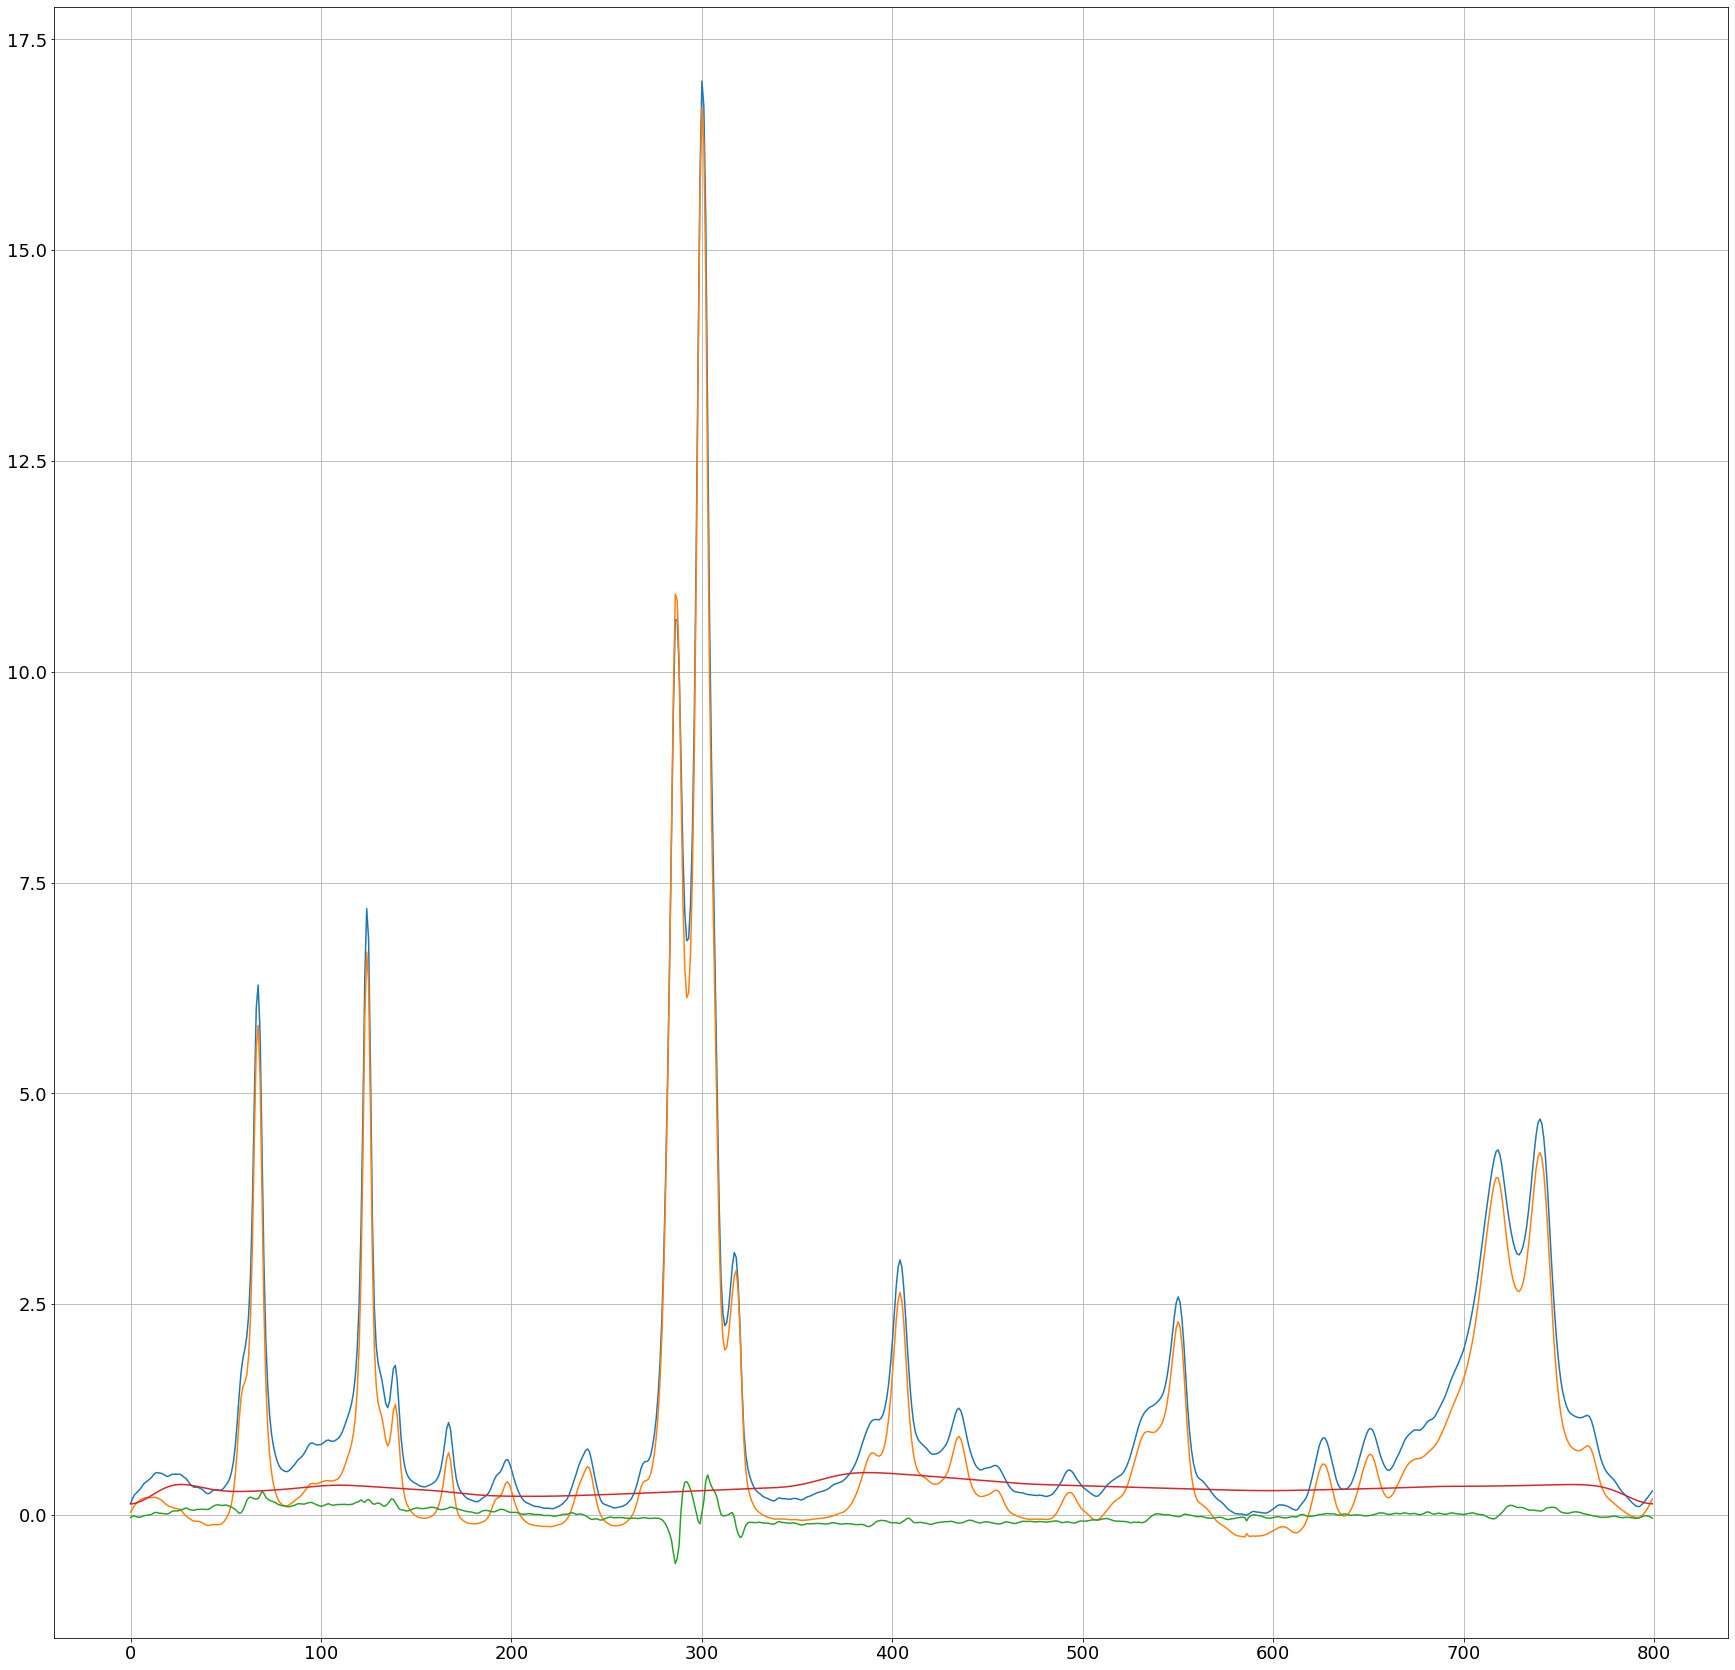

In [664]:
i, j = 4, 4
plt.plot(patterns[i][j])
plt.plot(fast_q[i][j])
plt.plot(fast_T[i, j])
plt.plot(background[i, j])
plt.grid()

In [746]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [744]:
def iterpeaks(fit_list):
    for d in fit_list:
        for k in d.keys():
            yield d[k]

In [745]:
list(iterpeaks(fitlists[5,5]))

[{'FWHM': 6.120572640130365,
  'area': -21.578731820744743,
  'area_err': 4.5254294826248265e-08,
  'x0': 67.78530114773908},
 {'FWHM': 7.4582722014691685,
  'area': -59.17516897408341,
  'area_err': 6.913535061797704e-08,
  'x0': 60.37835261774542},
 {'FWHM': 60.280927438286554,
  'area': 207.53692035572965,
  'area_err': 2.3041226743872837e-12,
  'x0': 32.633723289019514},
 {'FWHM': 82.74177446865095,
  'area': -40.80385366322069,
  'area_err': 4.530137783034315e-13,
  'x0': 69.91999999999999},
 {'FWHM': 5.60926061675679,
  'area': 55.005053546472254,
  'area_err': 7.465919936632063e-07,
  'x0': 124.88530456837154},
 {'FWHM': 6.683013034809456,
  'area': 13.1268966383153,
  'area_err': 6.170203884262558e-08,
  'x0': 139.27208454421532},
 {'FWHM': 45.80812525415777,
  'area': 2.0015281282703077,
  'area_err': 3.3191605664641686e-10,
  'x0': 96.00000678024735},
 {'FWHM': 42.4373246188905,
  'area': 13.565021940824524,
  'area_err': 3.2811774407705396e-08,
  'x0': 109.03560434211923},
 

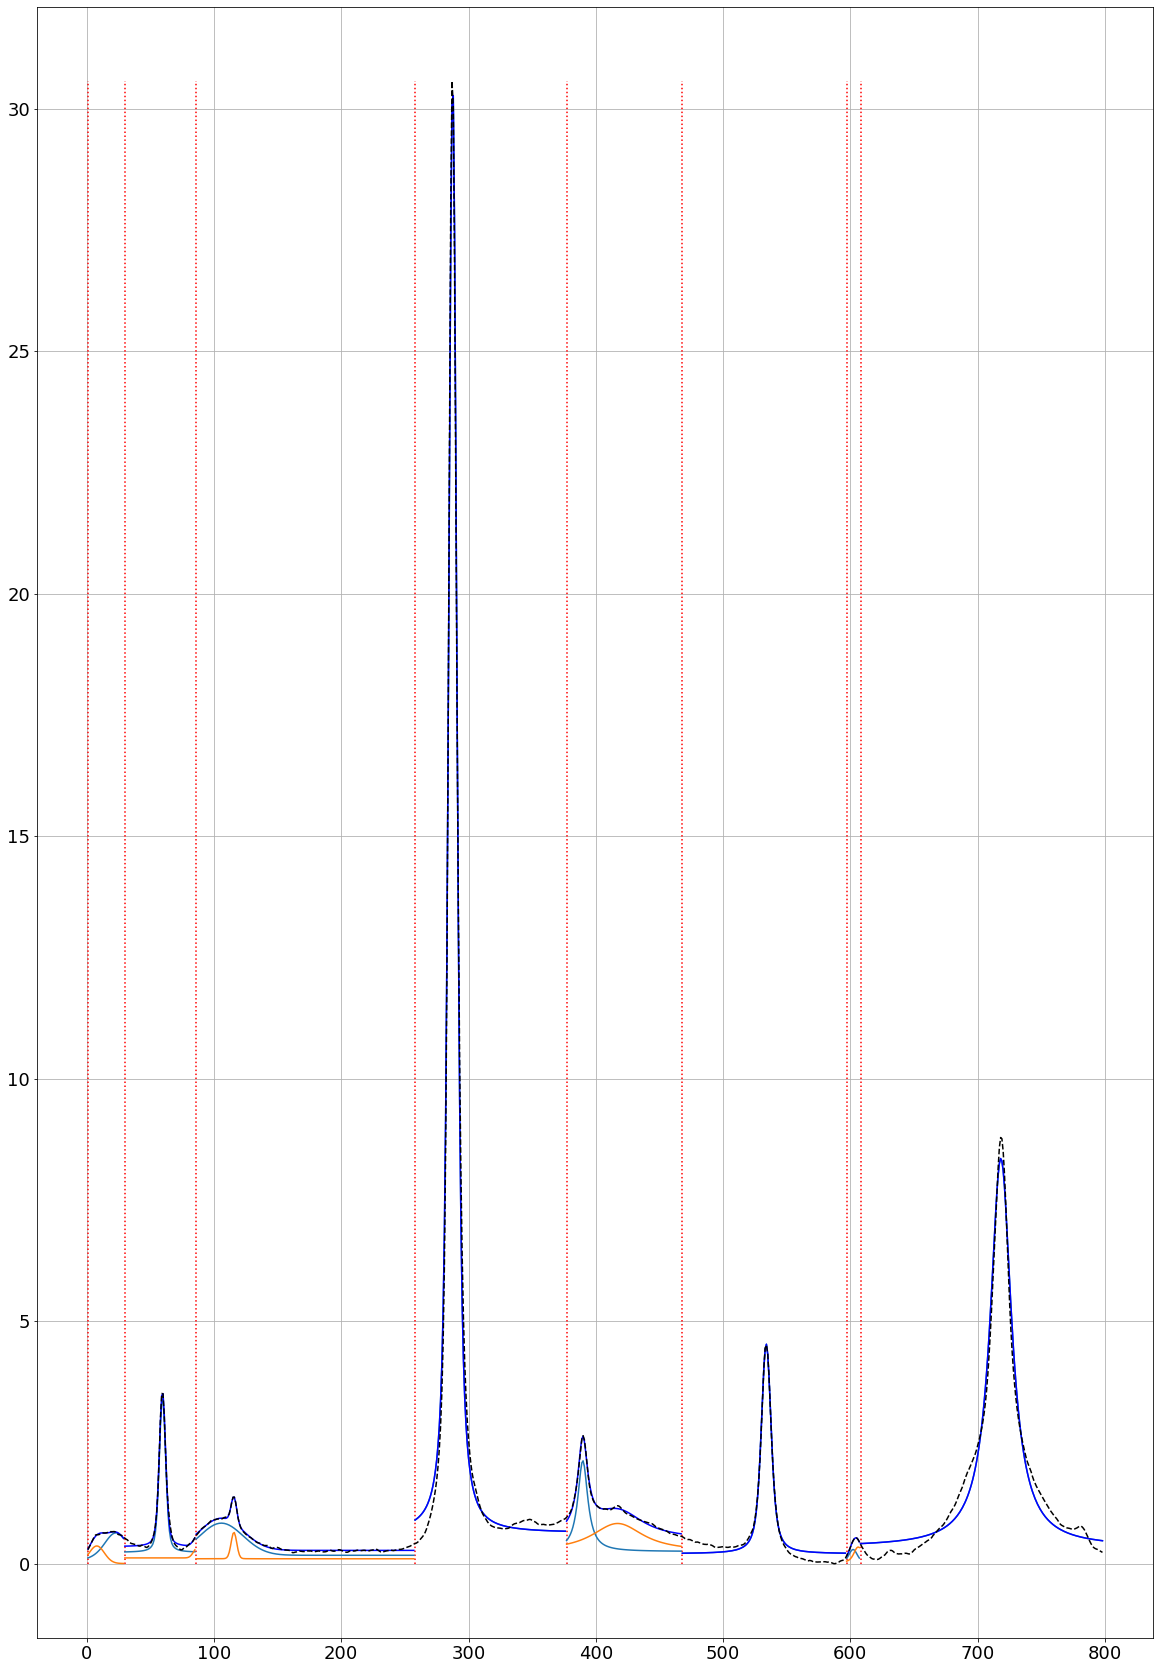

In [1278]:
plotting.plot_all_fits([elt[j] for elt in fsub_stop_2d], i);

In [1455]:
fitlists = fsub_stop_2d[1]

#path = "../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/"

from data_grid import DataGrid

dgrid = d3d.dgrid

q = dgrid.data[1][:,0]
X = dgrid.get_data_array()
X /= X.sum(axis = 1)[:, None]

coords = get_coords(dgrid)   

ridges = feat.get_ridges(feat.preprocess(fast_q, smooth_ax1= .8, threshold_percentile = 50)[0], axis = 2,
                        fitlists = fitlists, peakwidth = 1)

# arr, labeled = feat.refine_and_label(ridges, sizetype = 'count', size_thresh=50,
#                                     thicken_ax1=0)
# feature_masks = np.array([labeled == i for i in range(1, labeled.max() + 1)])

labeled, feature_masks, activations, _norm, activations_n1 = peakfit_featurize(patterns, fitlists,
                            thicken_ax0 = 0, size_thresh = 25,
                            area_min = 5, thicken_ax1 = 0)

mask = (patterns.sum(axis = 2) != 0)
# fast_q_flat = fast_q[mask]

(177, 800)
using fitlists
using fitlists
3
26
0.6746053314308316


In [1077]:
# peak_slices = [feat.color_peaks_2d(fitlists[i, :], patterns[i], fwhm_max = 80, imin = 0,
#                                   peakwidth = 'auto')
#               for i in range(patterns.shape[0])]

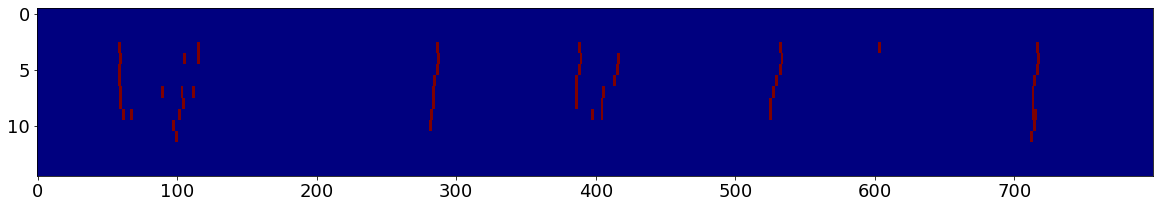

In [1078]:
i = 13
plt.imshow(feature_masks.sum(axis = 0)[:, i, :], aspect = 8, interpolation = 'none', cmap = 'jet')

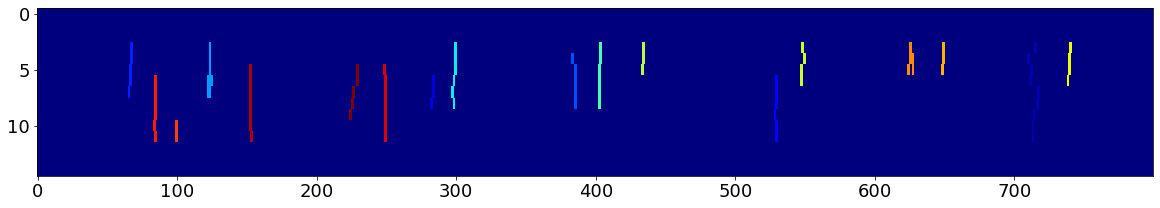

In [1079]:
plt.imshow(labeled[i, :, :], aspect = 8, interpolation = 'none', cmap = 'jet')

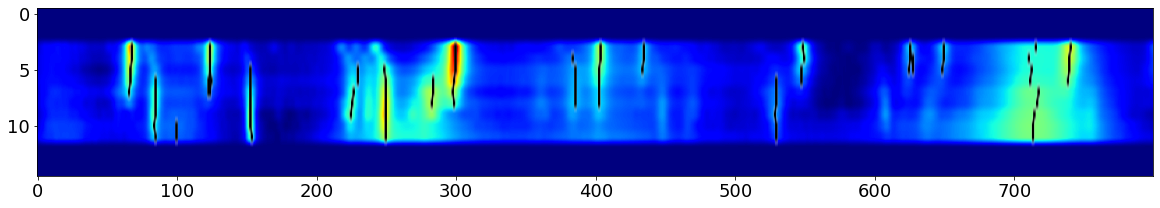

In [1080]:
overlay_mask(patterns[i], labeled[i], aspect = 8)

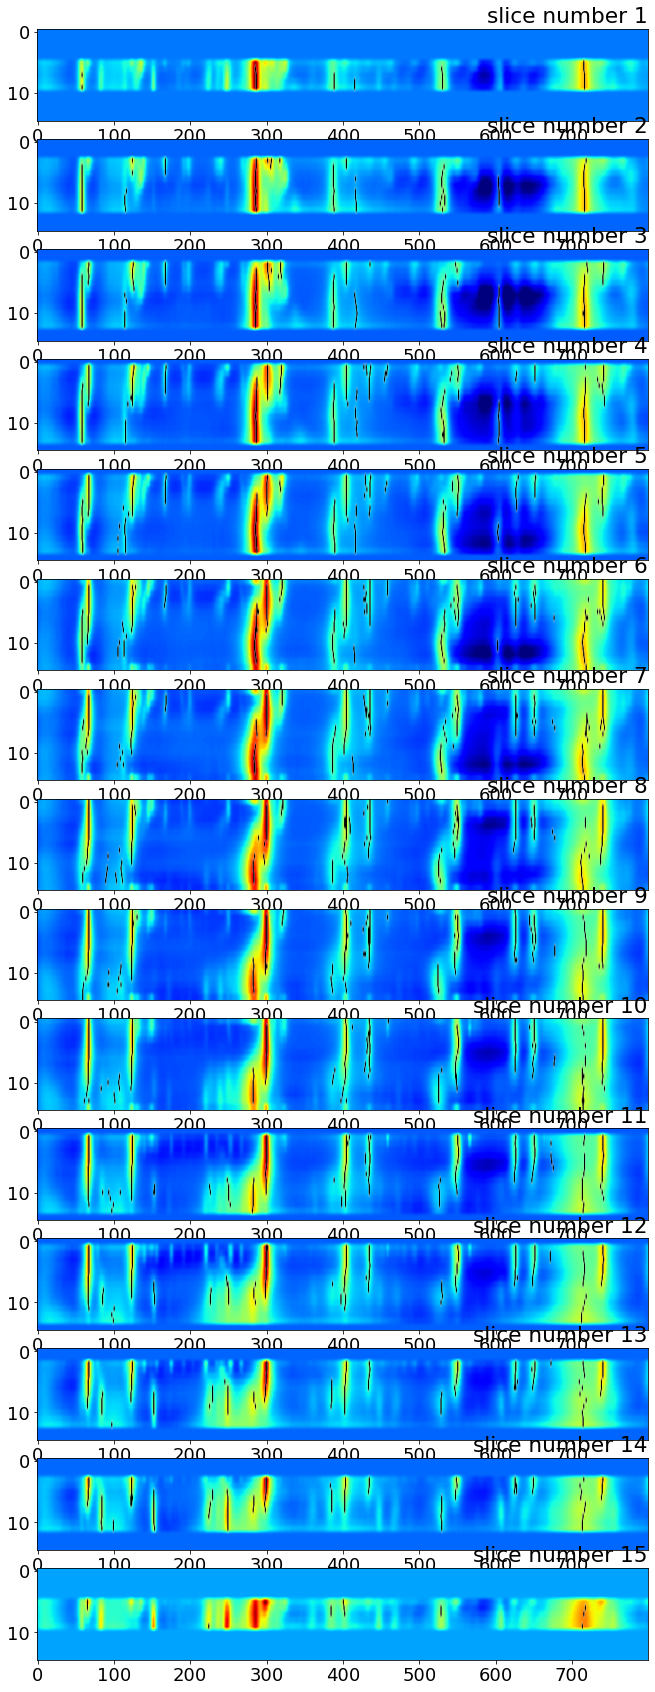

In [1081]:
plot_slices(overlay_mask, fast_q * mask[..., None], labeled * mask[..., None],
            aspect = 8, vmin = -1)#, vmax = np.log10(1 + fast_q.max()))

In [288]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [1069]:
def consolidate_feature_maps(feature_masks, thicken_ax1 = 1):
    """
    """
    feat_coords = (feature_masks * np.arange(patterns.shape[-1]))

    feat_coord_sums = np.einsum('ijkl,l->ijk', feature_masks, np.arange(patterns.shape[-1]))

    feat_coord_counts = np.einsum('ijkl,l->ijk', feature_masks, np.ones(patterns.shape[-1]))

    feat_coord_median = np.nan_to_num(feat_coord_sums / feat_coord_counts, 0)

    new_feat_masks = np.zeros_like(feature_masks)

    la, lb, lc, ld = new_feat_masks.shape
    ia, ib, ic, _ = np.ix_(np.arange(la), np.arange(lb), np.arange(lc), np.arange(ld))
    target_shape = np.broadcast_arrays(ia, ib, ic)[-1].shape
    iid = feat_coord_median.astype(int).reshape(target_shape)

    new_feat_masks[ia, ib, ic, iid] = 1
    
    new_ridges = new_feat_masks.astype(int).sum(axis = 0)
    new_labeled, _ = feat.label_peakregions(new_ridges)
    return feat.shuffle(new_feat_masks, 0, thicken_ax1), feat.shuffle(new_labeled, 0, thicken_ax1)

In [681]:
feature_masks.shape

(41, 15, 15, 800)

In [1280]:
feature_masks, labeled = consolidate_feature_maps(feature_masks, thicken_ax1= 1)

# peakfit_featurize doesn't calculate activations correctly for 3d arrays,
# so do it manually here
# TODO
axis = 3
#activations = (feature_masks * fast_q).sum(axis = axis) # TODO
#activations = (feature_masks * (fast_q * (fast_q > 0))).sum(axis = axis)
activations = (feature_masks * patterns).sum(axis = axis)

scale = np.mean(activations, axis = (1, 2))
activations_n1 = feat.norm3d(activations)

#straightened_heatmap = feat.get_peakshift_corrected_heatmap(patterns, activations_n1, labeled)

3
3
3
3
3
3
0.4124283482957283


<ipython-input-1069-7e52983bbf1f>:10: RuntimeWarning: invalid value encountered in true_divide
  feat_coord_median = np.nan_to_num(feat_coord_sums / feat_coord_counts, 0)


In [1348]:
# moved to feats_3d.y
# def get_activations(patterns_pp, feature_masks, axis = 3,
#                    thicken_ax0 = 0, size_thresh = 25,
#                             area_min = 5, thicken_ax1 = 0):
# #     #patterns_pp = patterns_pp * (patterns_pp > 0)
# #     labeled, feature_masks, activations, _norm, activations_n1 = peakfit_featurize(patterns_pp, fitlists,
# #                                                                 thicken_ax0 = thicken_ax0,
# #                                                                 size_thresh = size_thresh,
# #                                                                 area_min = area_min,
# #                                                                 thicken_ax1 = thicken_ax1)

# #     mask = (patterns_pp.sum(axis = 2) != 0)
# #     feature_masks, labeled = consolidate_feature_maps(feature_masks)

# #     #activations = (feature_masks * (patterns_pp * (patterns_pp > 0))).sum(axis = axis)
#     activations = (feature_masks * patterns_pp).sum(axis = axis)
#     #scale = np.log(1 + np.mean(activations, axis = (1, 2)))
#     scale = np.mean(activations, axis = (1, 2))
#     activations_n1 = feat.norm3d(activations)
#     return activations / scale[:, None, None] #activations_n1

In [390]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [683]:
# # peakfit_featurize doesn't calculate activations correctly for 3d arrays,
# # so do it manually here
# # TODO
# axis = 3
# #activations = (feature_masks * fast_q).sum(axis = axis)
# activations = (feature_masks * (fast_q * (fast_q > 0))).sum(axis = axis)
# #activations = (feature_masks * patterns).sum(axis = axis)

# scale = np.mean(activations, axis = (1, 2))
# activations_n1 = feat.norm3d(activations)

0.017361286056697414


In [778]:
plt.rcParams["figure.figsize"]=(20, 30
                               )

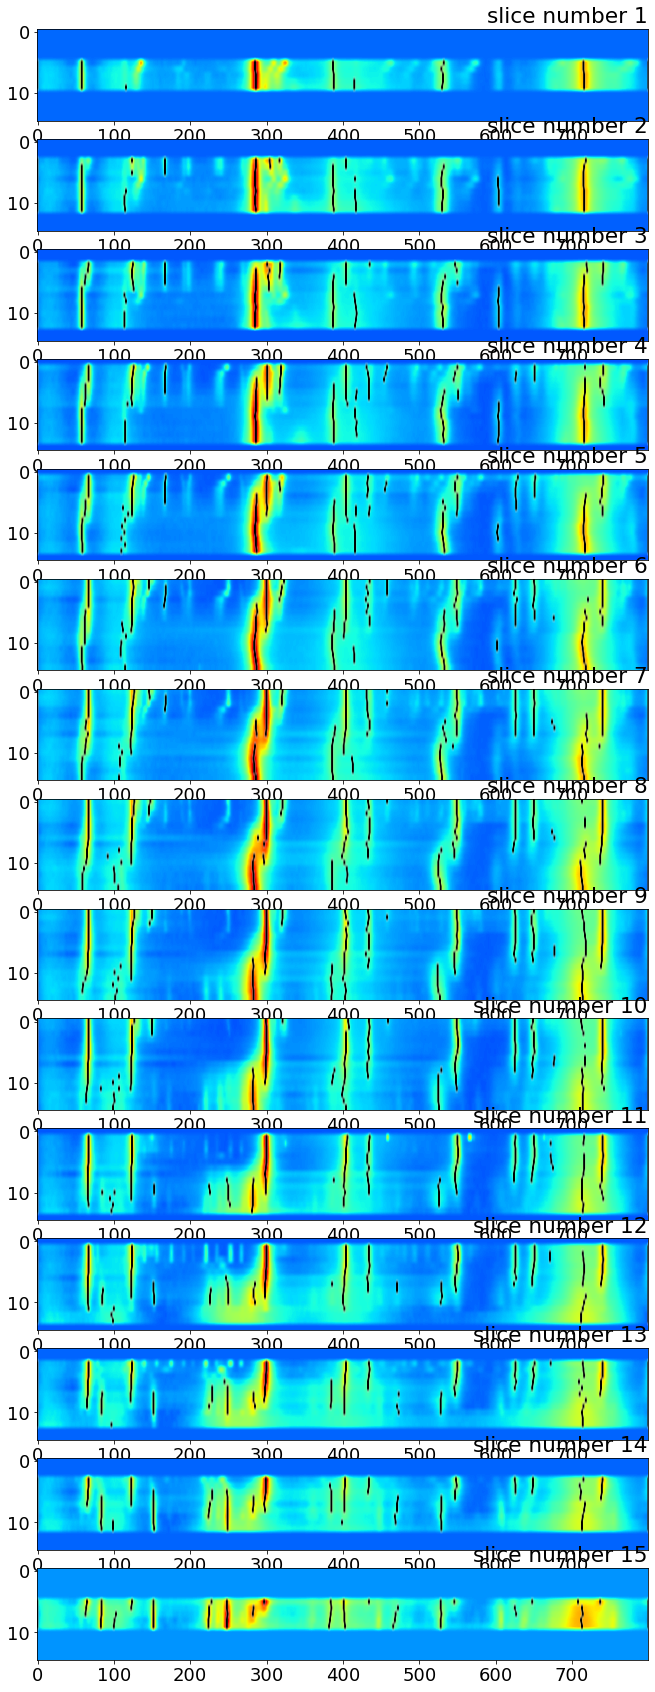

In [1284]:
plot_slices(overlay_mask, patterns * mask[..., None], labeled * mask[..., None],
            aspect = 8, vmin = -1)#, vmax = np.log10(1 + fast_q.max()))

In [515]:
def plt_slices_T(fn, *args, **kwargs):
    argsnew = []
    for a in args:
        argsnew.append(np.swapaxes(a, 0, 1))
    return plot_slices(fn, *args, **kwargs)

In [517]:
fast_q.shape

(15, 15, 800)

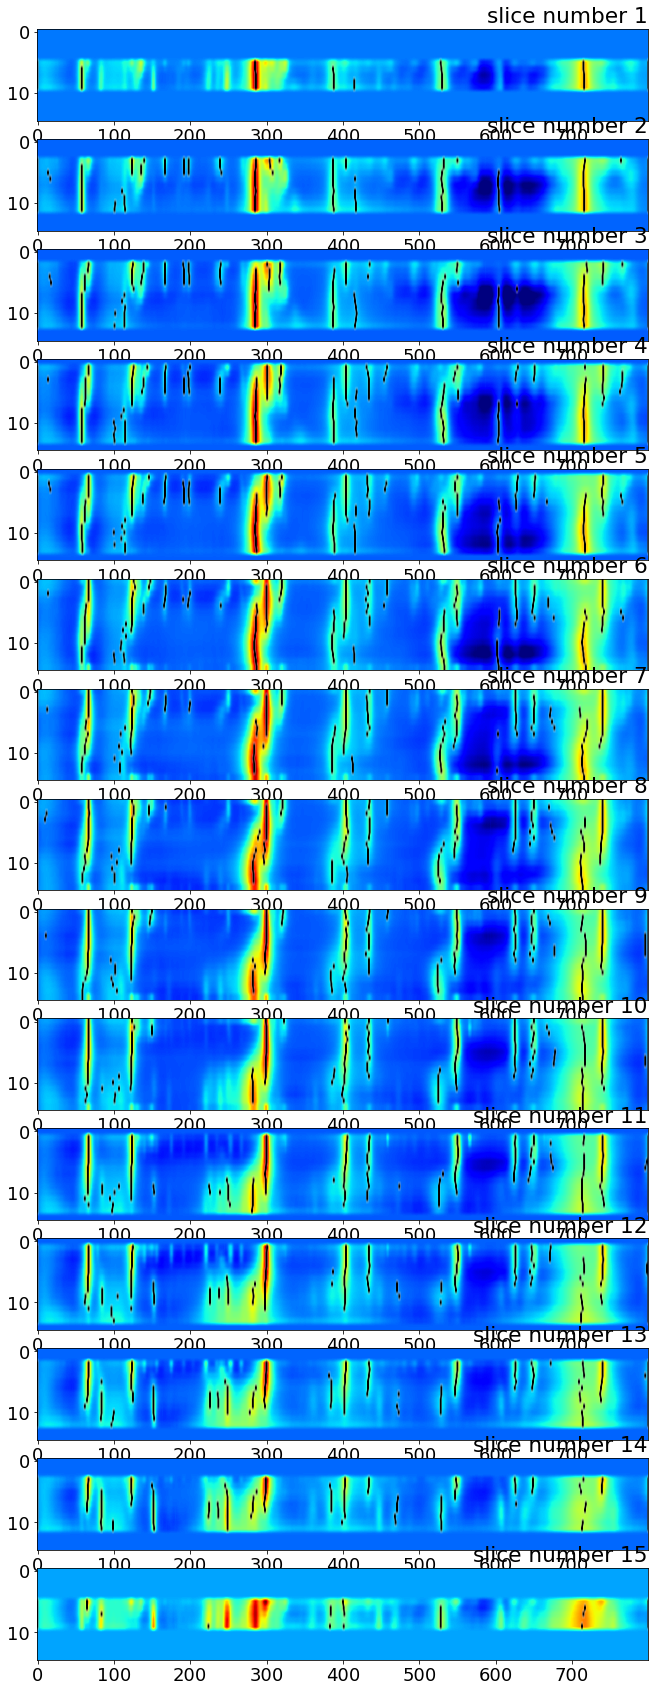

In [1016]:
plt_slices_T(overlay_mask, fast_q * mask[..., None], labeled * mask[..., None],
            aspect = 8, vmin = -1)#, vmax = np.log10(1 + fast_q.max()))

In [393]:
reload(vis)

<module 'xrdc.visualization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/visualization.py'>

In [ ]:
i = 5

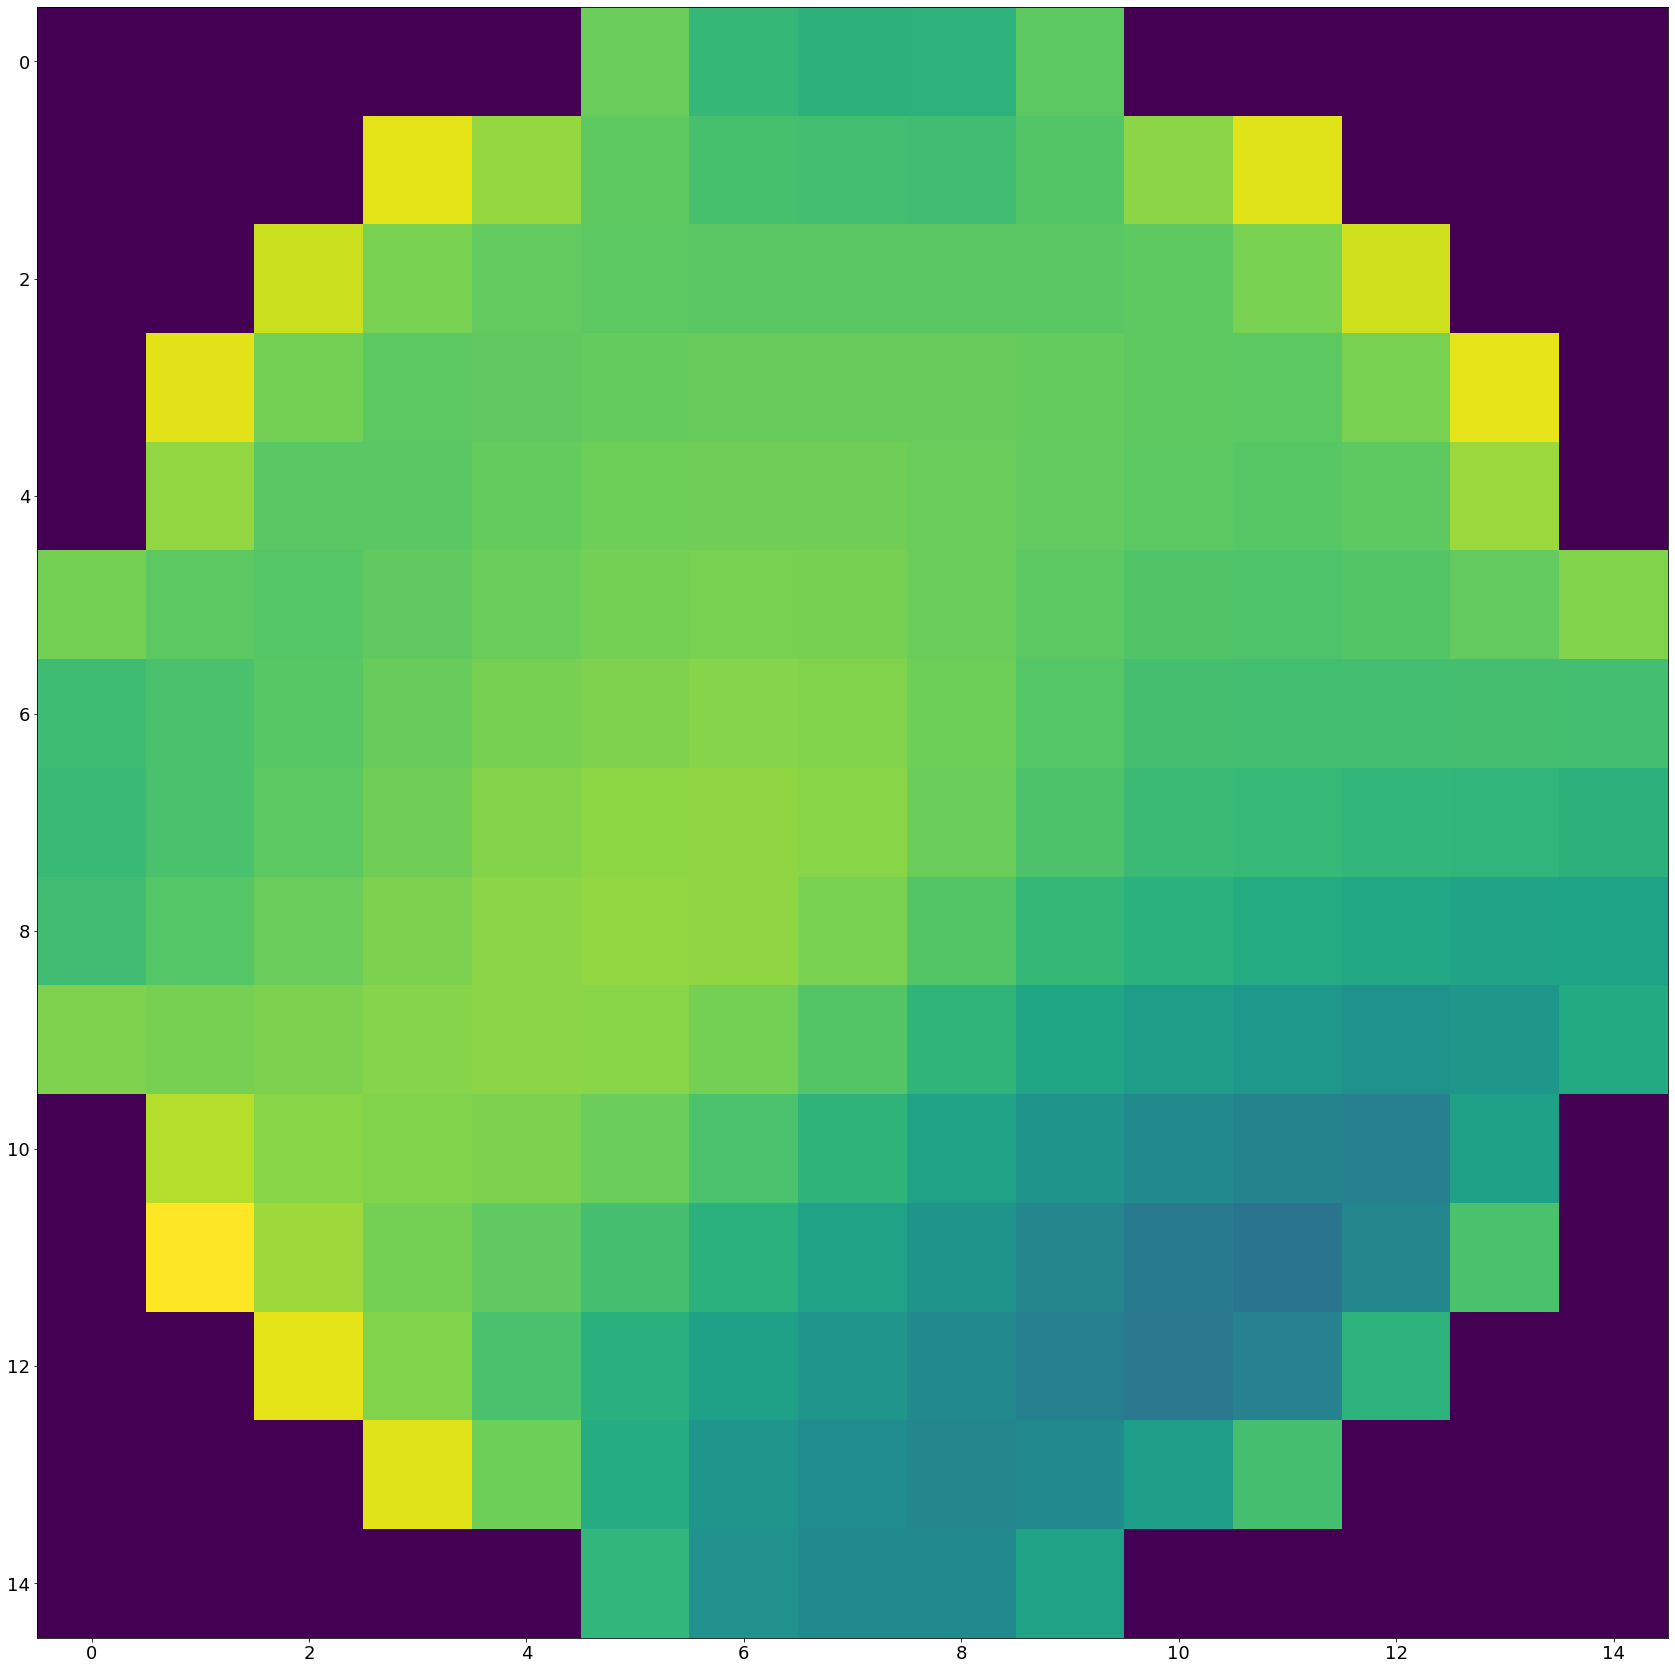

In [409]:
plt.imshow(
    (fast_q * (fast_q > 0)).sum(axis = 2))

In [426]:
activations[:1, :, :].sum(axis = 0) > 0

array([[False, False, False, False, False,  True,  True,  True,  True,
         True, False, False, False, False, False],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True, False, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False],
       [ True,  True,  T

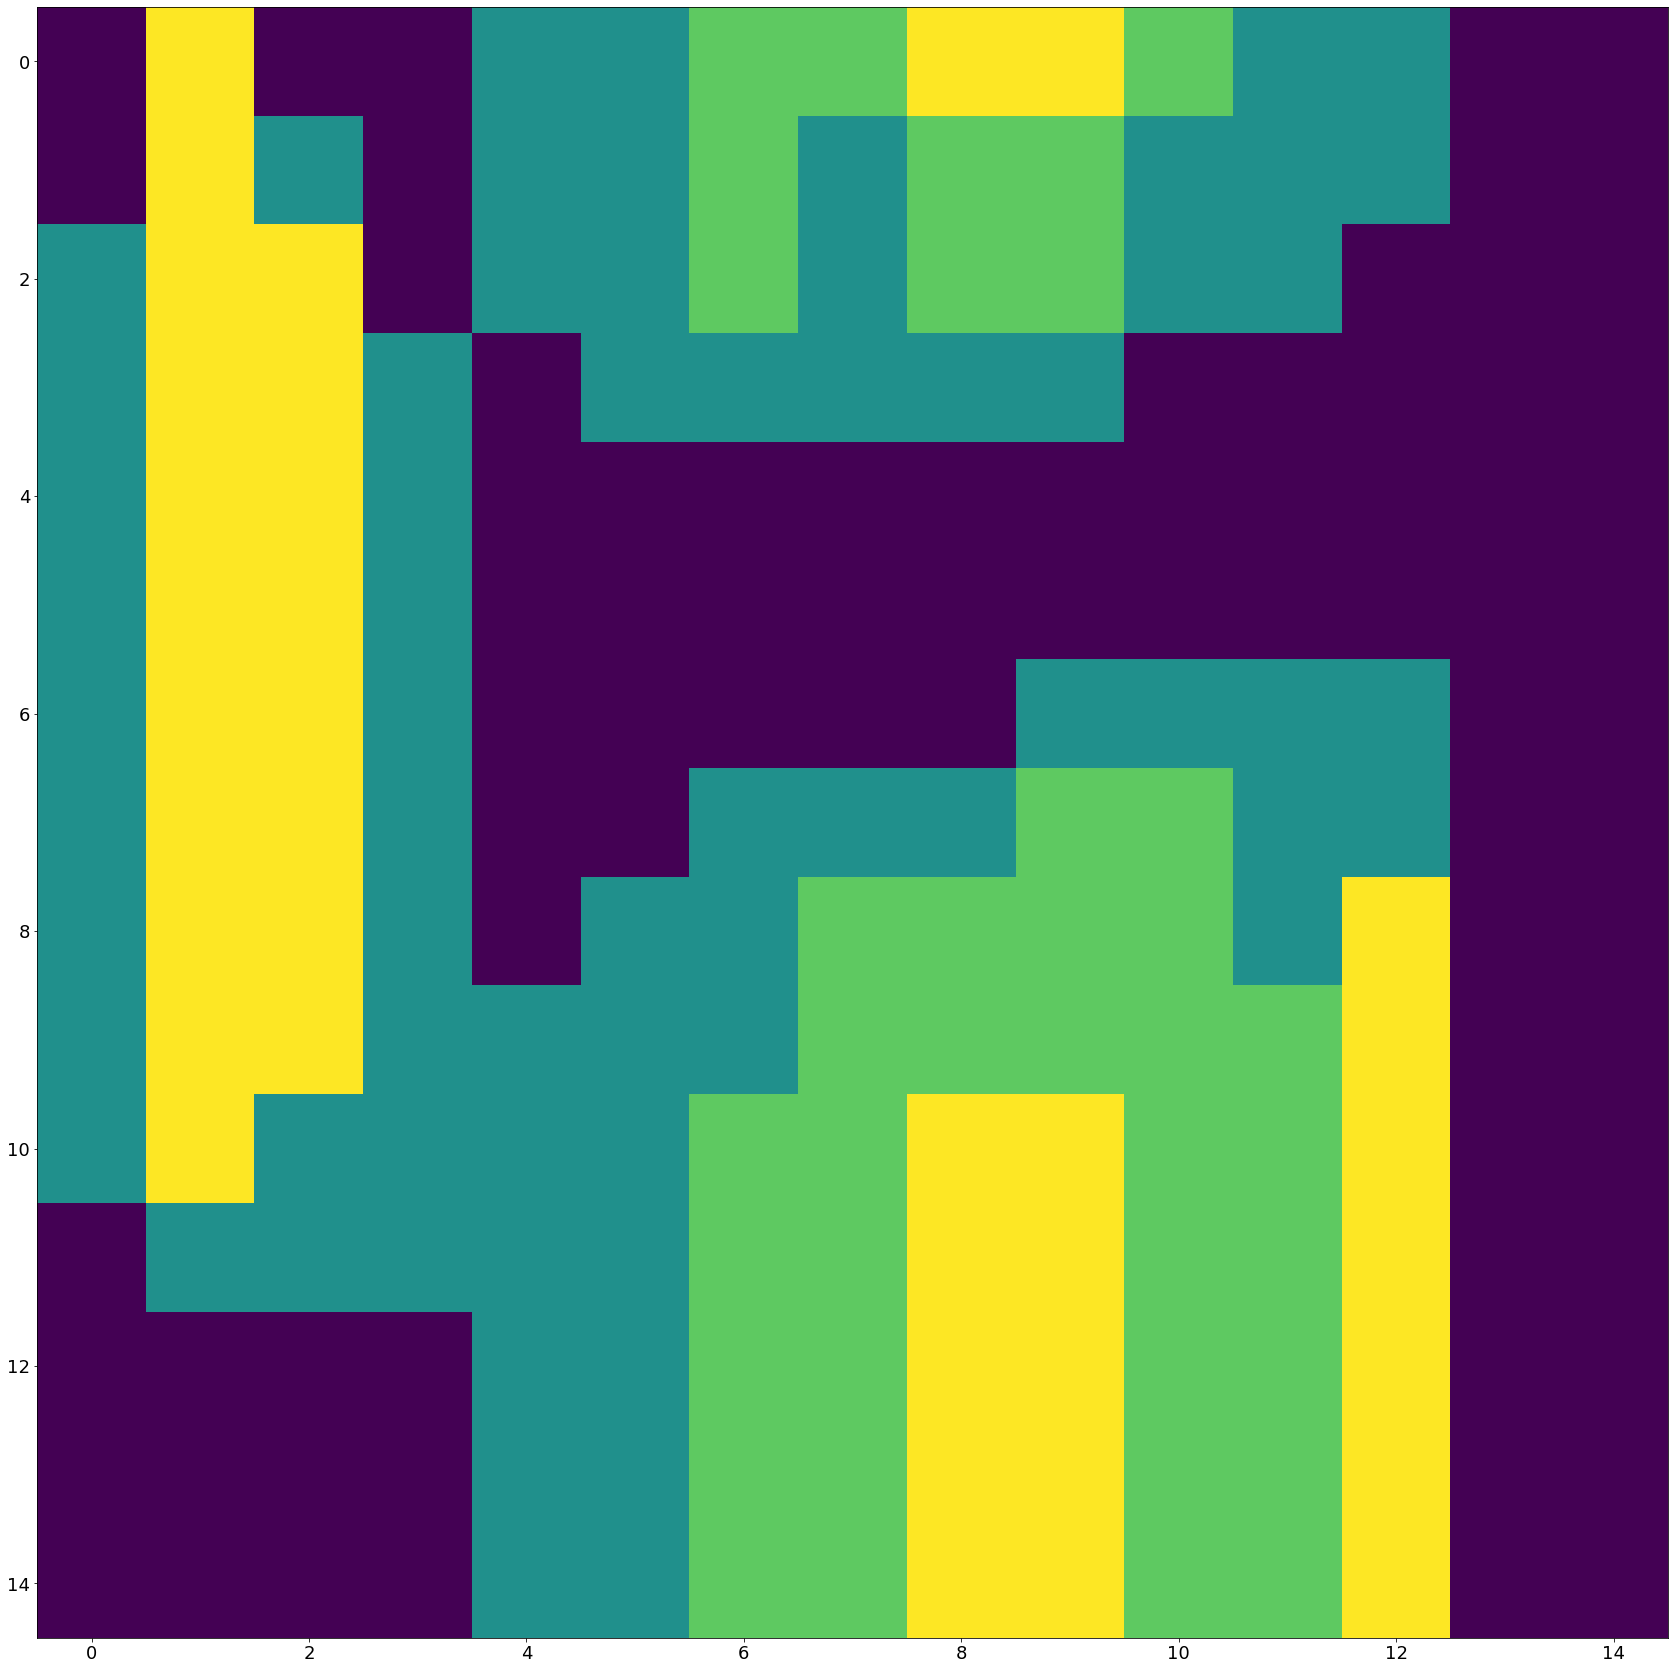

In [476]:
plt.imshow((feature_masks[5, ...].sum(axis = 2)))

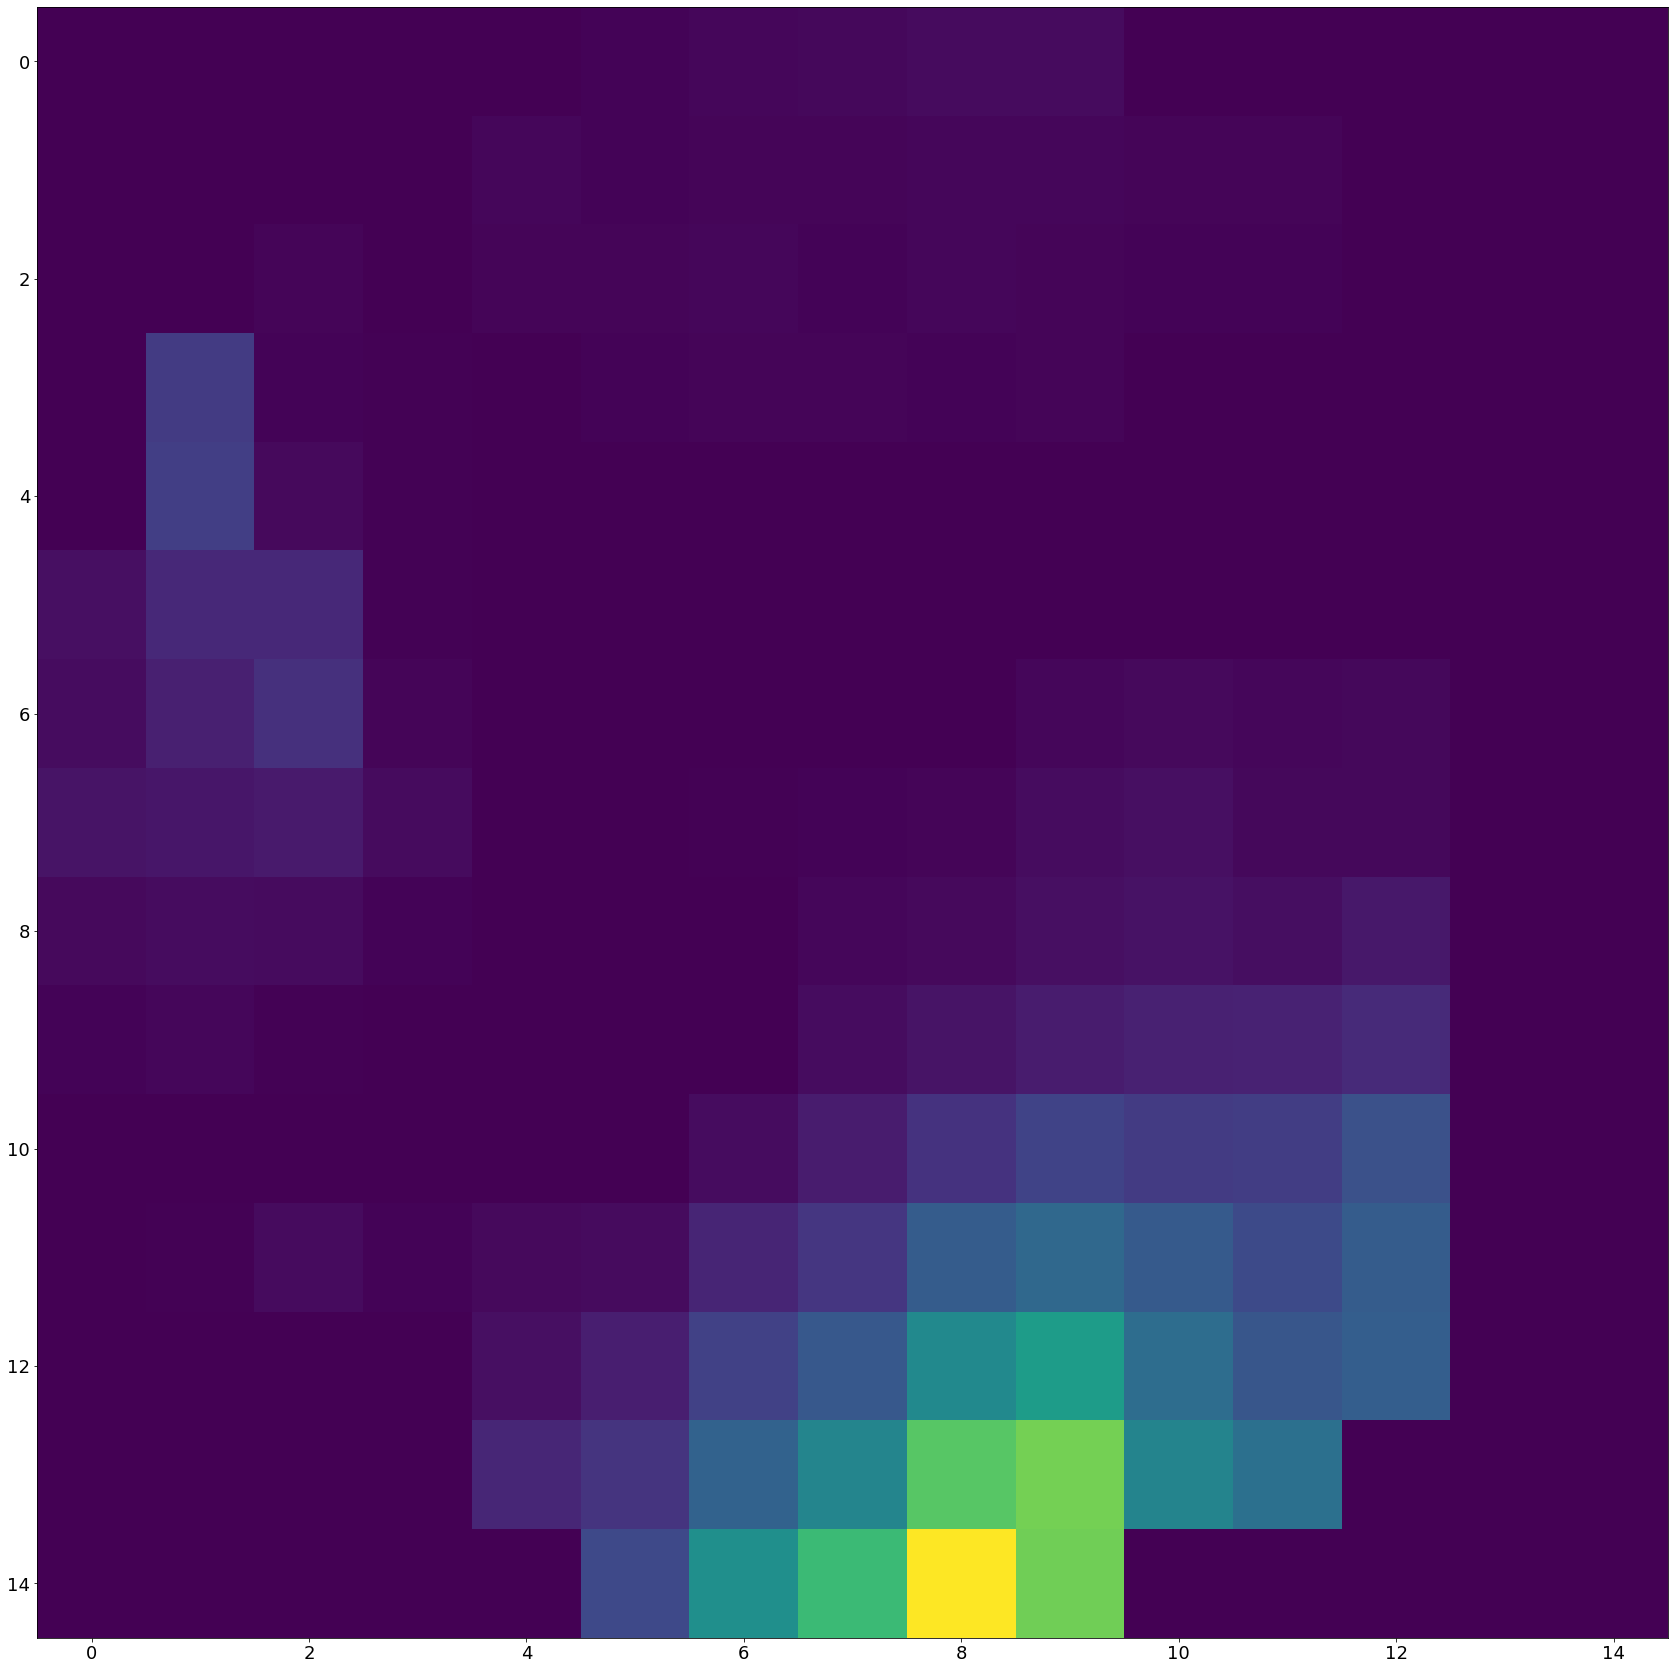

In [479]:
plt.imshow((activations_n1[5, :, :] ))

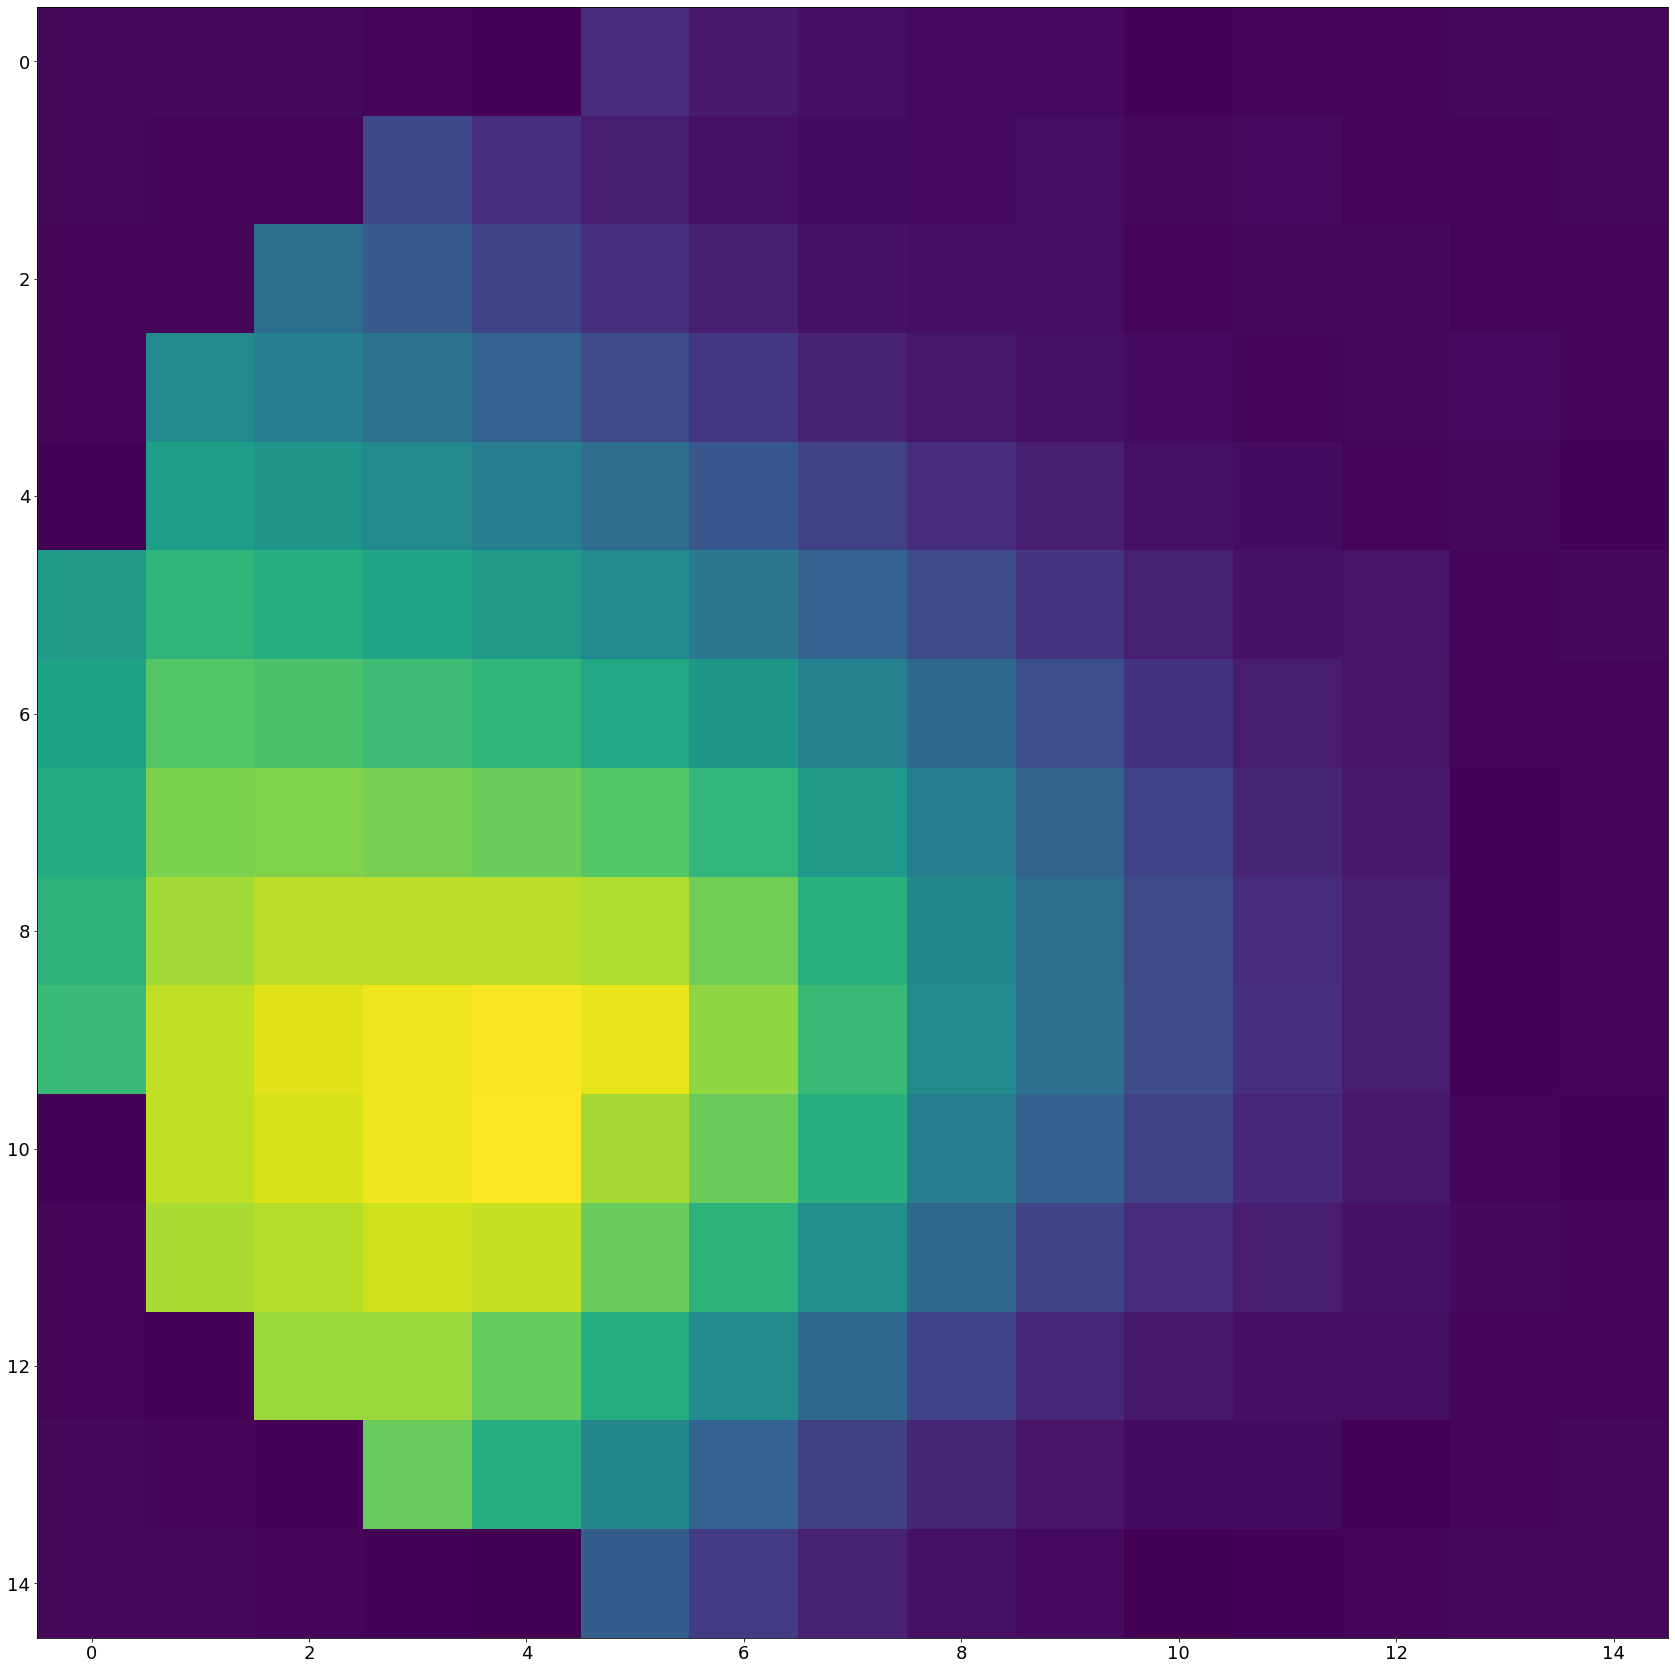

In [417]:
# plt.imshow(
#     np.swapaxes(activations_n1[:1, :, :], 0, 2).sum(axis = 2))

plt.imshow(np.swapaxes(
    np.swapaxes(activations_n1[:1, :, :], 0, 2), 
        0, 1).sum(axis = 2))

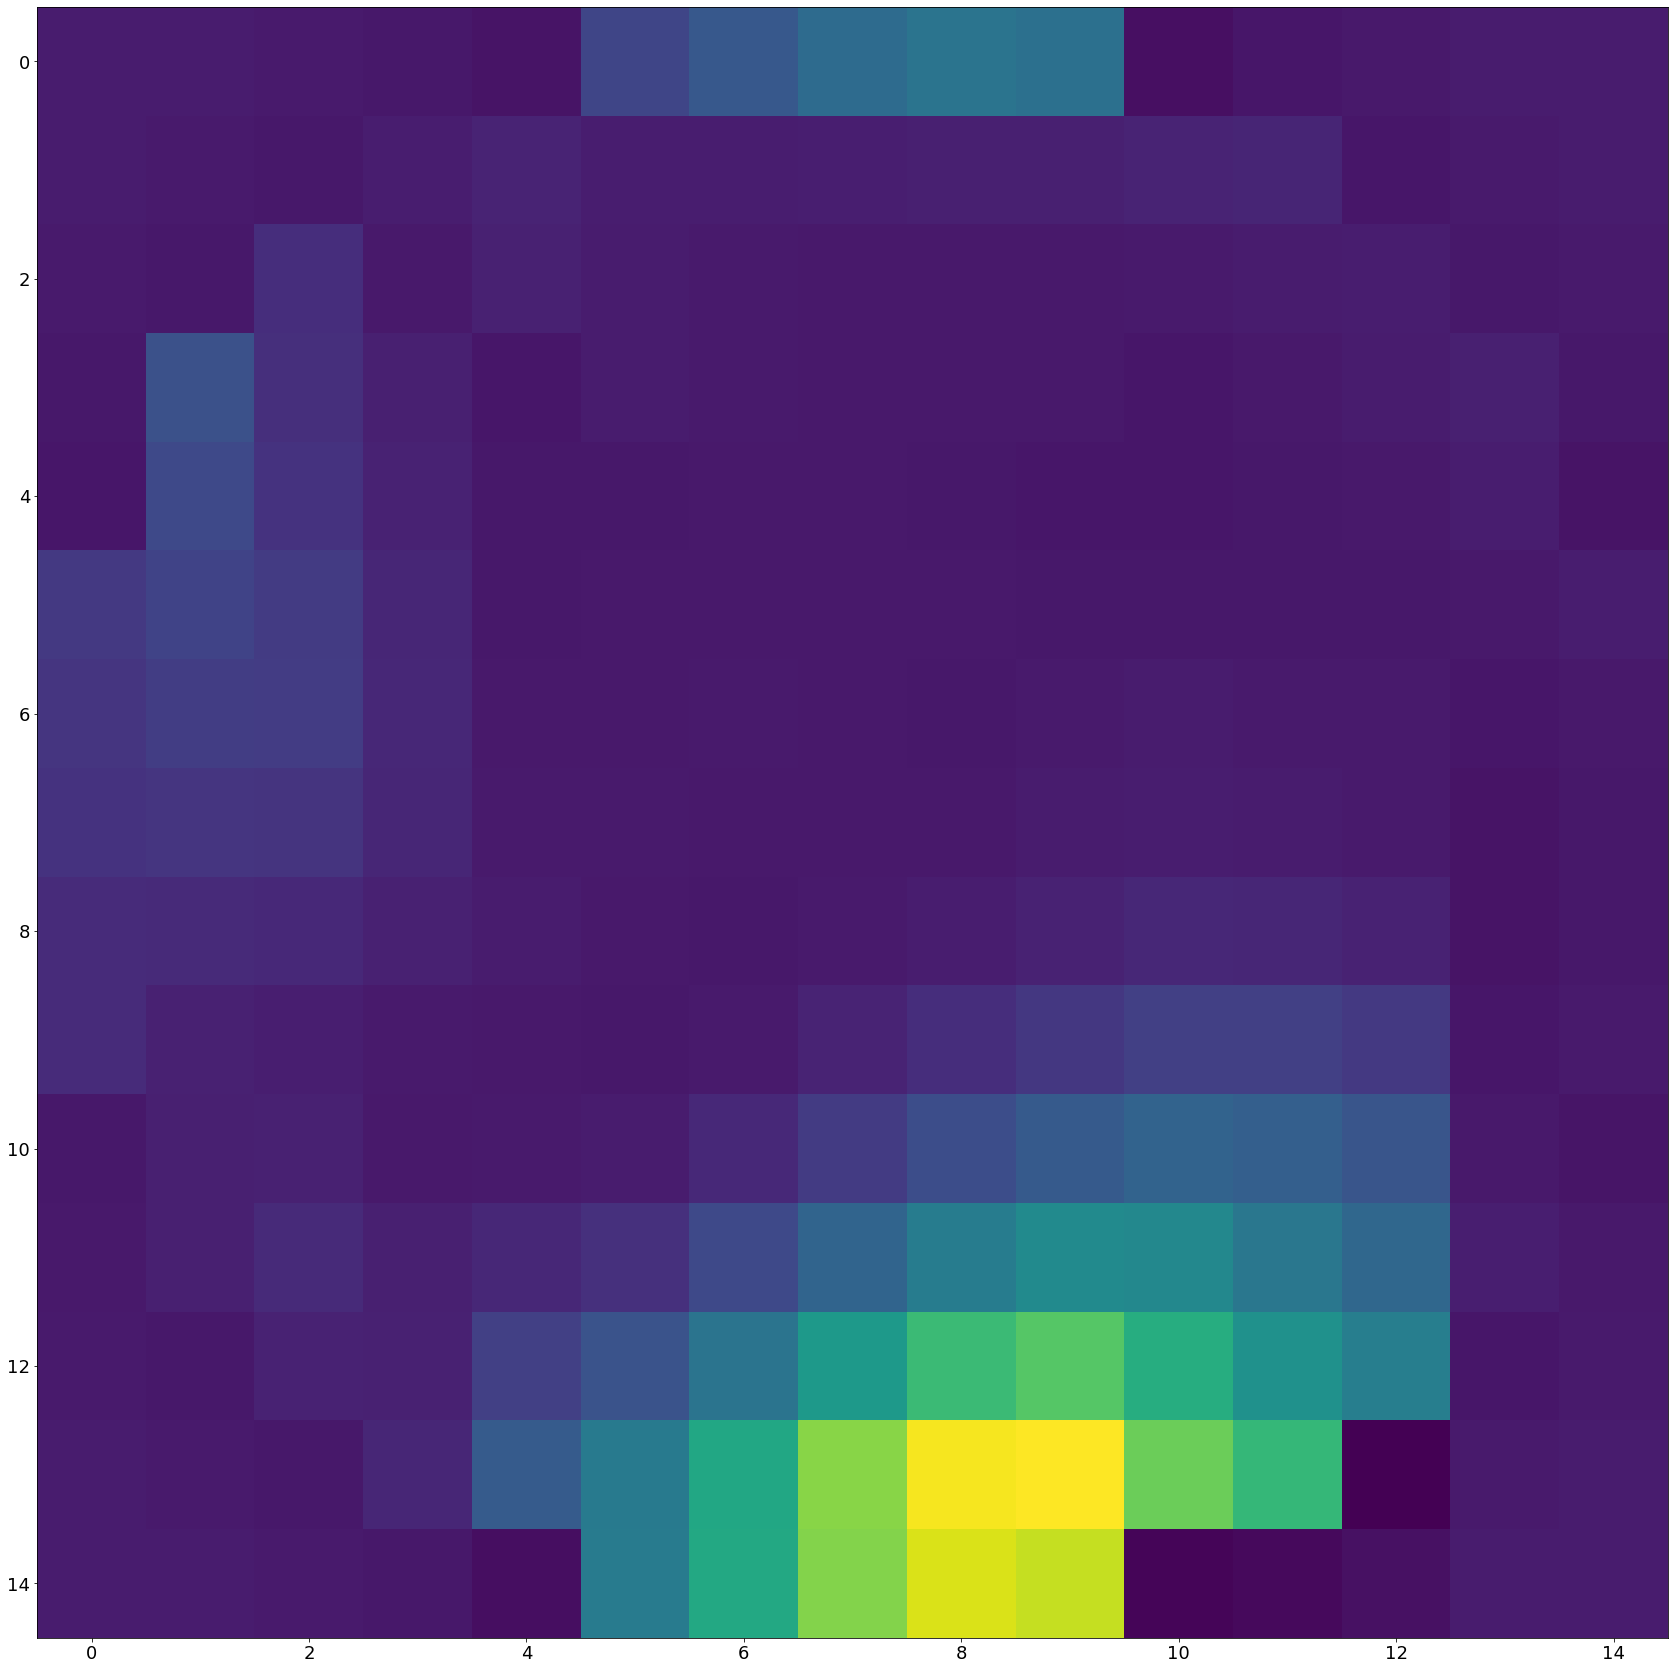

In [484]:
plt.imshow(np.swapaxes(
    np.swapaxes(activations_n1[5:6, ...], 0, 2), 
        0, 1).sum(axis = 2))

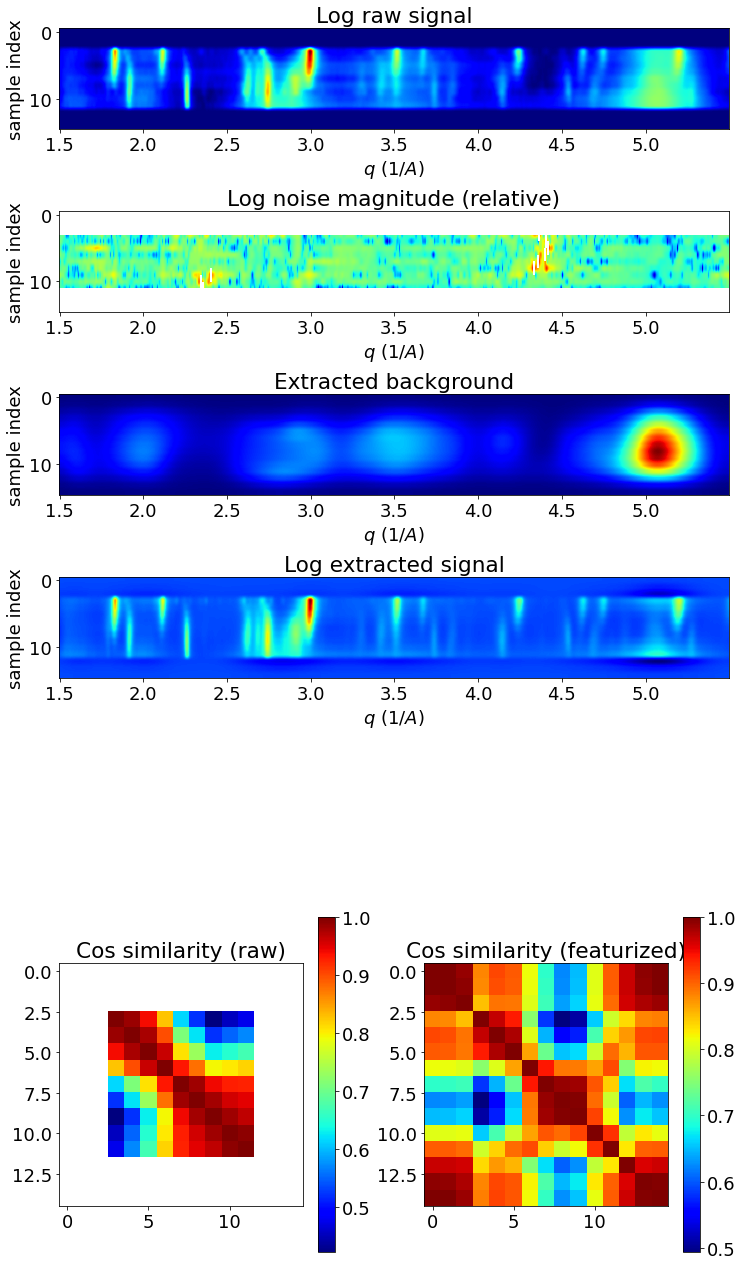

In [511]:
i = 13
vis.plot_summary(patterns[i], background[i], fast_q[i], slow_T[i], fast_T[i],
        np.swapaxes(
            np.swapaxes(activations_n1, 0, 2), 
                0, 1)[i].T
        )

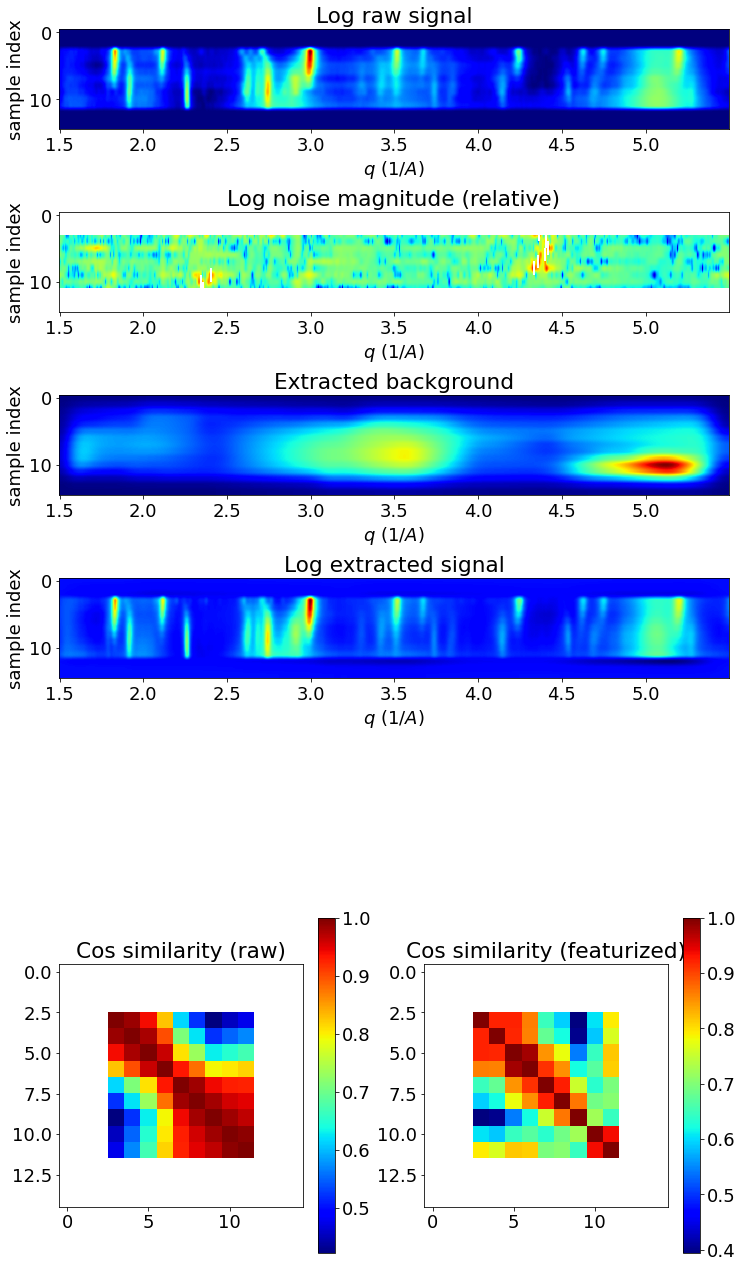

In [845]:
i = 13
vis.plot_summary(patterns[i], background[i], fast_q[i], slow_T[i], fast_T[i],
        np.swapaxes(
            np.swapaxes(activations_n1, 0, 2), 
                0, 1)[i].T,
                 similarity = 'cos'
            )

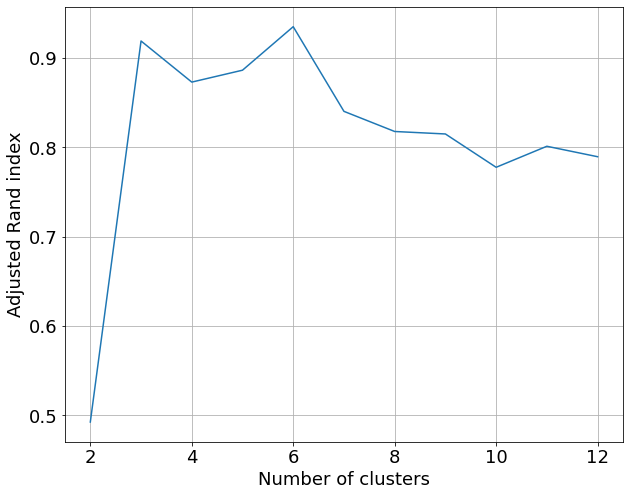

In [1441]:
data_samples = mc.sample(patterns, fast_T, N = 100)

X_samples = np.array([transpose_x_3d(get_activations(sample, feature_masks))
                      for sample in data_samples]);

nclusts = np.arange(2, 20)
amis = [mean_ami(patterns, X_samples[:20], n) for n in nclusts]

#plt.plot(nclusts[1:12], amis[1:12])
plt.plot(nclusts[1:12], rands[1:12])
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Rand index')
plt.grid()

In [529]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [538]:
from xrdc.datasets import d3d

y = d3d.y

from xrdc import montecarlo as mc
reload(mc)

In [1431]:
def do_pair_ami(nclust, patterns, X1, X2, linkage = 'ward', fn = ami):
    act1, act2 = transpose_x_3d_inv(X1), transpose_x_3d_inv(X2)
    clust1, sorter, clust_cms = feat.do_clust(patterns[mask], act1[:, mask], nclust, ctype = 'agglom', linkage=linkage,
                                            affinity='euclidean')
    clust2, sorter, clust_cms = feat.do_clust(patterns[mask], act2[:, mask], nclust, ctype = 'agglom', linkage=linkage,
                                            affinity='euclidean')
    return fn(clust1, clust2)
    #, rand(y, clust)

In [1282]:
X_samples[ii].shape

(15, 15, 25)

In [1433]:
def mean_ami(patterns, samples, nclust, fn = ami):
    res = []
    for i in range(len(samples)):
        for j in range(len(samples)):
            if i != j:
                res.append(do_pair_ami(nclust, patterns, samples[i], samples[j], fn = fn))
    return np.mean(res)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 14 but corresponding boolean dimension is 15

In [1434]:
rands = [mean_ami(patterns, X_samples[:20], n, rand) for n in nclusts]

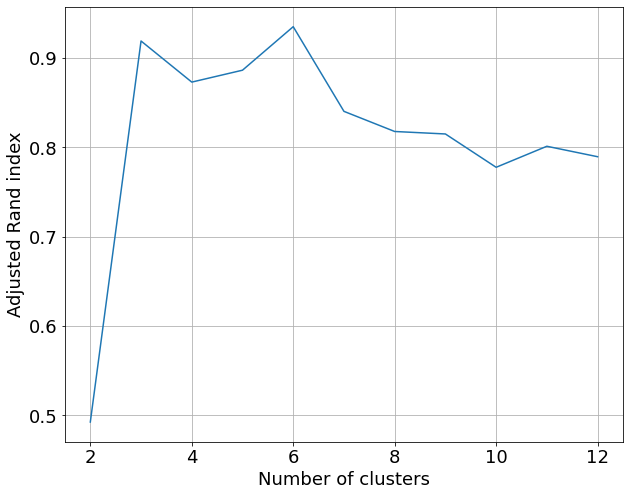

In [1440]:
#plt.plot(nclusts[1:12], amis[1:12])
plt.plot(nclusts[1:12], rands[1:12])
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Rand index')
plt.grid()

In [1410]:
mean_ami(patterns, X_samples[:20], 3)

0.89812682591728

In [1380]:
pair_amis = [do_pair_ami(3, patterns, X1, X2) for X1 in X_samples[:20] for X2 in X_samples[:20]]

In [1381]:
len(pair_amis)

400

In [1382]:
np.mean(pair_amis)

0.9032204846214161

In [1202]:
do_clust(2, patterns, transpose_x_3d_inv(X_samples[ii]), transpose_x_3d_inv(X_samples[ii + 1]))

0.7070025667698345

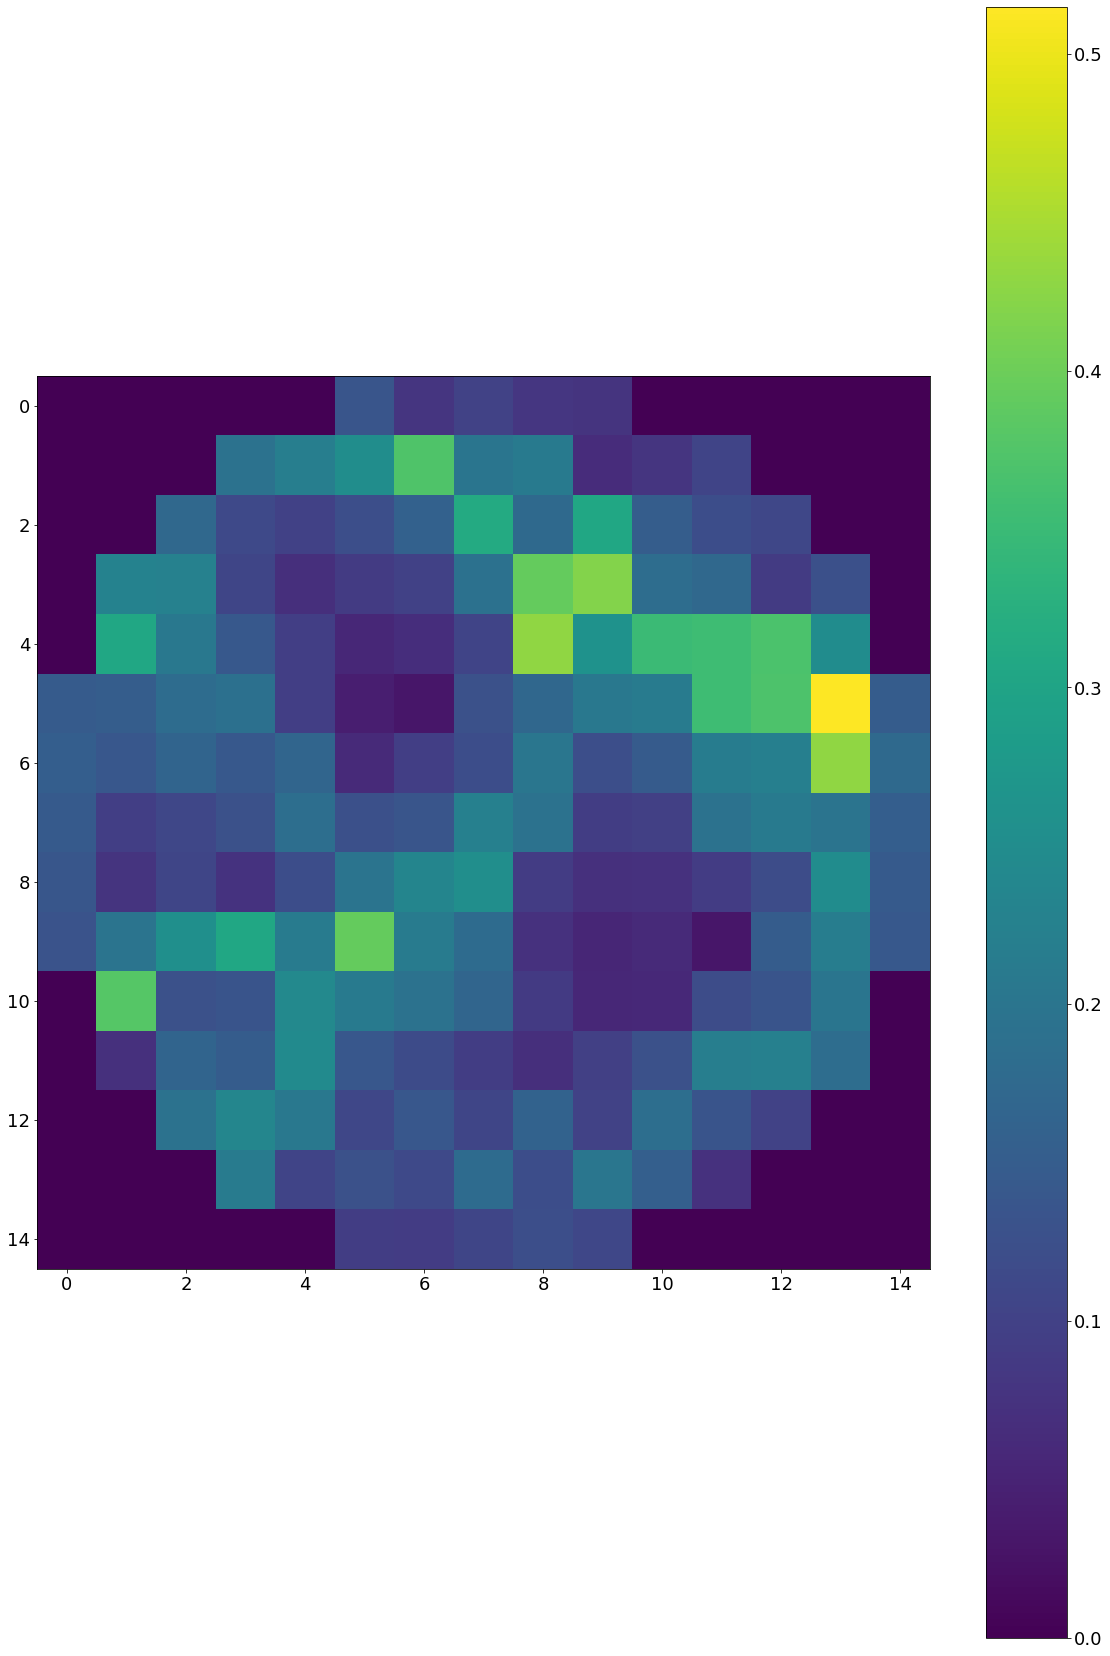

In [1276]:
plt.imshow(fast_T.std(axis = 2))
plt.colorbar()

In [1261]:
mask2 = mask.copy()
mask2[:, 0] = False
mask2[:, -1] = False
mask2[0, :] = False
mask2[-1, :] = False

In [1452]:
data_samples[ii].shape

(15, 15, 800)

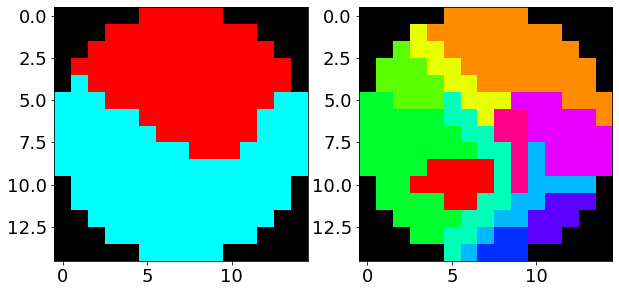

In [1450]:
nclust = 2
def cmp_clust(nclust, patterns, activations_n1, mask):
    clust, sorter, clust_cms = feat.do_clust(patterns[mask], activations_n1[:, mask], nclust, ctype = 'agglom', linkage='ward',
                                            affinity='euclidean')

    plt.subplot(1, 2, 1)
    d3d.plot_clusters_grid(d3d.get_coords(d3d.dgrid), clust, nclust)


    plt.subplot(1, 2, 2)
    d3d.plot_clusters_grid(d3d.get_coords(dgrid), y, 11)

    from sklearn.metrics import adjusted_mutual_info_score as ami
    from sklearn.metrics import adjusted_rand_score as rand

    ami(y, clust), rand(y, clust)
    return clust

    
ii = 42
clust = cmp_clust(nclust, data_samples[ii], transpose_x_3d_inv(X_samples[ii]), mask)

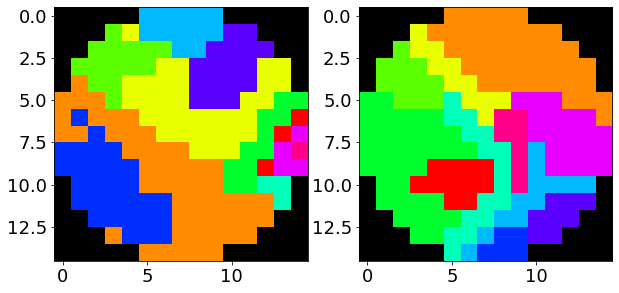

In [1451]:
nclust = 25
def cmp_clust(nclust, patterns, activations_n1, mask):
    clust, sorter, clust_cms = feat.do_clust(patterns[mask], activations_n1[:, mask], nclust, ctype = 'agglom', linkage='ward',
                                            affinity='euclidean')

    plt.subplot(1, 2, 1)
    d3d.plot_clusters_grid(d3d.get_coords(d3d.dgrid), clust, nclust)


    plt.subplot(1, 2, 2)
    d3d.plot_clusters_grid(d3d.get_coords(dgrid), y, 11)

    from sklearn.metrics import adjusted_mutual_info_score as ami
    from sklearn.metrics import adjusted_rand_score as rand

    ami(y, clust), rand(y, clust)
    return clust

    
ii = 42
clust = cmp_clust(11, data_samples[ii], transpose_x_3d_inv(X_samples[ii]), mask)

In [1398]:
def waterfall(X, spacing = 10):
    for i, row in enumerate(X):
        plt.plot(row + i * spacing)

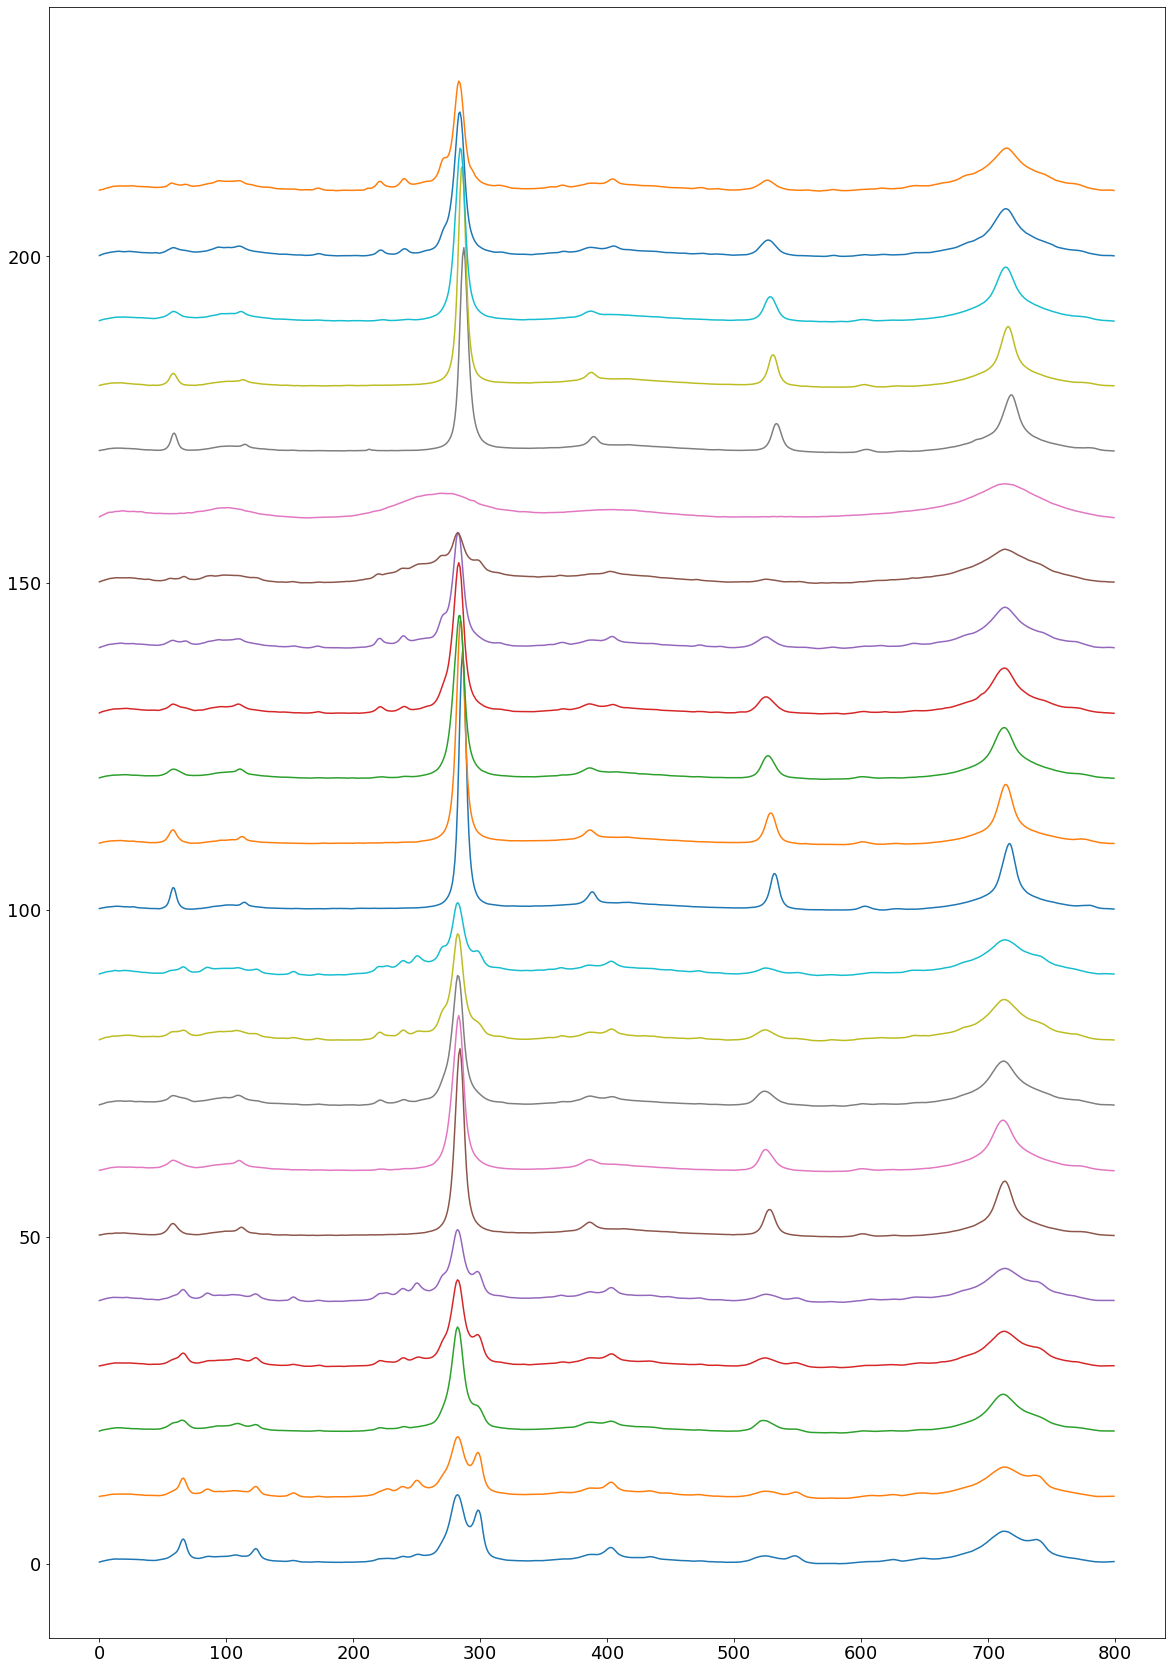

In [1402]:
waterfall(d3d.to_2d(patterns)[clust == 1])

In [1405]:
plt.rcParams["figure.figsize"]=(10, 8)

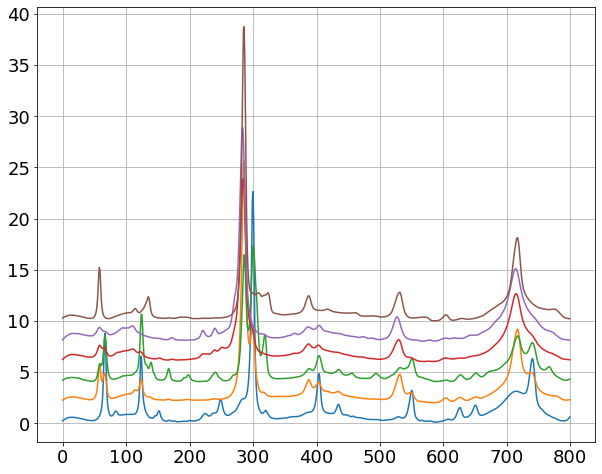

In [1429]:
for j in range(6):
    plt.plot(d3d.to_2d(patterns + j * 2)[clust == j].mean(axis = 0))
plt.grid()

In [ ]:
clust, sorter, clust_cms = feat.do_clust(patterns[mask], activations_n1[:, mask], nclust, ctype = 'agglom', linkage='average',
                                            affinity='l2')

In [624]:
# def transpose_x_3d(arr):
#     return np.swapaxes(
#             np.swapaxes(arr, 0, 2), 
#                 0, 1)

def transpose_x_3d_inv(arr):
    return np.swapaxes(
            np.swapaxes(arr, 0, 2), 
                1, 2)

In [ ]:
i = 5
vis.plot_summary(patterns[i], background[i], fast_q[i], slow_T[i], fast_T[i],
        np.swapaxes(
            np.swapaxes(activations_n1, 0, 2), 
                0, 1)[i]
        )

In [401]:
mask.shape

(15, 15)

In [ ]:
np.percentile

In [388]:
vis.plot_summary(activations_n1, straightened_heatmap)

NameError: name 'straightened_heatmap' is not defined

In [381]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [364]:
new_feat_masks.dtype

dtype('bool')

In [365]:
np.sign(0)

0

In [370]:
feat.shuffle(new_feat_masks)

3
3
3
3
3
3
3
3
3


array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa

In [337]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [338]:
# def mask_borders(arr, num=1):
#     mask = np.zeros(arr.shape, bool)
#     for dim in range(arr.ndim):
#         mask[tuple(slice(0, num) if idx == dim else slice(None) for idx in range(arr.ndim))] = True  
#         mask[tuple(slice(-num, None) if idx == dim else slice(None) for idx in range(arr.ndim))] = True  
#     return mask


3
3
3


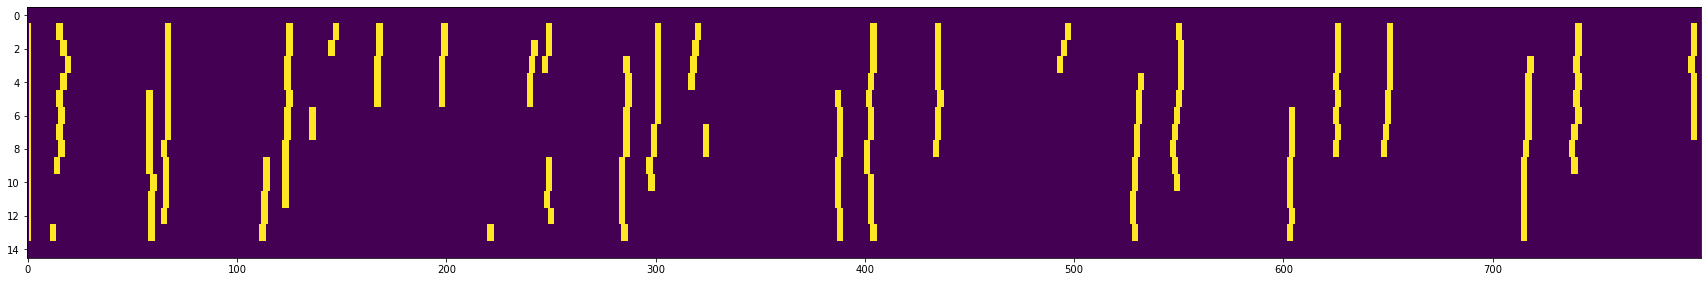

In [359]:
plt.imshow(feat.shuffle(new_ridges, 0, 1)[6], aspect = 8, interpolation = 'none')

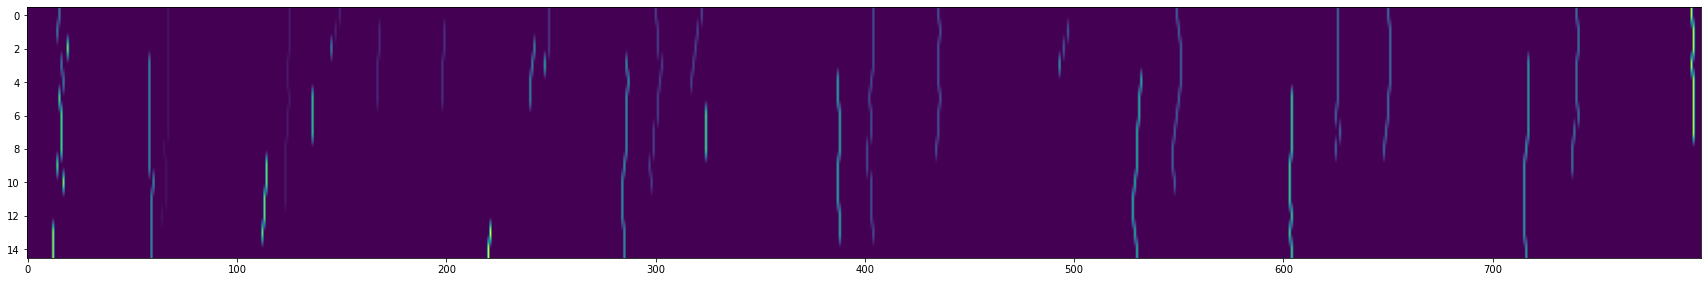

In [360]:
plt.imshow(tmp[5], aspect = 8)

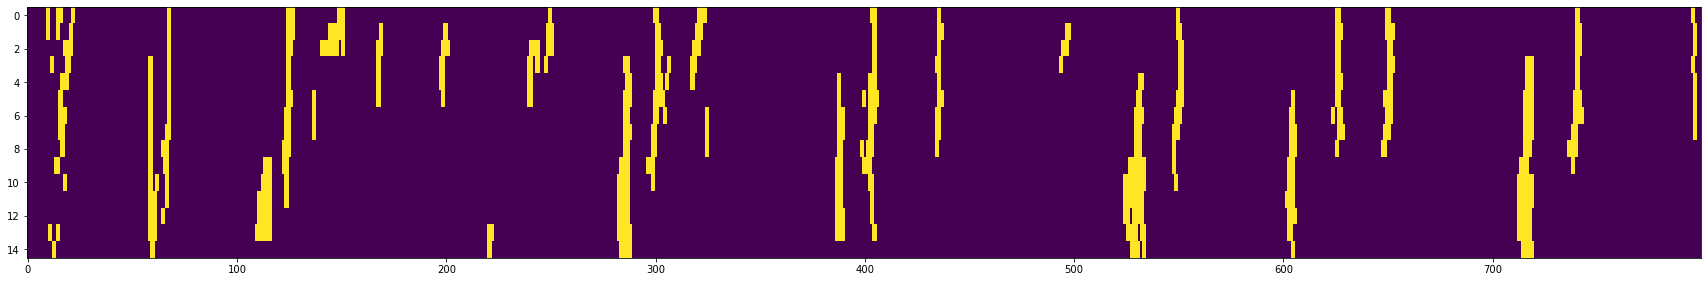

In [283]:
plt.imshow(feature_masks.sum(axis = 0)[5, :, :], aspect = 8, interpolation = 'none')

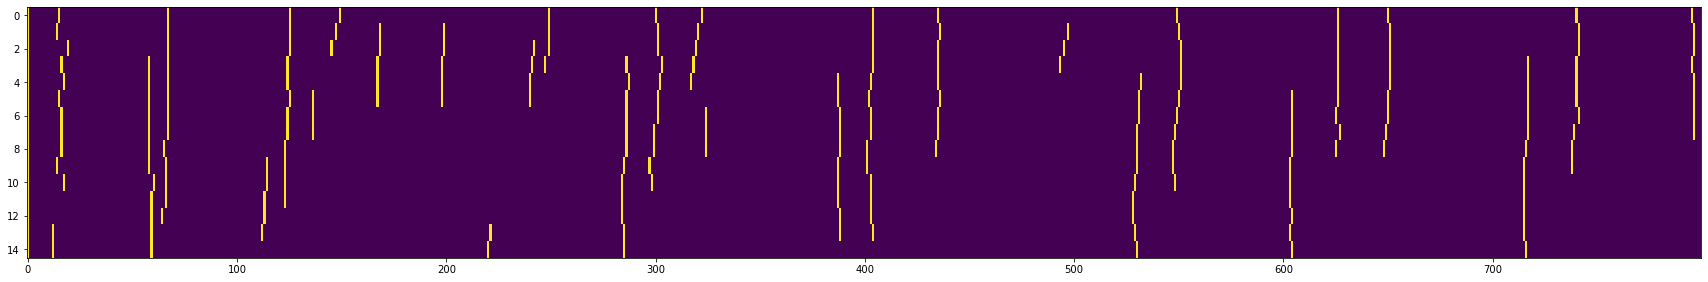

In [284]:
plt.imshow(new_feat_masks.sum(axis = 0).astype(bool)[5], aspect = 8, interpolation = 'none')

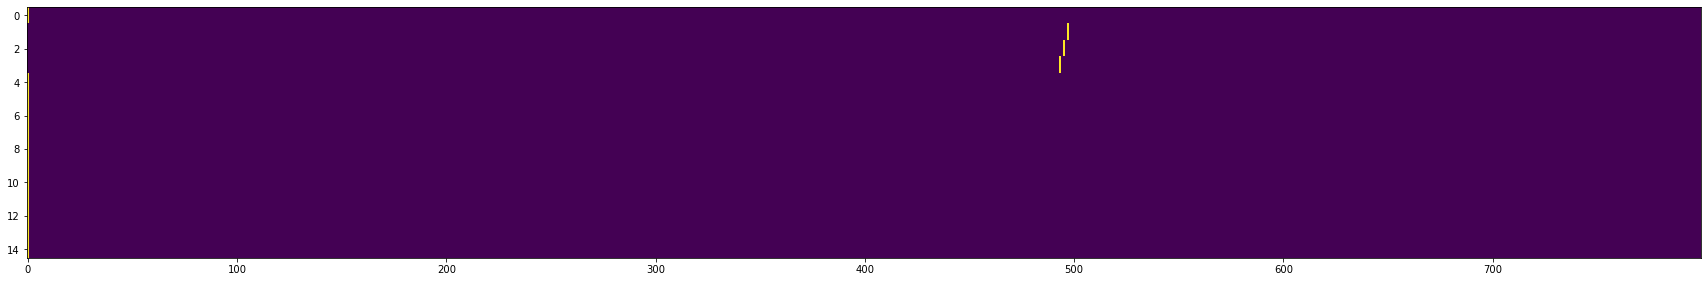

In [272]:
plt.imshow(new_feat_masks[10][5, :, :], aspect = 8, interpolation = 'none')

In [235]:
target_shape

(38, 15, 15, 1)

In [219]:
new_feat_masks[np.broadcast_arrays(ia, ib, ic)]

<ipython-input-219-567698271f1b>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_feat_masks[np.broadcast_arrays(ia, ib, ic, iid)]


array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa

(38, 15, 15)

In [199]:
iid[:, :, :] = feat_coord_median.astype(int)

ValueError: could not broadcast input array from shape (38,15,15) into shape (1,1,1,800)

In [202]:
new_feat_masks[ia, ib, ic, :].shape

(38, 15, 15, 1, 800)

In [185]:
new_feat_masks[feat_coord_median.astype(int)]

IndexError: index 67 is out of bounds for axis 0 with size 38

In [183]:
feat_coord_median.astype(int)

(38, 15, 15)

In [177]:
feat_coord_median[10]

array([[  0. , 496.5, 495. , 493.5,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 497. , 495.5, 493.5,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 497. , 495.5, 493.5,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 497. , 495.5, 493.5,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 497. , 495.5, 493.5,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 497. , 495.5, 493.5,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 497. , 495.5, 493.5,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 497. , 495.5, 493.5,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 497. , 49